In [98]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
import joblib
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit, MultilabelStratifiedKFold 
from hyperopt import fmin, tpe, hp, anneal, Trials
from sklearn.model_selection import cross_val_score, ValidationCurveDisplay, LearningCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score, average_precision_score, roc_curve, roc_auc_score, average_precision_score, precision_recall_curve, log_loss
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, GaussianNB
import scipy.stats as stats

## Import datasets

In [3]:
df_film_genr_split = pd.read_csv('df_film_genr_split.csv')

In [4]:
df_film_genr_split.drop('Unnamed: 0', axis = 1, inplace = True)

In [5]:
df_film_genr_split

color  num_critic_for_reviews  duration  director_facebook_likes  \
0         1                6.584791     154.0                 0.000000   
1         1                5.713733     154.0                 6.071170   
2         1                6.401917     148.0                 0.000000   
3         1                6.701960     154.0                 9.352045   
4         1                6.137727     132.0                 5.915288   
...     ...                     ...       ...                      ...   
3964      1                3.583519      80.0                 0.000000   
3965      1                4.043051      81.0                 0.000000   
3966      1                2.708050      95.0                 0.000000   
3967      1                2.708050     100.0                 0.000000   
3968      1                3.784190      90.0                 2.779602   

      actor_3_facebook_likes  actor_1_facebook_likes       gross  \
0                   1.168849                0.072778  458.232095   
1                   1.662001                2.203406  405.213291   
2                  -0.641887                0.618093  365.627474   
3                   2.702306                1.848354  442.161146   
4                   0.357329               -0.698425  288.176664   
...                      ...                     ...         ...   
3964               -2.697065               -2.625239   53.554440   
3965               -1.940903               -1.709702  122.686866   
3966               -0.739218               -1.321313   26.336520   
3967                0.259972               -0.160924   32.819115   
3968               -1.628097               -1.853272   56.256083   

      num_voted_users  cast_total_facebook_likes  num_user_for_reviews  ...  \
0           41.549853                   0.256357              8.013987  ...   
1           37.422218                   1.950373              7.122060  ...   
2           34.198669                   0.494930              6.902743  ...   
3           43.080011                   2.714582              7.901748  ...   
4           32.705202                  -0.529313              6.605298  ...   
...               ...                        ...                   ...  ...   
3964        10.313532                  -2.714108              3.583519  ...   
3965        25.578216                  -1.913332              4.875197  ...   
3966        12.441268                  -1.269250              2.708050  ...   
3967        12.266244                  -0.312559              2.302585  ...   
3968        15.912327                  -1.875003              4.442651  ...   

      News  Romance  Sci-Fi  Sport  Thriller  War  Western  \
0        0        0       1      0         0    0        0   
1        0        0       0      0         0    0        0   
2        0        0       0      0         1    0        0   
3        0        0       0      0         1    0        0   
4        0        0       1      0         0    0        0   
...    ...      ...     ...    ...       ...  ...      ...   
3964     0        0       0      0         1    0        0   
3965     0        1       0      0         1    0        0   
3966     0        0       0      0         0    0        0   
3967     0        1       0      0         0    0        0   
3968     0        0       0      0         0    0        0   

      content_rating_high_gross  war_symb_title_low_gross  \
0                             0                       0.0   
1                             0                       0.0   
2                             0                       0.0   
3                             0                       1.0   
4                             0                       1.0   
...                         ...                       ...   
3964                          1                       0.0   
3965                          1                       1.0   
3966                          1                       1.0

In [6]:
df_film_genr_split_test = pd.read_csv('df_film_genr_split_test.csv')

In [7]:
df_film_genr_split_test.drop('Unnamed: 0', axis = 1, inplace = True)

In [8]:
df_film_genr_split_test

color  num_critic_for_reviews  duration  director_facebook_likes  \
0        1                2.397895     109.0                 6.123342   
1        1                4.442651     123.0                 5.065120   
2        1                2.322227      89.0                 0.000000   
3        1                4.584967     114.0                 5.901657   
4        1                3.988984     119.0                 4.869165   
..     ...                     ...       ...                      ...   
534      1                2.322227      83.0                 4.773371   
535      0                3.970292     109.0                 3.223438   
536      1                4.077537      80.0                 6.491649   
537      1                3.784190      91.0                 4.899006   
538      1                3.761200      78.0                 4.386257   

     actor_3_facebook_likes  actor_1_facebook_likes  gross  num_voted_users  \
0                 -0.244110               -0.744209    NaN        13.771223   
1                 -0.961322               -0.411946    NaN        21.313519   
2                 -1.552351               -1.583958    NaN         8.157972   
3                  1.330788                0.072778    NaN        24.584322   
4                  2.348277                0.735389    NaN        22.703694   
..                      ...                     ...    ...              ...   
534               -1.042333               -1.305714    NaN         7.775586   
535               -2.129940               -2.259795    NaN        12.899477   
536                0.271245               -0.064047    NaN        20.363122   
537               -0.298237               -0.727992    NaN        15.557313   
538               -0.969337               -1.128281    NaN        13.226302   

     cast_total_facebook_likes  num_user_for_reviews  ...  News  Romance  \
0                    -0.480471              2.772589  ...     0        1   
1                    -0.718835              4.990433  ...     0        0   
2                    -1.564432              2.202850  ...     0        0   
3                     0.114775              5.950643  ...     0        0   
4                     1.610122              4.969813  ...     0        0   
..                         ...                   ...  ...   ...      ...   
534                  -1.344460              2.202850  ...     0        0   
535                  -2.360005              3.178054  ...     0        0   
536                  -0.025448              4.867534  ...     0        0   
537                  -0.193486              3.526361  ...     0        0   
538                  -1.288766              3.583519  ...     0        0   

     Sci-Fi  Sport  Thriller  War  Western  content_rating_high_gross  \
0         1      0         0    0        0                          1   
1         0      0         0    0        0                          1   
2         0      0         0    0        0                          0   
3         0      0         0    1        0                          0   
4         0      0         0    0        1                          0   
..      ...    ...       ...  ...      ...                        ...   
534       0      0         0    0        0                          1   
535       0      0         0    0        0                          1   
536       0      0         1    0        0                          1   
537       0      0         1    0        0                          1   
538       1      0         1    0        0                          1   

     war_symb_title_low_gross  facenumber_in_poster_low_gross  
0                         0.0                             1.0  
1                         1.0                             1.0  
2                         0.0                             1.0  
3                         1.0                             1.0  
4                         0.0                             1.0  
..   

## Fill miss value by using the model

In [10]:
model_lgbmr_split_genre = joblib.load('model_lgbmr_split_genre.pkl')

In [11]:
model_lgbmr_split_genre

LGBMRegressor(learning_rate=0.15, min_child_samples=9, n_estimators=77,
              num_leaves=27, random_state=42)

In [12]:
df_film_genr_split_test['gross'] = model_lgbmr_split_genre.predict(df_film_genr_split_test.drop('gross', axis = 1))

In [13]:
df_film_genr_split_test

color  num_critic_for_reviews  duration  director_facebook_likes  \
0        1                2.397895     109.0                 6.123342   
1        1                4.442651     123.0                 5.065120   
2        1                2.322227      89.0                 0.000000   
3        1                4.584967     114.0                 5.901657   
4        1                3.988984     119.0                 4.869165   
..     ...                     ...       ...                      ...   
534      1                2.322227      83.0                 4.773371   
535      0                3.970292     109.0                 3.223438   
536      1                4.077537      80.0                 6.491649   
537      1                3.784190      91.0                 4.899006   
538      1                3.761200      78.0                 4.386257   

     actor_3_facebook_likes  actor_1_facebook_likes       gross  \
0                 -0.244110               -0.744209   49.484807   
1                 -0.961322               -0.411946  202.464988   
2                 -1.552351               -1.583958   76.082600   
3                  1.330788                0.072778  276.127491   
4                  2.348277                0.735389  251.407555   
..                      ...                     ...         ...   
534               -1.042333               -1.305714   33.596914   
535               -2.129940               -2.259795   83.124323   
536                0.271245               -0.064047   74.492487   
537               -0.298237               -0.727992  115.939736   
538               -0.969337               -1.128281   28.300349   

     num_voted_users  cast_total_facebook_likes  num_user_for_reviews  ...  \
0          13.771223                  -0.480471              2.772589  ...   
1          21.313519                  -0.718835              4.990433  ...   
2           8.157972                  -1.564432              2.202850  ...   
3          24.584322                   0.114775              5.950643  ...   
4          22.703694                   1.610122              4.969813  ...   
..               ...                        ...                   ...  ...   
534         7.775586                  -1.344460              2.202850  ...   
535        12.899477                  -2.360005              3.178054  ...   
536        20.363122                  -0.025448              4.867534  ...   
537        15.557313                  -0.193486              3.526361  ...   
538        13.226302                  -1.288766              3.583519  ...   

     News  Romance  Sci-Fi  Sport  Thriller  War  Western  \
0       0        1       1      0         0    0        0   
1       0        0       0      0         0    0        0   
2       0        0       0      0         0    0        0   
3       0        0       0      0         0    1        0   
4       0        0       0      0         0    0        1   
..    ...      ...     ...    ...       ...  ...      ...   
534     0        0       0      0         0    0        0   
535     0        0       0      0         0    0        0   
536     0        0       0      0         1    0        0   
537     0        0       0      0         1    0        0   
538     0        0       1      0         1    0        0   

     content_rating_high_gross  war_symb_title_low_gross  \
0                            1                       0.0   
1                            1                       1.0   
2                            0                       0.0   
3                            0                       1.0   
4                            0                       0.0   
..                         ...                       ...   
534                          1                       1.0   
535                          1                       0.0   
536                          1                       1.0   
537                          1                       

In [14]:
df_film= pd.concat([df_film_genr_split, df_film_genr_split_test])

In [15]:
df_film.index = np.arange(df_film.shape[0])

In [16]:
df_film

color  num_critic_for_reviews  duration  director_facebook_likes  \
0         1                6.584791     154.0                 0.000000   
1         1                5.713733     154.0                 6.071170   
2         1                6.401917     148.0                 0.000000   
3         1                6.701960     154.0                 9.352045   
4         1                6.137727     132.0                 5.915288   
...     ...                     ...       ...                      ...   
4503      1                2.322227      83.0                 4.773371   
4504      0                3.970292     109.0                 3.223438   
4505      1                4.077537      80.0                 6.491649   
4506      1                3.784190      91.0                 4.899006   
4507      1                3.761200      78.0                 4.386257   

      actor_3_facebook_likes  actor_1_facebook_likes       gross  \
0                   1.168849                0.072778  458.232095   
1                   1.662001                2.203406  405.213291   
2                  -0.641887                0.618093  365.627474   
3                   2.702306                1.848354  442.161146   
4                   0.357329               -0.698425  288.176664   
...                      ...                     ...         ...   
4503               -1.042333               -1.305714   33.596914   
4504               -2.129940               -2.259795   83.124323   
4505                0.271245               -0.064047   74.492487   
4506               -0.298237               -0.727992  115.939736   
4507               -0.969337               -1.128281   28.300349   

      num_voted_users  cast_total_facebook_likes  num_user_for_reviews  ...  \
0           41.549853                   0.256357              8.013987  ...   
1           37.422218                   1.950373              7.122060  ...   
2           34.198669                   0.494930              6.902743  ...   
3           43.080011                   2.714582              7.901748  ...   
4           32.705202                  -0.529313              6.605298  ...   
...               ...                        ...                   ...  ...   
4503         7.775586                  -1.344460              2.202850  ...   
4504        12.899477                  -2.360005              3.178054  ...   
4505        20.363122                  -0.025448              4.867534  ...   
4506        15.557313                  -0.193486              3.526361  ...   
4507        13.226302                  -1.288766              3.583519  ...   

      News  Romance  Sci-Fi  Sport  Thriller  War  Western  \
0        0        0       1      0         0    0        0   
1        0        0       0      0         0    0        0   
2        0        0       0      0         1    0        0   
3        0        0       0      0         1    0        0   
4        0        0       1      0         0    0        0   
...    ...      ...     ...    ...       ...  ...      ...   
4503     0        0       0      0         0    0        0   
4504     0        0       0      0         0    0        0   
4505     0        0       0      0         1    0        0   
4506     0        0       0      0         1    0        0   
4507     0        0       1      0         1    0        0   

      content_rating_high_gross  war_symb_title_low_gross  \
0                             0                       0.0   
1                             0                       0.0   
2                             0                       0.0   
3                             0                       1.0   
4                             0                       1.0   
...                         ...                       ...   
4503                          1                       1.0   
4504                          1                       0.0   
4505                          1                       1.0

## Explore distribution of labels 

In [18]:
name_genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
               'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music','Musical', 'Mystery', 
               'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller','War', 'Western']

In [19]:
genres_df = df_film[name_genres].value_counts().reset_index(name='count')

In [20]:
genres_df

Action  Adventure  Animation  Biography  Comedy  Crime  Documentary  \
0         0          0          0          0       0      0            0   
1         0          0          0          0       1      0            0   
2         0          0          0          0       1      0            0   
3         0          0          0          0       1      0            0   
4         0          0          0          0       1      0            0   
..      ...        ...        ...        ...     ...    ...          ...   
854       0          0          1          0       1      0            0   
855       0          0          1          0       1      0            0   
856       0          0          1          0       1      0            0   
857       0          0          1          0       1      0            0   
858       1          1          1          0       1      1            0   

     Drama  Family  Fantasy  ...  Musical  Mystery  News  Romance  Sci-Fi  \
0        1       0        0  ...        0        0     0        0       0   
1        0       0        0  ...        0        0     0        0       0   
2        1       0        0  ...        0        0     0        1       0   
3        1       0        0  ...        0        0     0        0       0   
4        0       0        0  ...        0        0     0        1       0   
..     ...     ...      ...  ...      ...      ...   ...      ...     ...   
854      0       1        0  ...        0        0     0        1       0   
855      0       1        0  ...        1        0     0        0       0   
856      0       1        0  ...        0        0     0        0       0   
857      0       1        0  ...        0        0     0        1       0   
858      0       1        1  ...        0        0     0        0       0   

     Sport  Thriller  War  Western  count  
0        0         0    0        0    204  
1        0         0    0        0    181  
2        0         0    0        0    175  
3        0         0    0        0    170  
4        0         0    0        0    144  
..     ...       ...  ...      ...    ...  
854      0         0    0        0      1  
855      0         0    0        0      1  
856      0         0    0        1      1  
857      0         0    0        0      1  
858      0         0    0        0      1  

[859 rows x 24 columns]

In [21]:
genres_df['count'].value_counts()

count
1      480
2      107
3       56
4       36
5       27
7       19
6       18
9       11
8       11
10      10
11       9
16       8
14       7
15       6
23       5
12       5
13       4
34       3
18       3
19       3
21       2
24       2
28       2
29       2
60       2
47       2
181      1
52       1
175      1
170      1
144      1
143      1
89       1
59       1
55       1
48       1
49       1
25       1
44       1
33       1
30       1
17       1
26       1
22       1
204      1
Name: count, dtype: int64

In [22]:
genres_df[genres_df['count'] == 1]

Action  Adventure  Animation  Biography  Comedy  Crime  Documentary  \
379       1          1          1          0       1      0            0   
380       0          1          1          0       1      0            0   
381       1          1          0          0       1      1            0   
382       1          0          0          0       0      0            0   
383       1          1          1          0       1      0            0   
..      ...        ...        ...        ...     ...    ...          ...   
854       0          0          1          0       1      0            0   
855       0          0          1          0       1      0            0   
856       0          0          1          0       1      0            0   
857       0          0          1          0       1      0            0   
858       1          1          1          0       1      1            0   

     Drama  Family  Fantasy  ...  Musical  Mystery  News  Romance  Sci-Fi  \
379      0       0        1  ...        0        0     0        0       1   
380      0       0        1  ...        0        0     0        1       0   
381      0       1        0  ...        0        0     0        1       0   
382      1       0        0  ...        0        0     0        0       1   
383      0       0        1  ...        0        0     0        0       0   
..     ...     ...      ...  ...      ...      ...   ...      ...     ...   
854      0       1        0  ...        0        0     0        1       0   
855      0       1        0  ...        1        0     0        0       0   
856      0       1        0  ...        0        0     0        0       0   
857      0       1        0  ...        0        0     0        1       0   
858      0       1        1  ...        0        0     0        0       0   

     Sport  Thriller  War  Western  count  
379      0         0    0        0      1  
380      0         0    0        0      1  
381      0         1    0        0      1  
382      0         0    0        0      1  
383      0         0    0        0      1  
..     ...       ...  ...      ...    ...  
854      0         0    0        0      1  
855      0         0    0        0      1  
856      0         0    0        1      1  
857      0         0    0        0      1  
858      0         0    0        0      1  

[480 rows x 24 columns]

In [23]:
for genre in name_genres:
    print(f"Value counts for {genre}:")
    print(df_film[genre].value_counts())
    print("\n")

Value counts for Action:
Action
0    3457
1    1051
Name: count, dtype: int64


Value counts for Adventure:
Adventure
0    3664
1     844
Name: count, dtype: int64


Value counts for Animation:
Animation
0    4283
1     225
Name: count, dtype: int64


Value counts for Biography:
Biography
0    4231
1     277
Name: count, dtype: int64


Value counts for Comedy:
Comedy
0    2781
1    1727
Name: count, dtype: int64


Value counts for Crime:
Crime
0    3697
1     811
Name: count, dtype: int64


Value counts for Documentary:
Documentary
0    4431
1      77
Name: count, dtype: int64


Value counts for Drama:
Drama
1    2310
0    2198
Name: count, dtype: int64


Value counts for Family:
Family
0    4007
1     501
Name: count, dtype: int64


Value counts for Fantasy:
Fantasy
0    3961
1     547
Name: count, dtype: int64


Value counts for Film-Noir:
Film-Noir
0    4503
1       5
Name: count, dtype: int64


Value counts for History:
History
0    4321
1     187
Name: count, dtype: int64


Value 

In [24]:
df_film.loc[df_film['Film-Noir'] == 1, name_genres]

Action  Adventure  Animation  Biography  Comedy  Crime  Documentary  \
3636       0          0          0          0       0      1            0   
4359       0          0          0          0       0      0            0   
4377       0          0          0          0       0      0            0   
4378       0          0          0          0       0      0            0   
4381       0          0          0          0       0      1            0   

      Drama  Family  Fantasy  ...  Music  Musical  Mystery  News  Romance  \
3636      1       0        0  ...      0        0        1     0        0   
4359      0       0        0  ...      0        0        1     0        1   
4377      1       0        0  ...      0        0        1     0        0   
4378      1       0        0  ...      0        0        0     0        0   
4381      0       0        0  ...      0        0        0     0        0   

      Sci-Fi  Sport  Thriller  War  Western  
3636       0      0         1    0        0  
4359       0      0         1    0        0  
4377       0      0         1    0        0  
4378       0      0         0    0        0  
4381       0      0         1    0        0  

[5 rows x 23 columns]

In [25]:
df_film.loc[df_film['News'] == 1, name_genres]

Action  Adventure  Animation  Biography  Comedy  Crime  Documentary  \
2096       0          0          0          0       0      1            1   
4340       0          0          0          0       0      0            1   

      Drama  Family  Fantasy  ...  Music  Musical  Mystery  News  Romance  \
2096      0       0        0  ...      0        0        0     1        0   
4340      1       0        0  ...      0        0        0     1        0   

      Sci-Fi  Sport  Thriller  War  Western  
2096       0      0         0    0        0  
4340       0      0         0    0        0  

[2 rows x 23 columns]

In [26]:
df_film.drop('News', inplace = True, axis = 1)

In [27]:
df_film.drop('Film-Noir', inplace = True, axis = 1)

## Split the dataset

In [29]:
name_genres_new = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
               'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music','Musical', 'Mystery', 
               'Romance', 'Sci-Fi', 'Sport', 'Thriller','War', 'Western']

In [30]:
X_df = df_film.drop(name_genres_new, axis = 1)

In [31]:
X = X_df.values

In [32]:
y_df = df_film[name_genres_new]

In [33]:
y = y_df.values

In [34]:
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [35]:
for train_index, temp_index in msss.split(X, y):
   X_train, X_temp = X[train_index], X[temp_index]
   y_train, y_temp = y[train_index], y[temp_index]

In [36]:
split_test_valid = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

In [37]:
for valid_index, test_index in split_test_valid.split(X_temp, y_temp):
   X_valid, X_test = X[valid_index], X[test_index]
   y_valid, y_test = y[valid_index], y[test_index]

In [38]:
X.shape

(4508, 21)

In [39]:
X_train.shape

(3615, 21)

In [40]:
X_valid.shape

(799, 21)

In [41]:
X_test.shape

(94, 21)

## Logistic regression

In [80]:
n_iter = 100
random_state = 42

### Tuning hyperparametres

In [45]:
def tune_hyperpar_anneal(model_name, space, X, y, scoring):
    def gb_mse_cv(params, random_state=random_state):
        model = model_name(random_state=random_state, **params)
        model = MultiOutputClassifier(model)
        score = cross_val_score(model, X, y, cv= MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=42), scoring= scoring, n_jobs=-1).mean()
        return -score
    
    trials_sim_anneal = Trials()
    best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=anneal.suggest, # (optimization algorithm) hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials_sim_anneal, # logging
          rstate=np.random.default_rng(random_state) 
         )
    return {'best': best, 'trials': trials_sim_anneal}

In [46]:
space = { 
    'solver': 'liblinear',
    'C': hp.loguniform('C', np.log(0.1), np.log(10))
}

In [47]:
dict_tun_hyper = tune_hyperpar_anneal(LogisticRegression, space, X_train, y_train, 'average_precision')

100%|██████| 100/100 [00:46<00:00,  2.17trial/s, best loss: -0.3637250681368912]


In [48]:
best = dict_tun_hyper['best']

In [49]:
best

{'C': 1.9900835396164234}

In [50]:
model_log_regression = LogisticRegression(random_state = random_state, solver = 'liblinear')

In [51]:
multi_target_mod_log_reg_test = MultiOutputClassifier(model_log_regression)

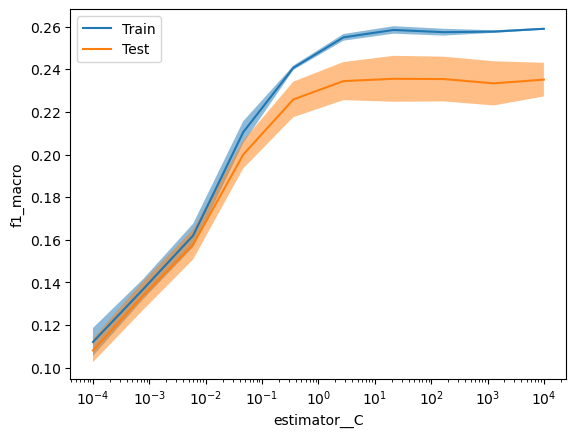

In [52]:
ValidationCurveDisplay.from_estimator(multi_target_mod_log_reg_test, 
                                      X = X_train, 
                                      y = y_train, 
                                      param_name='estimator__C',
                                      param_range = np.logspace(-4, 4, 10), 
                                      scoring = 'f1_macro', 
                                      score_name = 'f1_macro', 
                                      cv = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=42))

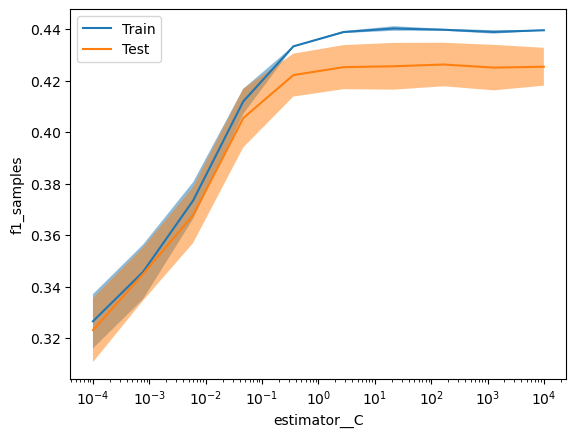

In [53]:
ValidationCurveDisplay.from_estimator(multi_target_mod_log_reg_test, 
                                      X = X_train, 
                                      y = y_train, 
                                      param_name='estimator__C',
                                      param_range = np.logspace(-4, 4, 10), 
                                      scoring = 'f1_samples', 
                                      score_name = 'f1_samples', 
                                      cv = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=42))

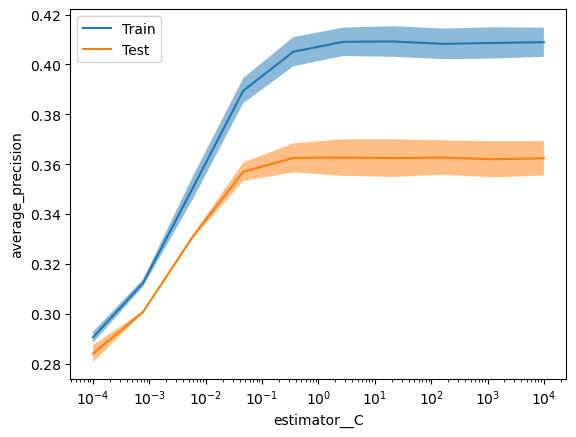

In [54]:
ValidationCurveDisplay.from_estimator(multi_target_mod_log_reg_test, 
                                      X = X_train, 
                                      y = y_train, 
                                      param_name='estimator__C',
                                      param_range = np.logspace(-4, 4, 10), 
                                      scoring = 'average_precision', 
                                      score_name = 'average_precision', 
                                      cv = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=42))

### Fit the model

In [419]:
mod_log_reg = MultiOutputClassifier(LogisticRegression(random_state = random_state, solver = 'liblinear', C = 0.27))

In [421]:
mod_log_reg.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression(C=0.27, random_state=42,
                                                   solver='liblinear'))

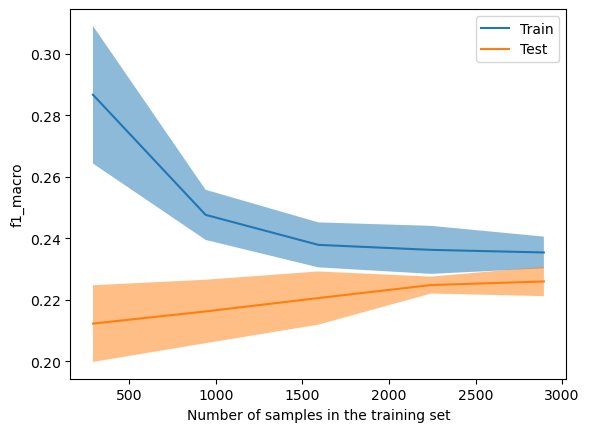

In [58]:
LearningCurveDisplay.from_estimator(mod_log_reg, 
                                    X = X_train, 
                                    y = y_train,  
                                    scoring = 'f1_macro', 
                                    score_name = 'f1_macro', 
                                    cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                    shuffle=True, random_state=42)

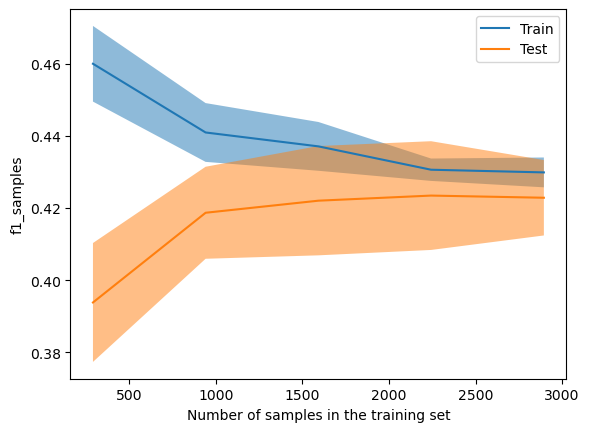

In [59]:
LearningCurveDisplay.from_estimator(mod_log_reg, 
                                    X = X_train, 
                                    y = y_train,  
                                    scoring = 'f1_samples', 
                                    score_name = 'f1_samples', 
                                    cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                    shuffle=True, random_state=42)

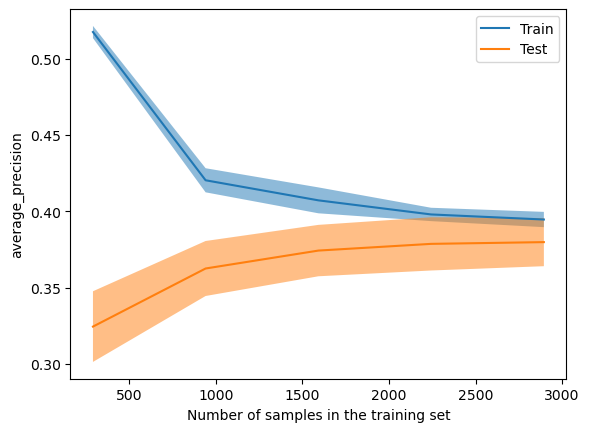

In [60]:
LearningCurveDisplay.from_estimator(mod_log_reg, 
                                    X = X_train, 
                                    y = y_train,  
                                    scoring = 'average_precision', 
                                    score_name = 'average_precision', 
                                    cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                    shuffle=True, random_state=42)

In [61]:
predict_y = mod_log_reg.predict(X_valid)

In [62]:
predict_y

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [63]:
X_valid.shape

(799, 21)

In [64]:
metrics_log_reg = pd.DataFrame.from_dict(classification_report(y_valid, predict_y, target_names= name_genres_new, output_dict=True)).T.sort_values(by = 'support')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [65]:
metrics_log_reg

precision    recall  f1-score  support
Documentary    0.000000  0.000000  0.000000      1.0
Music          0.000000  0.000000  0.000000     14.0
Western        0.000000  0.000000  0.000000     14.0
Sport          0.000000  0.000000  0.000000     27.0
Biography      0.000000  0.000000  0.000000     27.0
Musical        0.000000  0.000000  0.000000     28.0
Horror         0.142857  0.028571  0.047619     35.0
History        0.000000  0.000000  0.000000     40.0
War            1.000000  0.024390  0.047619     41.0
Mystery        0.000000  0.000000  0.000000     82.0
Crime          0.428571  0.025210  0.047619    119.0
Animation      0.829787  0.655462  0.732394    119.0
Romance        0.000000  0.000000  0.000000    125.0
Sci-Fi         0.645161  0.102564  0.176991    195.0
Family         0.879195  0.668367  0.759420    196.0
Fantasy        0.500000  0.084906  0.145161    212.0
Drama          0.616541  0.614232  0.615385    267.0
Thriller       0.625899  0.321033  0.424390    271.0
Comedy         0.768908  0.644366  0.701149    284.0
Adventure      0.739130  0.652055  0.692868    365.0
Action         0.701183  0.606138  0.650206    391.0
micro avg      0.713145  0.406940  0.518188   2853.0
macro avg      0.375106  0.210824  0.240039   2853.0
weighted avg   0.594610  0.406940  0.454310   2853.0
samples avg    0.655069  0.411419  0.474787   2853.0

### Explore default threshold (0.5)

In [67]:
mod_log_reg.classes_

[array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1])]

In [68]:
### [0,1] means 0- negative class, 1- positive class

In [69]:
y_scores = mod_log_reg.predict_proba(X_valid)

In [70]:
y_scores

[array([[0.63009107, 0.36990893],
        [0.26238137, 0.73761863],
        [0.37097743, 0.62902257],
        ...,
        [0.85193539, 0.14806461],
        [0.71411659, 0.28588341],
        [0.65132884, 0.34867116]]),
 array([[0.19281226, 0.80718774],
        [0.28245606, 0.71754394],
        [0.15944609, 0.84055391],
        ...,
        [0.63198026, 0.36801974],
        [0.7695604 , 0.2304396 ],
        [0.81219703, 0.18780297]]),
 array([[9.96074508e-01, 3.92549171e-03],
        [9.99480020e-01, 5.19979672e-04],
        [9.97256078e-01, 2.74392224e-03],
        ...,
        [6.26845102e-01, 3.73154898e-01],
        [9.99718942e-01, 2.81058383e-04],
        [9.99312234e-01, 6.87765829e-04]]),
 array([[0.94220249, 0.05779751],
        [0.88921986, 0.11078014],
        [0.85172932, 0.14827068],
        ...,
        [0.98401082, 0.01598918],
        [0.95413263, 0.04586737],
        [0.93757401, 0.06242599]]),
 array([[0.77770219, 0.22229781],
        [0.87566504, 0.12433496],
        

In [71]:
len(y_scores)

21

In [72]:
pd.DataFrame(np.array([scores[:, 1] for scores in y_scores])).T

0         1         2         3         4         5         6   \
0    0.369909  0.807188  0.003925  0.057798  0.222298  0.051416  0.000414   
1    0.737619  0.717544  0.000520  0.110780  0.124335  0.178068  0.000055   
2    0.629023  0.840554  0.002744  0.148271  0.067993  0.089347  0.000383   
3    0.628883  0.655624  0.000545  0.191881  0.133904  0.167208  0.000018   
4    0.686353  0.628222  0.003858  0.051590  0.170371  0.142981  0.000223   
..        ...       ...       ...       ...       ...       ...       ...   
794  0.543083  0.369284  0.075010  0.042168  0.689713  0.251172  0.000148   
795  0.189047  0.347119  0.067821  0.058559  0.476260  0.089531  0.004396   
796  0.148065  0.368020  0.373155  0.015989  0.781897  0.069151  0.008590   
797  0.285883  0.230440  0.000281  0.045867  0.193606  0.096363  0.000060   
798  0.348671  0.187803  0.000688  0.062426  0.115971  0.338864  0.001273   

           7         8         9   ...        11        12        13  \
0    0.479982  0.127385  0.483770  ...  0.010030  0.025955  0.056870   
1    0.624314  0.058235  0.197823  ...  0.003342  0.035897  0.033180   
2    0.655518  0.077589  0.335973  ...  0.014129  0.019277  0.016343   
3    0.705082  0.037711  0.209144  ...  0.001842  0.015798  0.023240   
4    0.473827  0.038653  0.298077  ...  0.019180  0.018345  0.022445   
..        ...       ...       ...  ...       ...       ...       ...   
794  0.237622  0.207561  0.240200  ...  0.006158  0.019146  0.008181   
795  0.401383  0.532909  0.142403  ...  0.023674  0.073846  0.034947   
796  0.180017  0.743269  0.246913  ...  0.020770  0.069836  0.031298   
797  0.601837  0.035750  0.187651  ...  0.045328  0.045608  0.027425   
798  0.651412  0.002824  0.078013  ...  0.044342  0.015789  0.010977   

           14        15        16        17        18        19        20  
0    0.090770  0.200002  0.482922  0.026188  0.122717  0.056877  0.005809  
1    0.111168  0.222502  0.264710  0.047506  0.387478  0.093258  0.046350  
2    0.171346  0.186890  0.366575  0.014747  0.396741  0.172358  0.010372  
3    0.103561  0.210819  0.311434  0.049772  0.282307  0.094441  0.041271  
4    0.145063  0.178247  0.441839  0.030196  0.399390  0.064921  0.005089  
..        ...       ...       ...       ...       ...       ...       ...  
794  0.050957  0.247696  0.163712  0.084214  0.246943  0.006772  0.008999  
795  0.061607  0.206575  0.063638  0.069194  0.175680  0.011015  0.015512  
796  0.036863  0.238231  0.108632  0.042764  0.102311  0.005470  0.002774  
797  0.170153  0.220168  0.174661  0.019400  0.324294  0.019076  0.028690  
798  0.180048  0.141366  0.111026  0.013846  0.507619  0.052374  0.034812  

[799 rows x 21 columns]

In [73]:
y_scores_pos_class = np.array([scores[:, 1] for scores in y_scores]).T

In [74]:
y_scores_pos_class.shape

(799, 21)

In [75]:
y_valid.shape

(799, 21)

In [361]:
def plot_roc(name_genres_new, y_valid, y_score_pred, default_thr):
    for i, label in enumerate(name_genres_new):
        fpr, tpr, thresholds = roc_curve(y_valid[:, i], y_score_pred[:, i])
        auc = roc_auc_score(y_valid[:, i], y_score_pred[:, i])
        plt.plot(fpr, tpr, label = 'ROC curve')
        threshold_index = np.argmin(np.abs(thresholds - default_thr))
        plt.plot(fpr[threshold_index], tpr[threshold_index], 'ro', label = f'Threshold = {default_thr}')
        plt.plot([0, 1], [0, 1], 'k--', label = 'Random choice')  # Diagonal line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC curve for {label}, AUC {auc}')
        plt.legend()
        plt.show()

In [363]:
def plot_pr_curve(name_genres_new, y_valid, y_score_pred, default_thr):
    for i, label in enumerate(name_genres_new):
        default_threshold = 0.5
        fpr, tpr, thresholds = precision_recall_curve(y_valid[:, i], y_score_pred[:, i])
        ap = average_precision_score(y_valid[:, i], y_score_pred[:, i])
        threshold_index = np.argmin(np.abs(thresholds - default_thr))
        plt.plot(fpr, tpr, label = 'PR curve')
        plt.plot(fpr[threshold_index], tpr[threshold_index], 'ro', label = f'Threshold = {default_thr}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'PR curve for {label}, AP {ap}')
        plt.legend()
        plt.show()

In [423]:
default_thresh_log_reg = 0.5

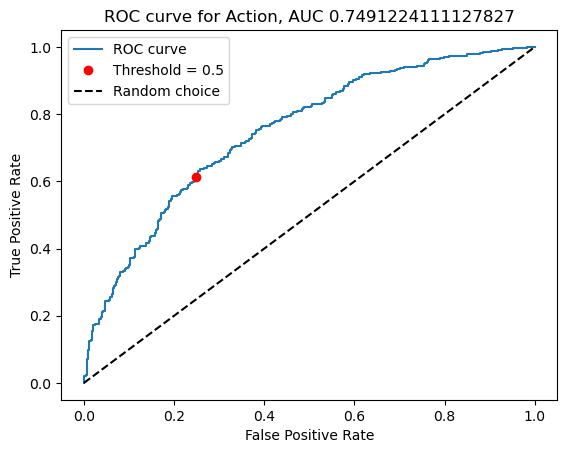

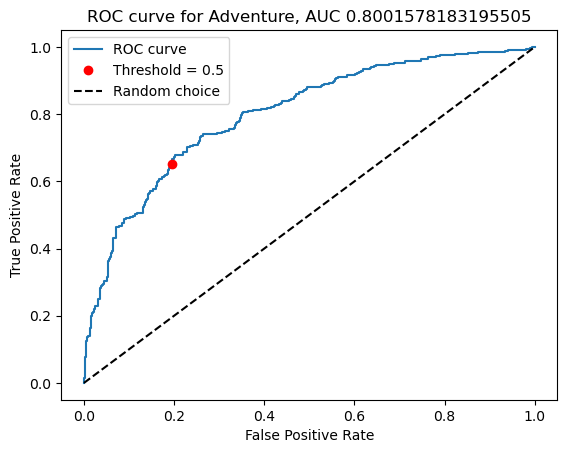

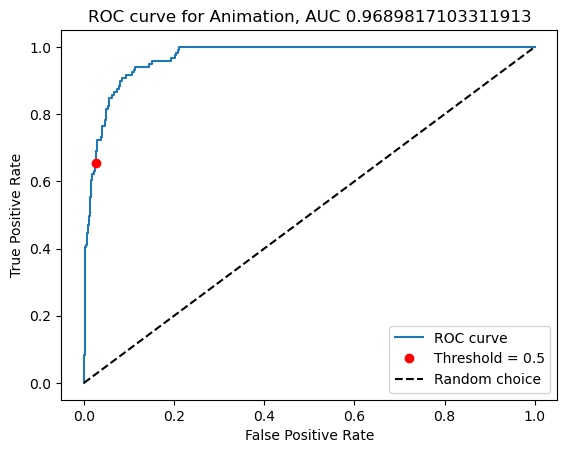

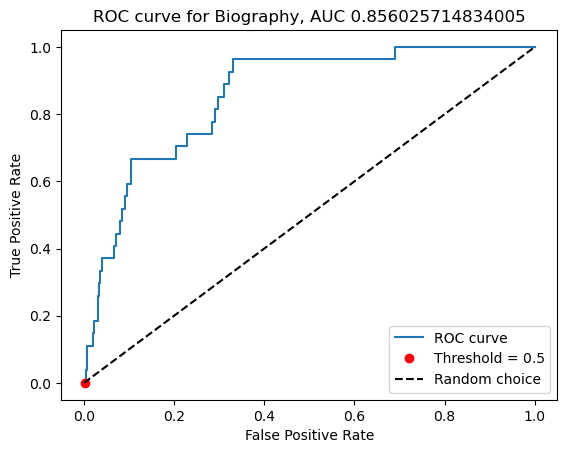

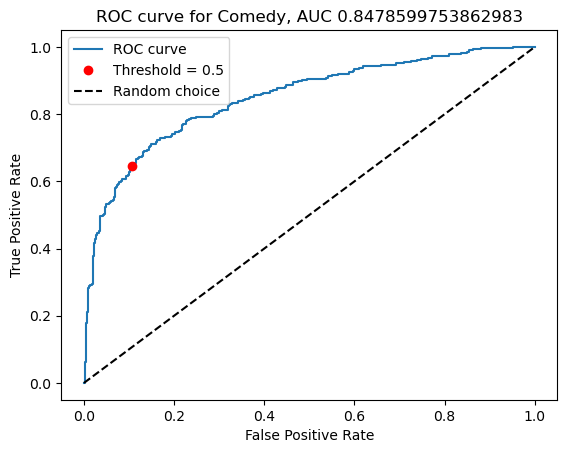

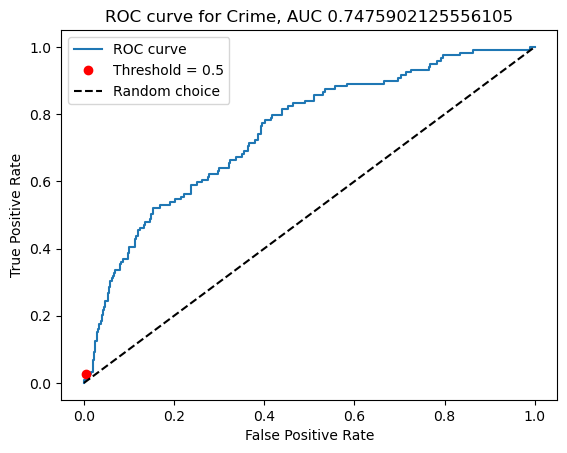

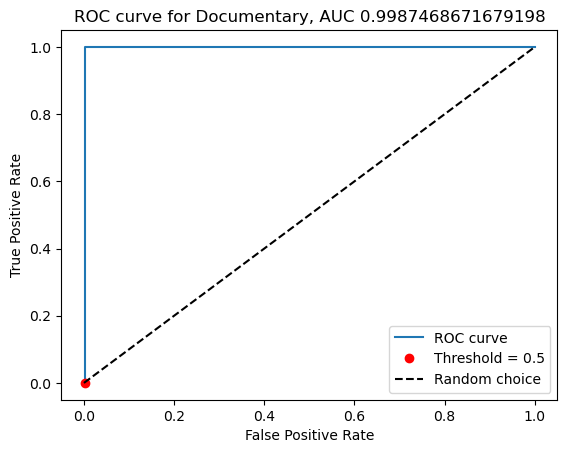

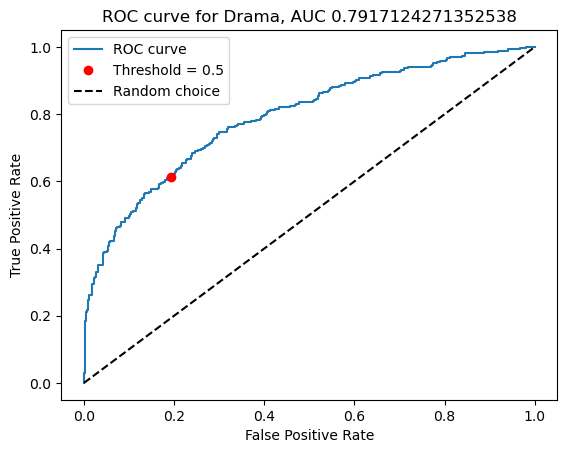

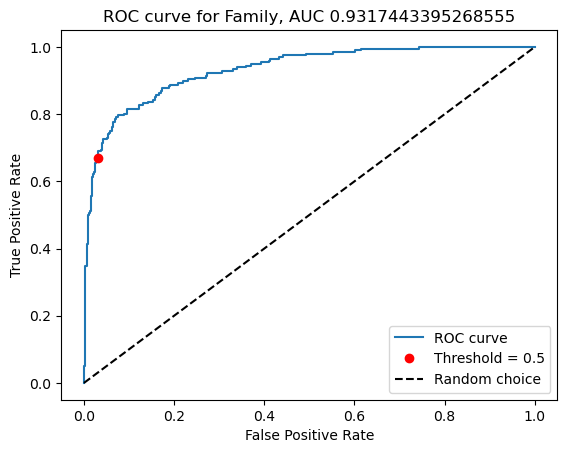

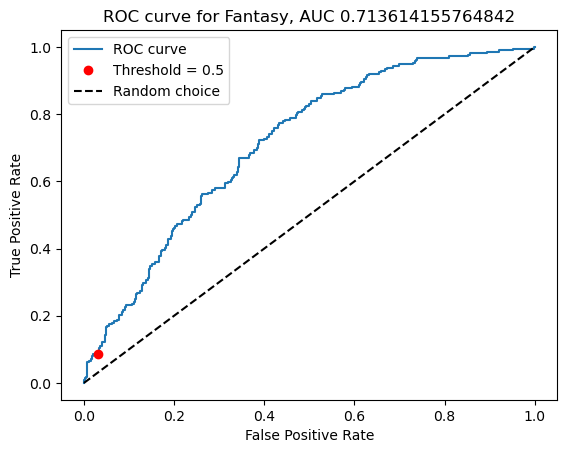

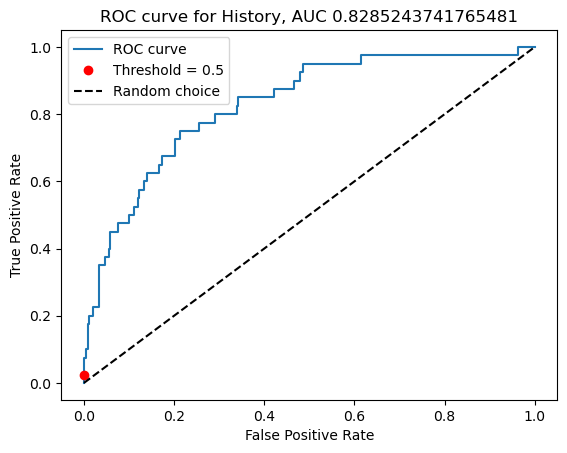

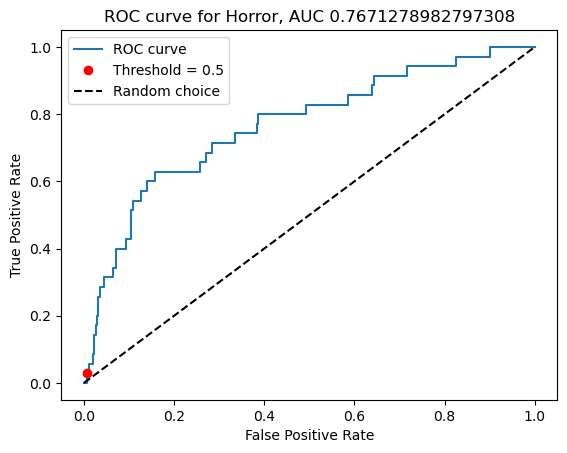

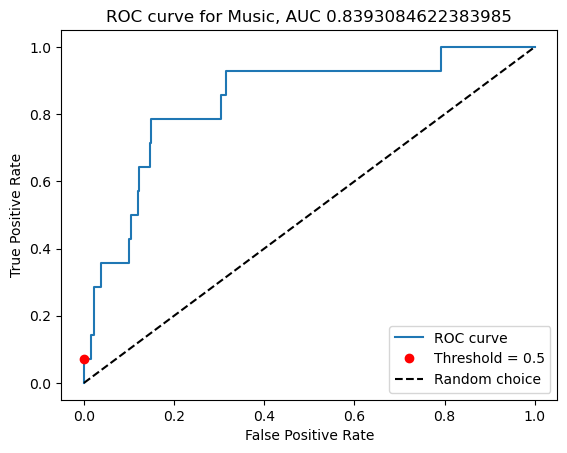

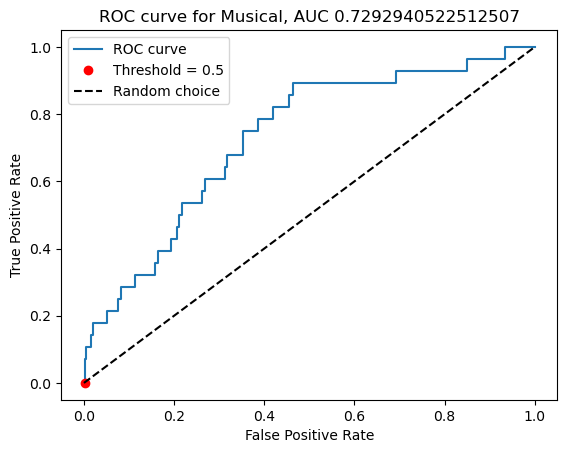

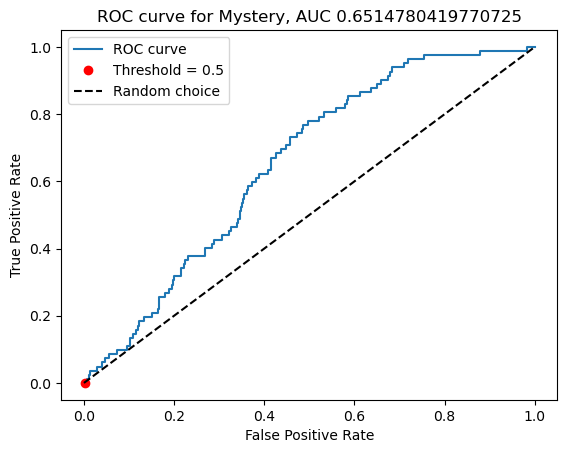

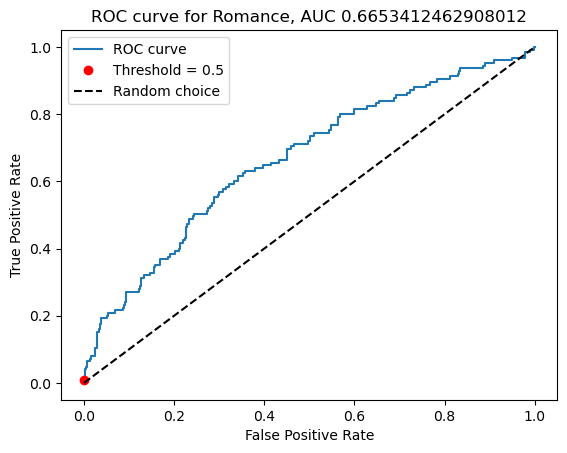

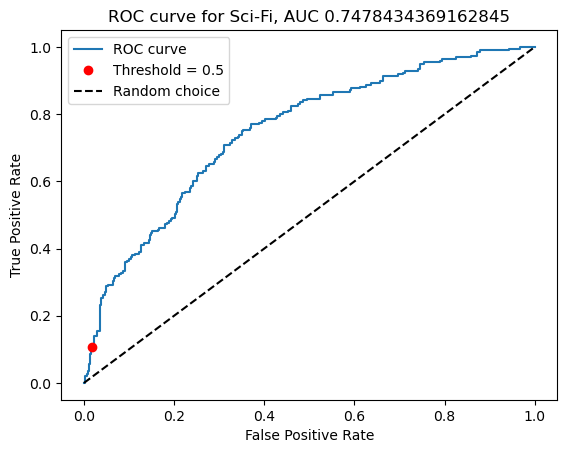

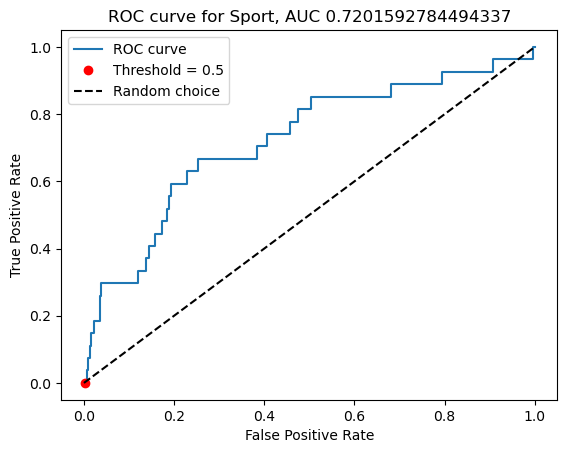

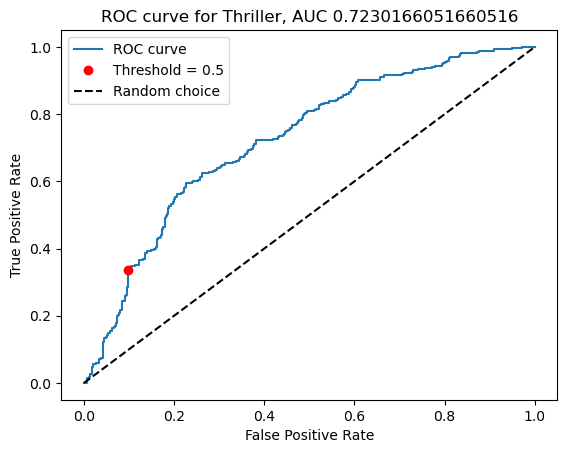

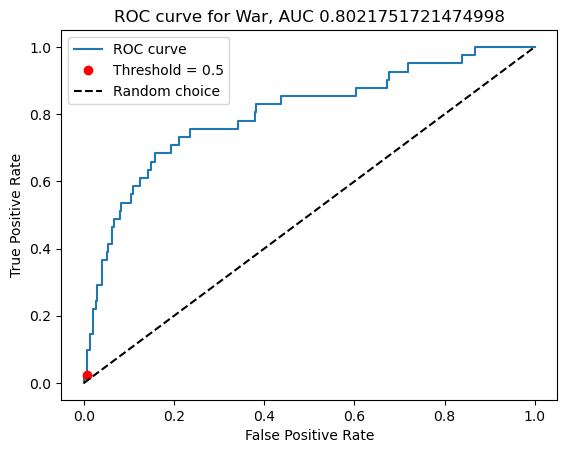

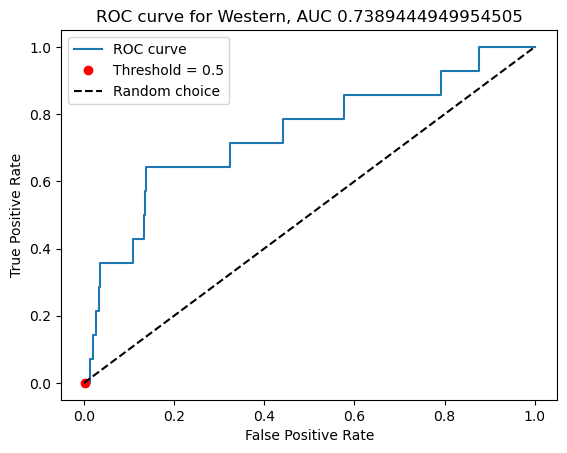

In [79]:
plot_roc(name_genres_new, y_valid, y_scores_pos_class, default_thresh_log_reg)

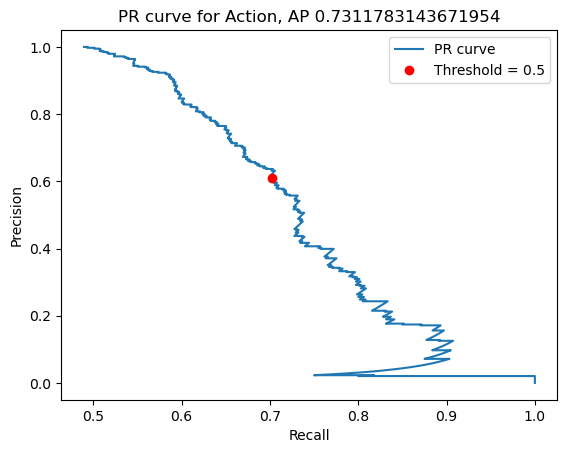

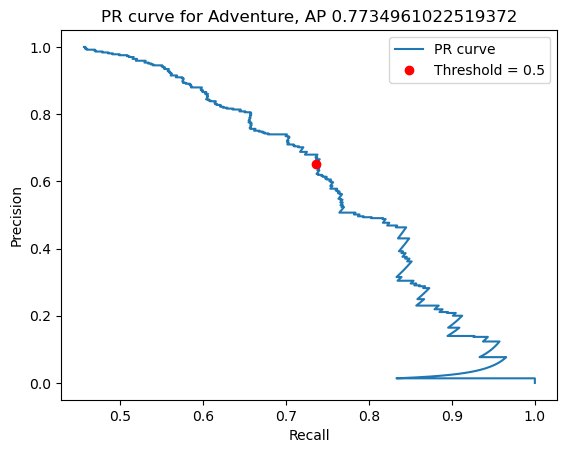

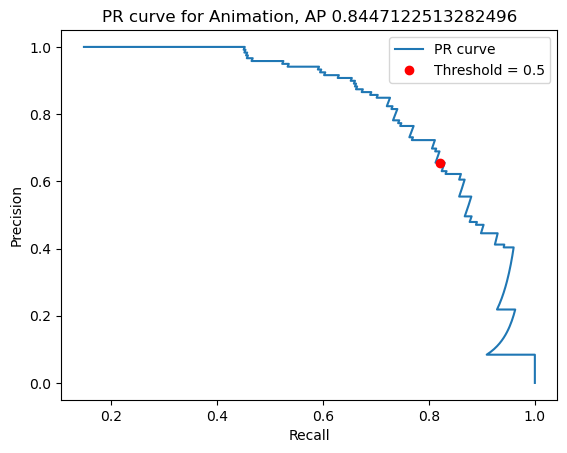

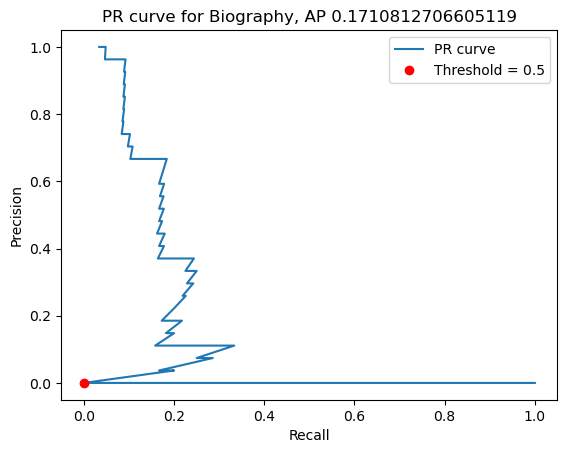

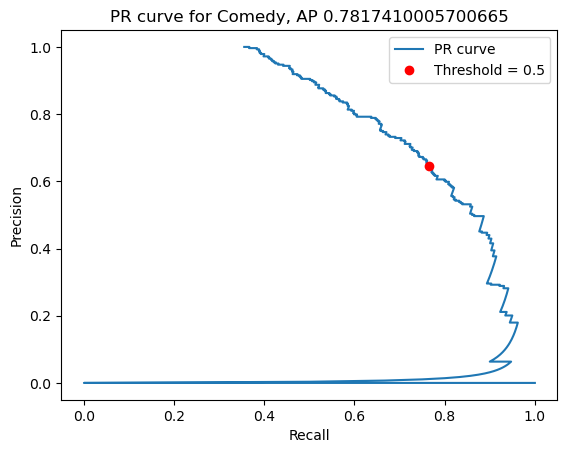

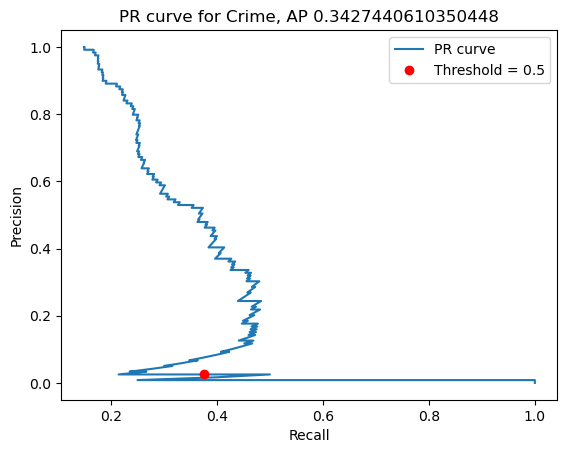

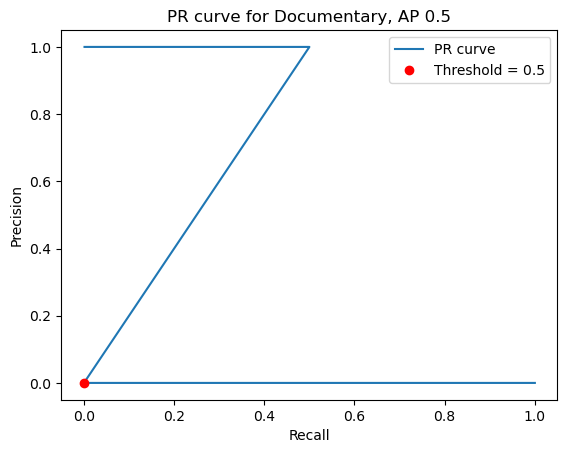

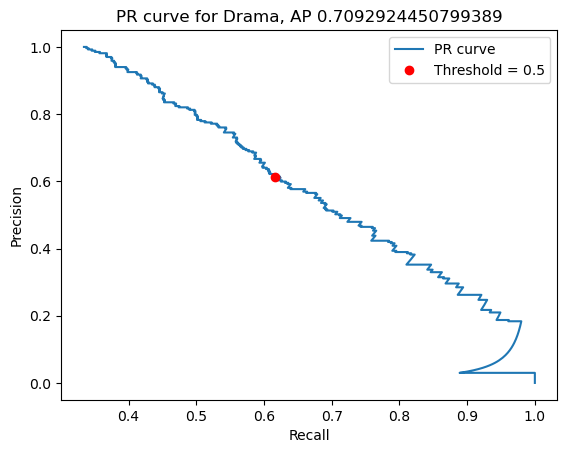

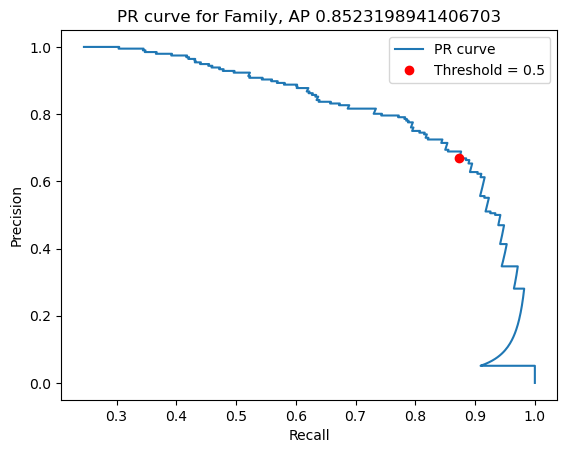

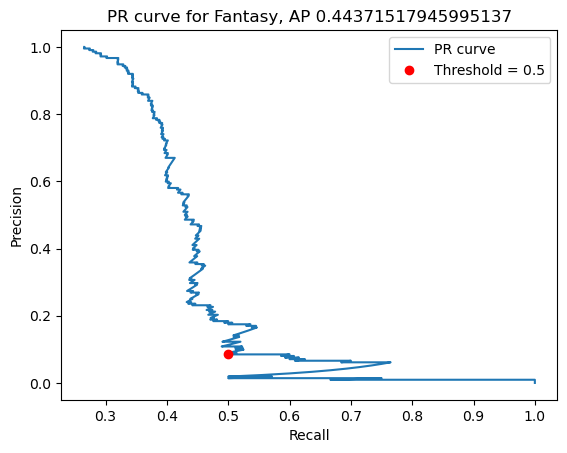

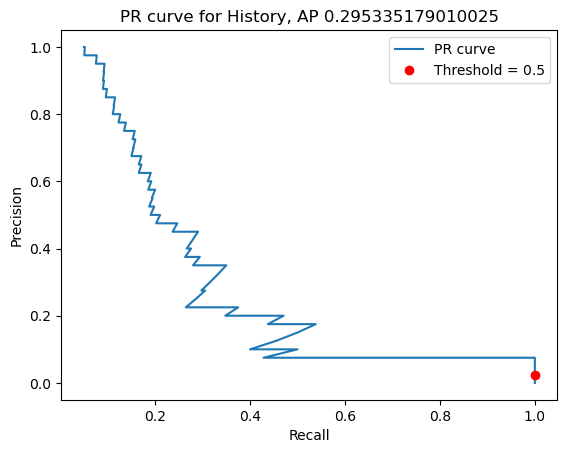

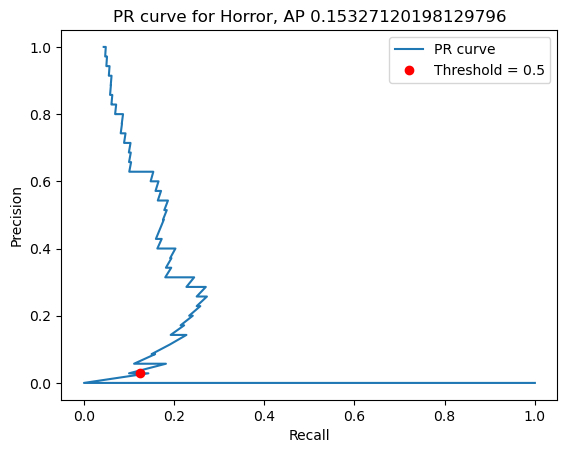

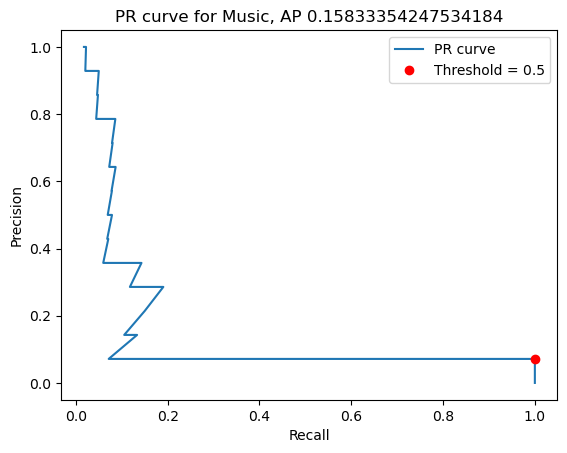

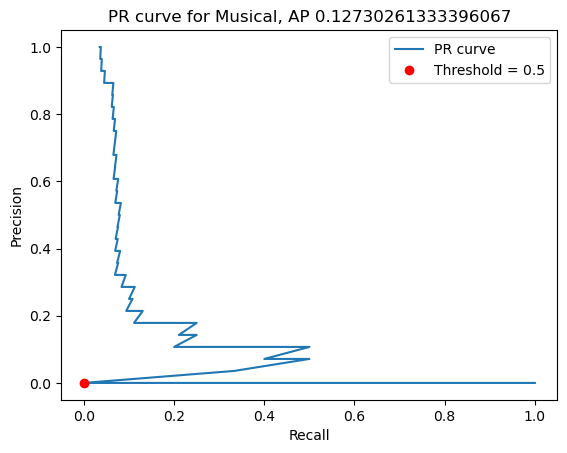

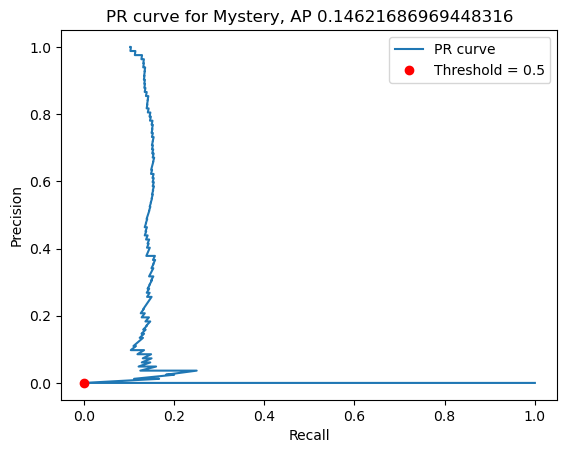

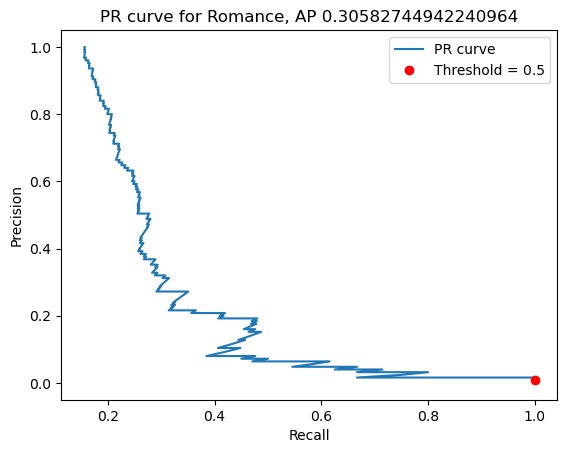

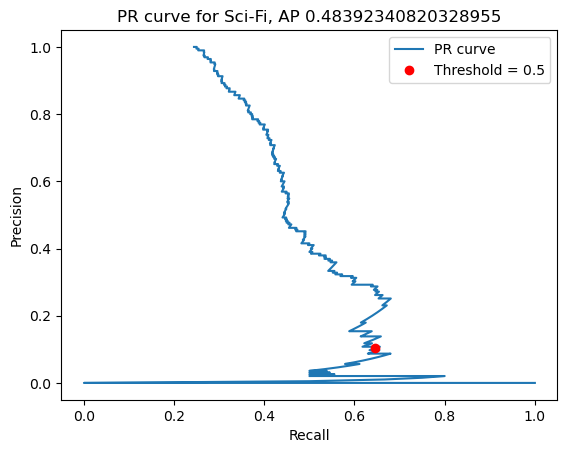

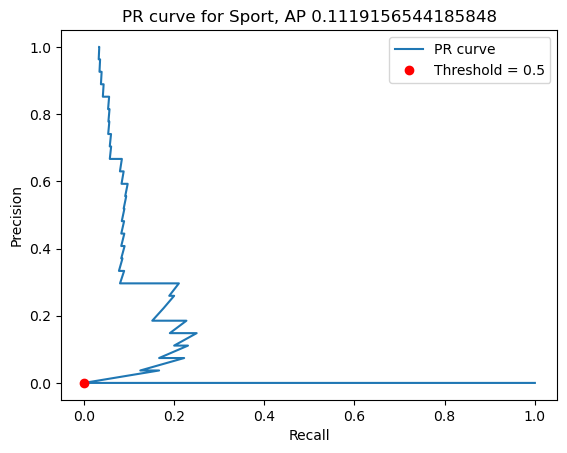

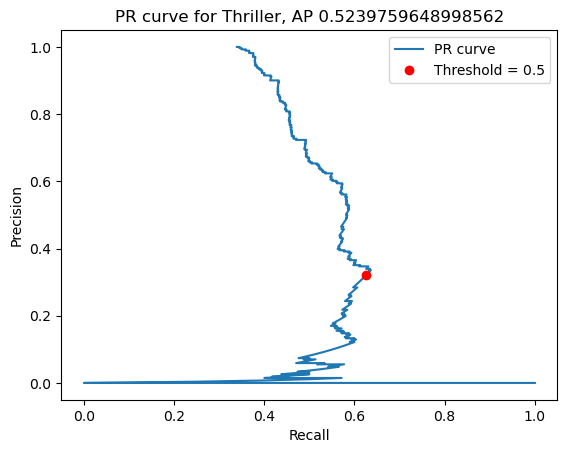

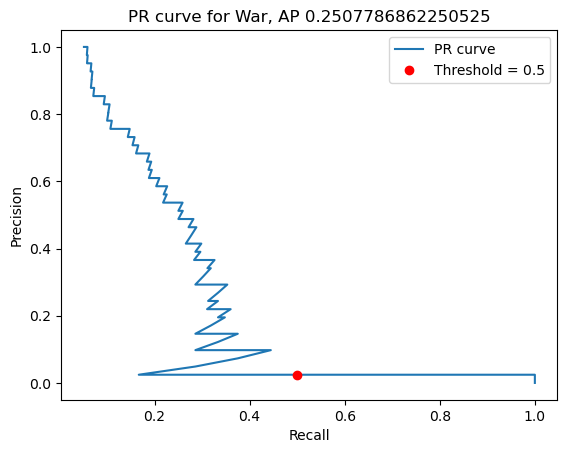

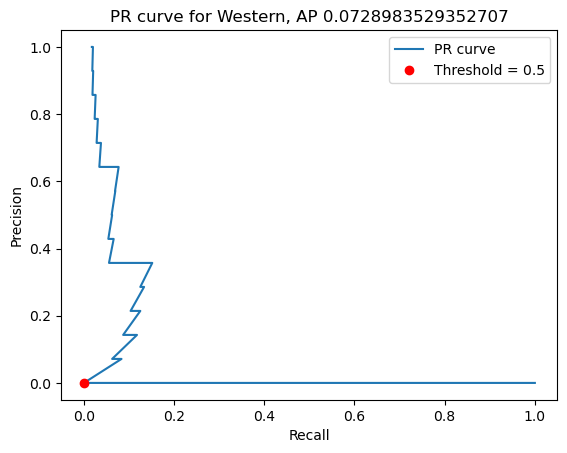

In [80]:
plot_pr_curve(name_genres_new, y_valid, y_scores_pos_class, default_thresh_log_reg)

In [81]:
multilabel_confusion_matrix(y_valid, predict_y)

array([[[307, 101],
        [154, 237]],

       [[350,  84],
        [127, 238]],

       [[664,  16],
        [ 41,  78]],

       [[772,   0],
        [ 27,   0]],

       [[460,  55],
        [101, 183]],

       [[676,   4],
        [116,   3]],

       [[798,   0],
        [  1,   0]],

       [[430, 102],
        [103, 164]],

       [[585,  18],
        [ 65, 131]],

       [[569,  18],
        [194,  18]],

       [[759,   0],
        [ 40,   0]],

       [[758,   6],
        [ 34,   1]],

       [[785,   0],
        [ 14,   0]],

       [[771,   0],
        [ 28,   0]],

       [[717,   0],
        [ 82,   0]],

       [[674,   0],
        [125,   0]],

       [[593,  11],
        [175,  20]],

       [[772,   0],
        [ 27,   0]],

       [[476,  52],
        [184,  87]],

       [[758,   0],
        [ 40,   1]],

       [[785,   0],
        [ 14,   0]]])

### Post-tuning of threshold with cross-validation

In [365]:
def get_pred_cust_threshold(model, X, threshold):
    y_scores = model.predict_proba(X)
    y_scores_pos_class = np.array([scores[:, 1] for scores in y_scores]).T
    y_pred = (y_scores_pos_class >= threshold).astype(int)
    return y_pred

In [367]:
def create_df_threshold_f1(threshold_range, X_train, y_train, model, pred_prob):
    n_split = 2
    f1 = {}
    f1['threshold'] = threshold_range
    m_strat_split = MultilabelStratifiedShuffleSplit(n_splits=n_split, test_size=0.2, random_state=random_state)
    for split_num, (train_index, valid_index) in enumerate(m_strat_split.split(X_train, y_train)):
        X_tr, X_val = X[train_index], X[valid_index]
        y_tr, y_val = y[train_index], y[valid_index]
        model.fit(X_tr, y_tr)
        f1[split_num] = []
        for threshold in threshold_range:
            if pred_prob == True:
                y_pred = get_pred_cust_threshold(model, X_val, threshold)
            else:
                y_pred = get_pred_cust_thresh_dec_func(model, X_val, threshold)
            f1[split_num].append(f1_score(y_val, y_pred, average = 'samples'))
    threshold_f1_df = pd.DataFrame.from_dict(f1)
    threshold_f1_df['f1_sample_mean'] = threshold_f1_df.loc[:,[0,1]].mean(axis = 1)
    return threshold_f1_df

In [369]:
def find_best_threshold(threshold_f1_df, def_thr):  
    def make_vizual_threshold_f1(threshold_f1_df, default_threshold_ind,best_threshold,best_threshold_ind, best_threshold_value, def_thr):
        sns.scatterplot(x = 'threshold', y = 'f1_sample_mean', data = threshold_f1_df, color = 'grey')
        plt.plot(threshold_f1_df.loc[default_threshold_ind, 'threshold'], threshold_f1_df.loc[default_threshold_ind, 'f1_sample_mean'], 'bo', label = f'Default threshold {def_thr}')
        plt.plot(threshold_f1_df.loc[best_threshold_ind, 'threshold'], threshold_f1_df.loc[best_threshold_ind, 'f1_sample_mean'], 'go', label = f'Best threshold: {best_threshold_value:.3f}')
        plt.title('F1_score_samples vs. Threshold')
        plt.ylabel('F1_score_samples')
        plt.grid(True)
        plt.legend()
        plt.show()
        
    default_threshold_ind = np.argmin(np.abs(threshold_f1_df['threshold'] - def_thr))
    best_threshold = threshold_f1_df.loc[threshold_f1_df['f1_sample_mean'] == threshold_f1_df['f1_sample_mean'].max(), 'threshold']
    best_threshold_ind = best_threshold.index[0]
    best_threshold_value = best_threshold.iloc[0]
    make_vizual_threshold_f1(threshold_f1_df, default_threshold_ind,best_threshold,best_threshold_ind, best_threshold_value, def_thr) 
    return best_threshold_value

In [425]:
threshold_f1_df_log_reg = create_df_threshold_f1(np.linspace(0.1, 0.9, 100), X_train, y_train, mod_log_reg, True)

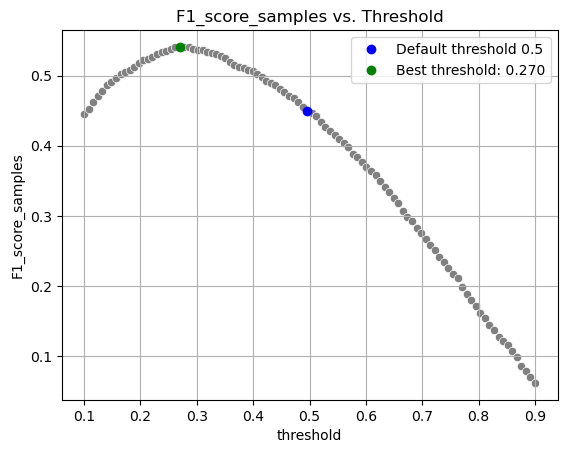

In [426]:
best_threshold_value_log_reg = find_best_threshold(threshold_f1_df_log_reg, default_thresh_log_reg)

#### Check metrics with best threshold

##### Using X_valid y_valid

In [90]:
predict_y_new_thr = (y_scores_pos_class >= best_threshold_value_log_reg).astype(int)

In [429]:
pd.DataFrame.from_dict(classification_report(y_valid, predict_y_new_thr, target_names= name_genres_new, output_dict=True)).T.sort_values(by = 'support')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


precision    recall  f1-score  support
Documentary    0.000000  0.000000  0.000000      1.0
Music          0.000000  0.000000  0.000000     14.0
Western        0.000000  0.000000  0.000000     14.0
Sport          0.000000  0.000000  0.000000     27.0
Biography      0.250000  0.074074  0.114286     27.0
Musical        0.000000  0.000000  0.000000     28.0
Horror         0.157895  0.085714  0.111111     35.0
History        0.347826  0.200000  0.253968     40.0
War            0.375000  0.146341  0.210526     41.0
Mystery        0.166667  0.036585  0.060000     82.0
Crime          0.378378  0.470588  0.419476    119.0
Animation      0.701389  0.848739  0.768061    119.0
Romance        0.318681  0.232000  0.268519    125.0
Sci-Fi         0.444000  0.569231  0.498876    195.0
Family         0.704846  0.816327  0.756501    196.0
Fantasy        0.419244  0.575472  0.485089    212.0
Drama          0.454175  0.835206  0.588391    267.0
Thriller       0.456250  0.808118  0.583222    271.0
Comedy         0.519833  0.876761  0.652687    284.0
Adventure      0.562814  0.920548  0.698545    365.0
Action         0.558600  0.938619  0.700382    391.0
micro avg      0.506474  0.699264  0.587456   2853.0
macro avg      0.324552  0.401634  0.341411   2853.0
weighted avg   0.474430  0.699264  0.554958   2853.0
samples avg    0.512784  0.708214  0.574115   2853.0

##### Using X_test y_test

In [429]:
y_test_pred = get_pred_cust_threshold(mod_log_reg, X_test, best_threshold_value_log_reg)

In [431]:
metrics_test_best_thr_log_reg = pd.DataFrame.from_dict(classification_report(y_test, y_test_pred, target_names= name_genres_new, output_dict=True)).T.sort_values(by = 'support')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [433]:
metrics_test_best_thr_log_reg

precision    recall  f1-score  support
Musical        0.000000  0.000000  0.000000      0.0
Music          0.000000  0.000000  0.000000      1.0
Western        0.000000  0.000000  0.000000      1.0
Documentary    0.000000  0.000000  0.000000      1.0
Sport          0.000000  0.000000  0.000000      3.0
Biography      0.500000  0.200000  0.285714      5.0
Horror         0.333333  0.200000  0.250000      5.0
History        0.500000  0.200000  0.285714      5.0
Mystery        0.000000  0.000000  0.000000      7.0
War            0.000000  0.000000  0.000000      8.0
Crime          0.133333  0.181818  0.153846     11.0
Animation      0.818182  0.818182  0.818182     11.0
Family         0.666667  0.823529  0.736842     17.0
Romance        0.400000  0.235294  0.296296     17.0
Sci-Fi         0.358974  0.636364  0.459016     22.0
Fantasy        0.533333  0.727273  0.615385     22.0
Thriller       0.362069  0.777778  0.494118     27.0
Drama          0.490909  0.794118  0.606742     34.0
Comedy         0.617021  0.828571  0.707317     35.0
Adventure      0.468354  0.902439  0.616667     41.0
Action         0.560976  0.978723  0.713178     47.0
micro avg      0.486842  0.693750  0.572165    320.0
macro avg      0.321102  0.395433  0.335191    320.0
weighted avg   0.464151  0.693750  0.542278    320.0
samples avg    0.481155  0.698480  0.552355    320.0

### Check stability of the model using random state

In [371]:
def metrics_diff_random_state(model, best_threshold_value, pred_prob):
    sample_size_stability = 100
    random.seed(42)
    range_random = range(1, 1001)
    selected_random_states = random.sample(range_random, sample_size_stability)
    rand_state_metrics = {'random_state': [], 'f1_score_mean': [], 'aver_prec_score_mean': []}
    for rand_stat in selected_random_states:
        score={'f1_score': [], 'aver_prec_score': []}
        m_strat_split = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=rand_stat)
        for split_num, (train_index, valid_index) in enumerate(m_strat_split.split(X, y)):
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
            model.fit(X_train, y_train)
            if pred_prob == True:
                y_pred = get_pred_cust_threshold(model, X_valid, best_threshold_value)
            else:
                y_pred = get_pred_cust_thresh_dec_func(model, X_valid, best_threshold_value)
            score['f1_score'].append(f1_score(y_valid, y_pred, average = 'samples'))
            score['aver_prec_score'].append(average_precision_score(y_valid, y_pred, average = 'samples'))
        rand_state_metrics['random_state'].append(rand_stat)
        rand_state_metrics['f1_score_mean'].append(statistics.mean(score['f1_score']))
        rand_state_metrics['aver_prec_score_mean'].append(statistics.mean(score['aver_prec_score']))
    return pd.DataFrame.from_dict(rand_state_metrics)

In [373]:
def create_dic_final_analize_model(df_rand_st_metric):
    dict_analize_model = {}
    dict_analize_model['f1_score_mean'] = df_rand_st_metric['f1_score_mean'].mean()
    dict_analize_model['f1_score_std'] = df_rand_st_metric['f1_score_mean'].std()
    dict_analize_model['aver_prec_score_mean'] = df_rand_st_metric['aver_prec_score_mean'].mean()
    dict_analize_model['aver_prec_score_std'] = df_rand_st_metric['aver_prec_score_mean'].std()
    return dict_analize_model

In [375]:
def visializ_final_anal_model(df_rand_st_metric, final_analize_dic):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    sns.histplot(df_rand_st_metric['f1_score_mean'], kde = True, ax=ax1)
    ax1.axvline(final_analize_dic['f1_score_mean'], color='r', linestyle='--', label = 'Mean')
    ax1.axvline(final_analize_dic['f1_score_mean'] - final_analize_dic['f1_score_std'], color='g', linestyle='--', label = 'std')
    ax1.axvline(final_analize_dic['f1_score_mean'] + final_analize_dic['f1_score_std'], color='g', linestyle='--')
    ax1.legend()
    
    sns.histplot(df_rand_st_metric['aver_prec_score_mean'], kde = True, ax=ax2)
    ax2.axvline(final_analize_dic['aver_prec_score_mean'], color='r', linestyle='--', label = 'Mean')
    ax2.axvline(final_analize_dic['aver_prec_score_mean'] - final_analize_dic['aver_prec_score_std'], color='g', linestyle='--', label = 'std')
    ax2.axvline(final_analize_dic['aver_prec_score_mean'] + final_analize_dic['aver_prec_score_std'], color='g', linestyle='--')
    ax2.legend()

In [433]:
log_reg_rand_state_metrics_df = metrics_diff_random_state(mod_log_reg, best_threshold_value_log_reg, True)

In [441]:
log_reg_rand_state_metrics_df

random_state  f1_score_mean  aver_prec_score_mean
0            655       0.505030              0.390243
1            115       0.511040              0.398628
2             26       0.513174              0.397046
3            760       0.512215              0.394965
4            282       0.509251              0.394122
..           ...            ...                   ...
95           167       0.515881              0.401094
96           380       0.512658              0.398231
97           364       0.517074              0.400492
98           215       0.513410              0.396209
99           687       0.509929              0.393009

[100 rows x 3 columns]

In [443]:
log_reg_final_analize_dic = create_dic_final_analize_model(log_reg_rand_state_metrics_df)

In [445]:
log_reg_final_analize_dic

{'f1_score_mean': 0.5128233699195652,
 'f1_score_std': 0.00491075620164218,
 'aver_prec_score_mean': 0.3979132800521807,
 'aver_prec_score_std': 0.004725102506951689}

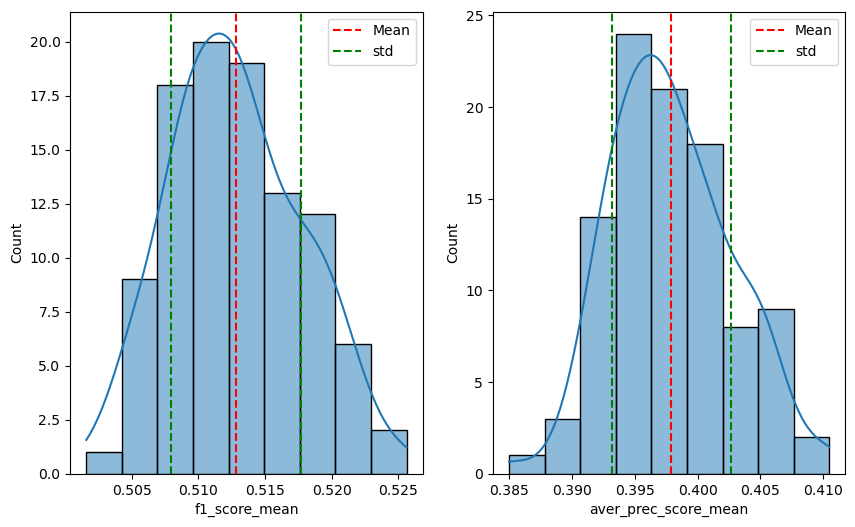

In [296]:
visializ_final_anal_model(log_reg_rand_state_metrics_df, log_reg_final_analize_dic)

## Linear SVC

### Tuning hyperparametres

In [102]:
model_svc_tune_hyper = MultiOutputClassifier(LinearSVC(random_state = random_state))

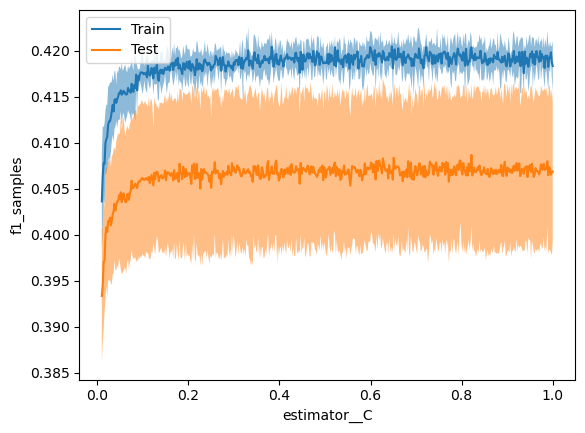

In [104]:
ValidationCurveDisplay.from_estimator(model_svc_tune_hyper, 
                                      X = X_train, 
                                      y = y_train, 
                                      param_name='estimator__C',
                                      param_range = np.linspace(0.01, 1, 500), 
                                      scoring = 'f1_samples', 
                                      score_name = 'f1_samples', 
                                      cv = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=42), n_jobs = -1)

In [106]:
space_lin_scv = {
    'C': hp.loguniform('C', np.log(0.01), np.log(1))
}

In [108]:
dict_tun_hyper_svc = tune_hyperpar_anneal(LinearSVC, space_lin_scv, X_train, y_train, 'f1_samples')

100%|██████| 100/100 [00:33<00:00,  2.98trial/s, best loss: -0.4082511414420804]


In [110]:
best = dict_tun_hyper_svc['best']

In [112]:
best

{'C': 0.5582857303397724}

### Fit the model

In [447]:
mod_lin_svc = MultiOutputClassifier(LinearSVC(random_state = random_state, C = 0.01999999))

In [449]:
mod_lin_svc.fit(X_train, y_train)

MultiOutputClassifier(estimator=LinearSVC(C=0.01999999, random_state=42))

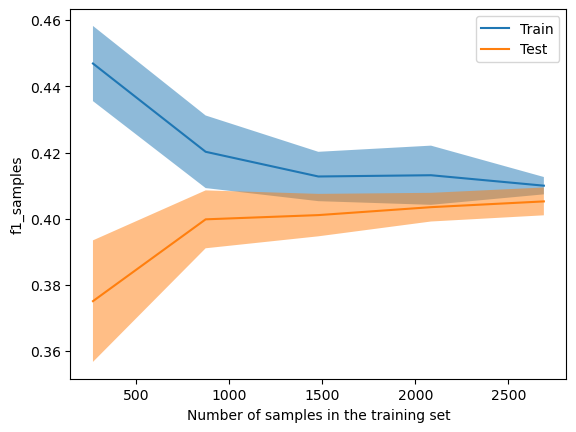

In [119]:
LearningCurveDisplay.from_estimator(mod_lin_svc, 
                                    X = X_train, 
                                    y = y_train,  
                                    scoring = 'f1_samples', 
                                    score_name = 'f1_samples', 
                                    cv = MultilabelStratifiedKFold(n_splits=4, shuffle=True, random_state=42), 
                                    shuffle=True, random_state=42, n_jobs = -1)

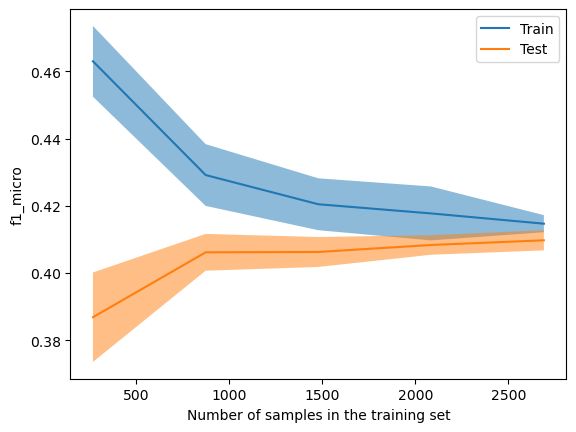

In [120]:
LearningCurveDisplay.from_estimator(mod_lin_svc, 
                                    X = X_train, 
                                    y = y_train,  
                                    scoring = 'f1_micro', 
                                    score_name = 'f1_micro', 
                                    cv = MultilabelStratifiedKFold(n_splits=4, shuffle=True, random_state=42), 
                                    shuffle=True, random_state=42, n_jobs = -1)

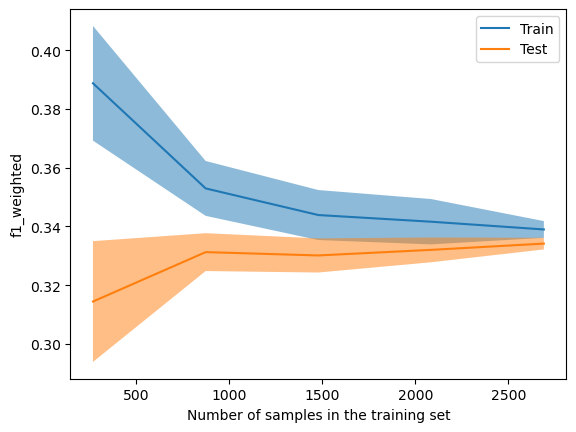

In [123]:
LearningCurveDisplay.from_estimator(mod_lin_svc, 
                                    X = X_train, 
                                    y = y_train,  
                                    scoring = 'f1_weighted', 
                                    score_name = 'f1_weighted', 
                                    cv = MultilabelStratifiedKFold(n_splits=4, shuffle=True, random_state=42), 
                                    shuffle=True, random_state=42, n_jobs = -1)

In [124]:
predict_y = mod_lin_svc.predict(X_valid)

In [125]:
metrics_svc = pd.DataFrame.from_dict(classification_report(y_valid, predict_y, target_names= name_genres_new, output_dict=True)).T.sort_values(by = 'support')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [129]:
metrics_svc

precision    recall  f1-score  support
Documentary    0.000000  0.000000  0.000000      1.0
Music          0.000000  0.000000  0.000000     14.0
Western        0.000000  0.000000  0.000000     14.0
Sport          0.000000  0.000000  0.000000     27.0
Biography      0.000000  0.000000  0.000000     27.0
Musical        0.000000  0.000000  0.000000     28.0
Horror         0.000000  0.000000  0.000000     35.0
History        0.000000  0.000000  0.000000     40.0
War            0.000000  0.000000  0.000000     41.0
Mystery        0.000000  0.000000  0.000000     82.0
Crime          0.000000  0.000000  0.000000    119.0
Animation      0.842697  0.630252  0.721154    119.0
Romance        0.000000  0.000000  0.000000    125.0
Sci-Fi         0.000000  0.000000  0.000000    195.0
Family         0.902256  0.612245  0.729483    196.0
Fantasy        0.000000  0.000000  0.000000    212.0
Drama          0.619772  0.610487  0.615094    267.0
Thriller       0.563107  0.214022  0.310160    271.0
Comedy         0.762500  0.644366  0.698473    284.0
Adventure      0.774704  0.536986  0.634304    365.0
Action         0.734007  0.557545  0.633721    391.0
micro avg      0.731936  0.355065  0.478169   2853.0
macro avg      0.247573  0.181233  0.206780   2853.0
weighted avg   0.484233  0.355065  0.404750   2853.0
samples avg    0.643471  0.360486  0.436756   2853.0

### Explore default threshold (0.5)

In [457]:
y_score_dec_func_lin_svc = np.column_stack([
    estimator.decision_function(X_valid) 
    for estimator in mod_lin_svc.estimators_
])

In [459]:
y_score_dec_func_lin_svc

array([[-0.20406442,  0.41010136, -1.42282138, ..., -0.77989552,
        -0.82512021, -1.00699737],
       [ 0.29566963,  0.19733904, -1.97667592, ..., -0.21933479,
        -0.76332956, -0.89810101],
       [ 0.10592853,  0.42758567, -1.6002033 , ..., -0.23273929,
        -0.66852237, -0.97510038],
       ...,
       [-0.62599728, -0.22243885, -0.19143568, ..., -0.80154014,
        -1.14892458, -1.04668531],
       [-0.36046111, -0.4580229 , -2.21168589, ..., -0.30953254,
        -0.98894925, -0.93095924],
       [-0.26391912, -0.50103803, -1.9078938 , ..., -0.04935778,
        -0.85623978, -0.91638471]])

In [136]:
y_score_dec_func_lin_svc.shape

(799, 21)

In [471]:
default_thresh_lin_svc = 0

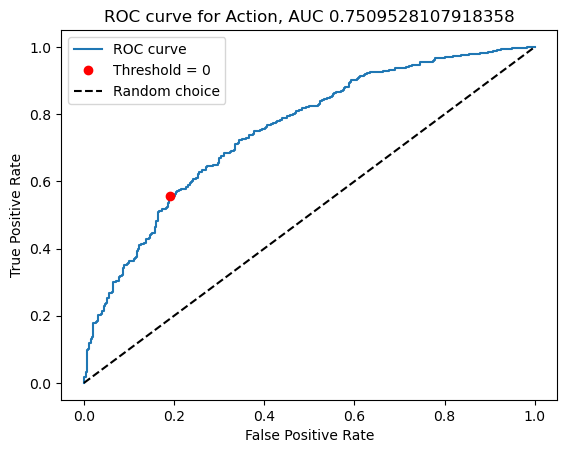

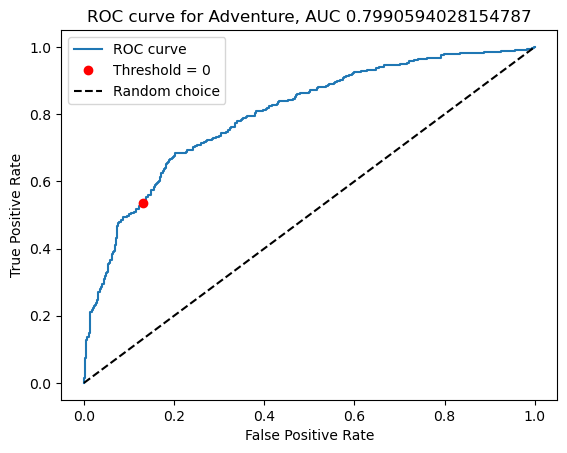

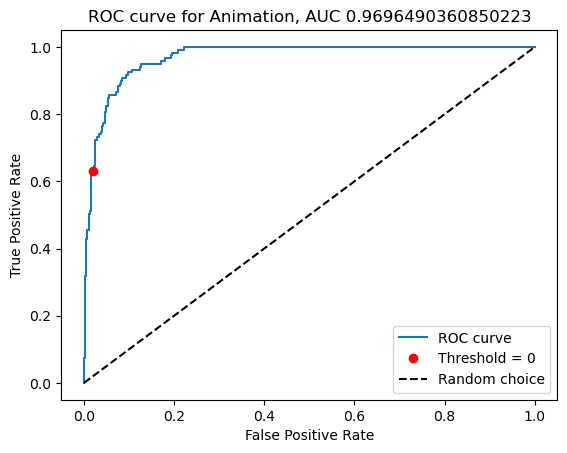

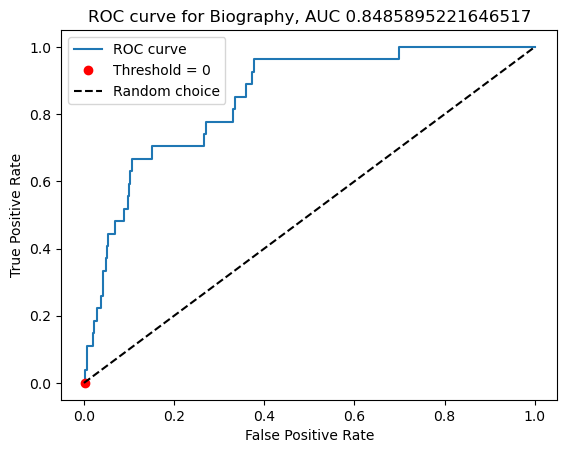

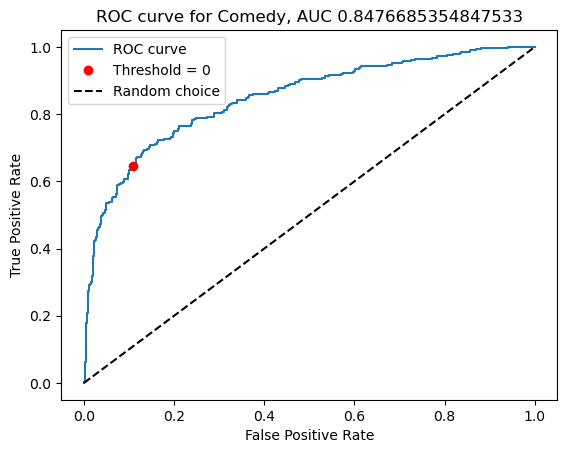

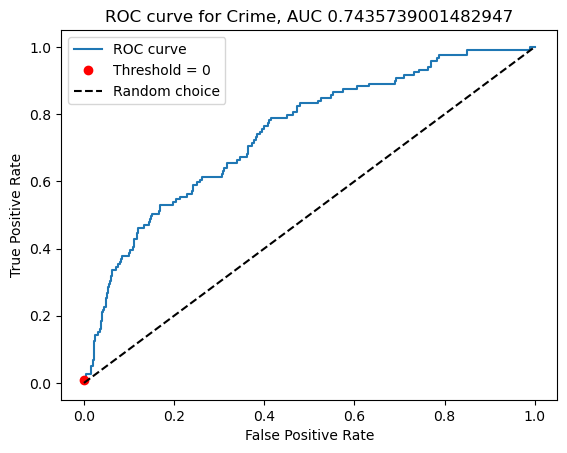

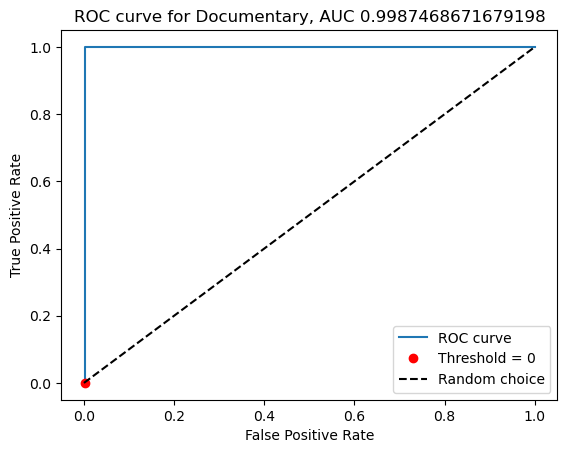

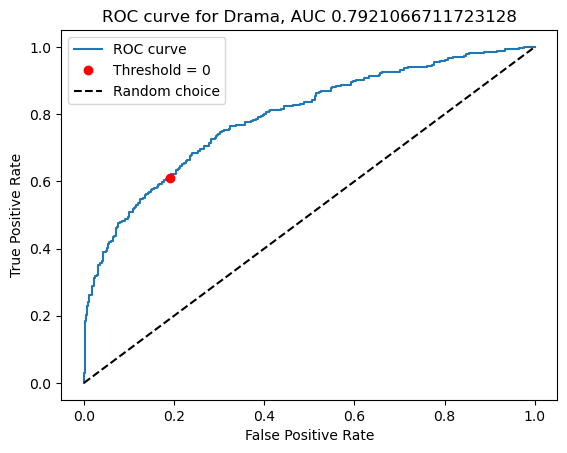

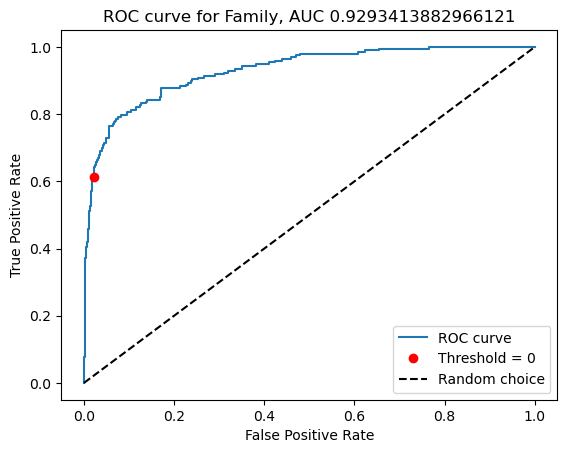

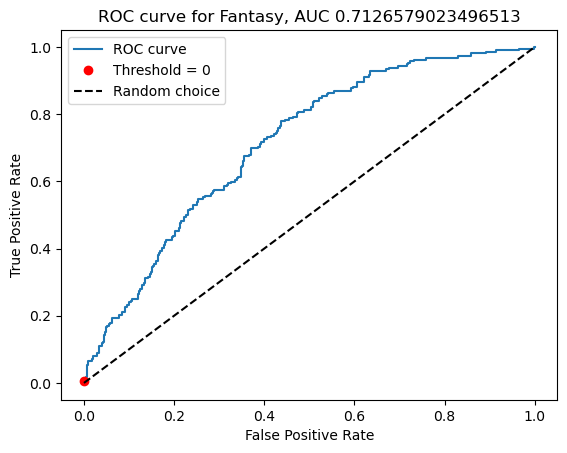

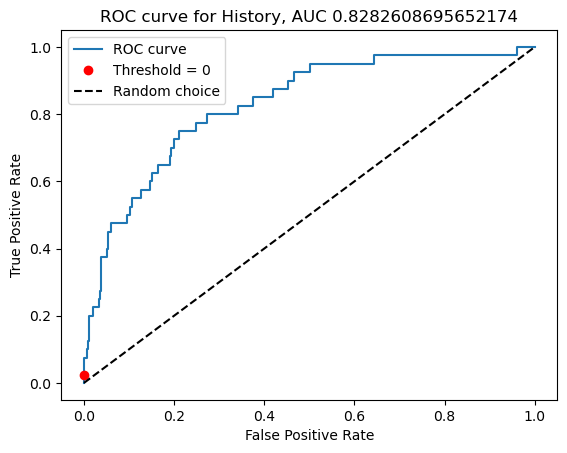

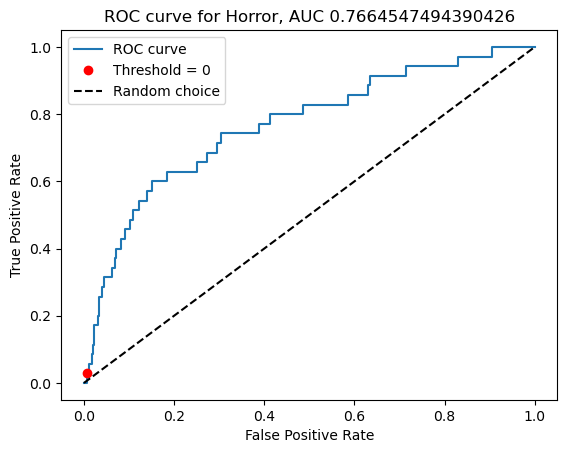

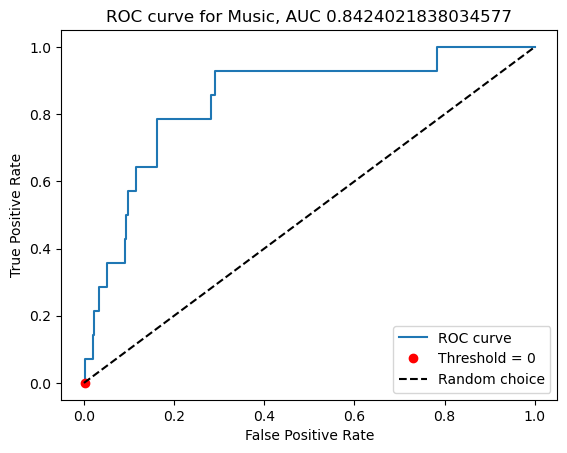

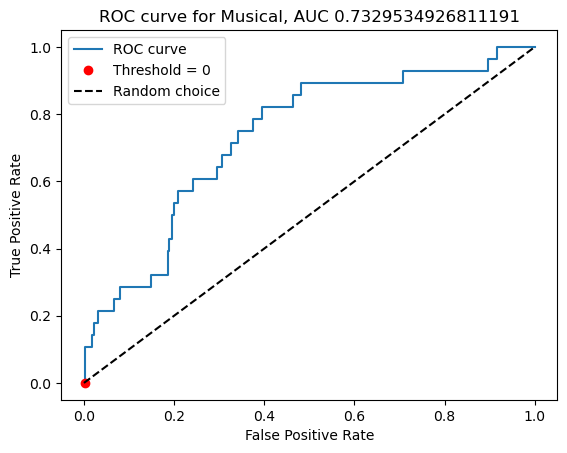

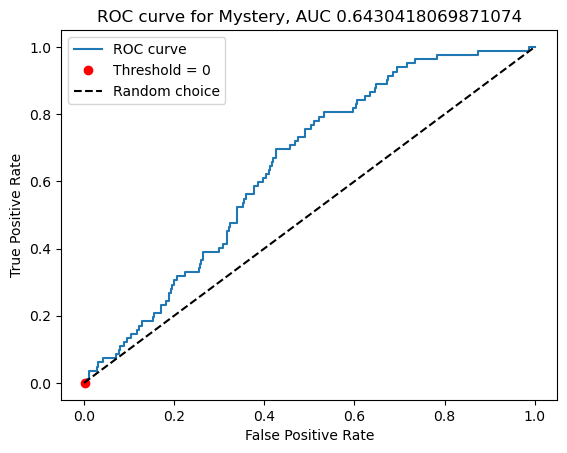

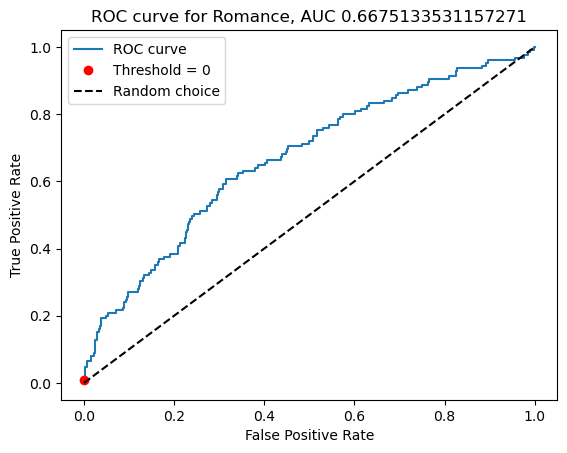

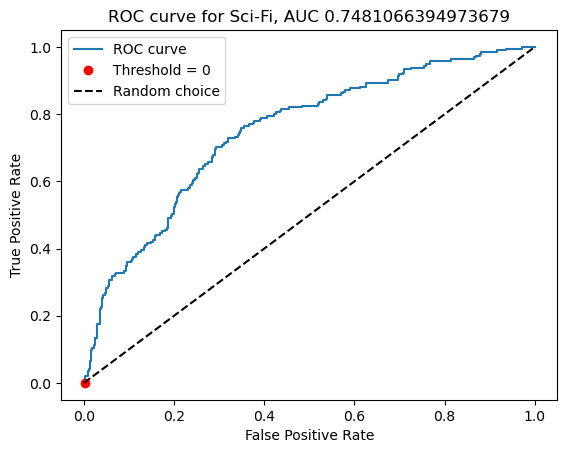

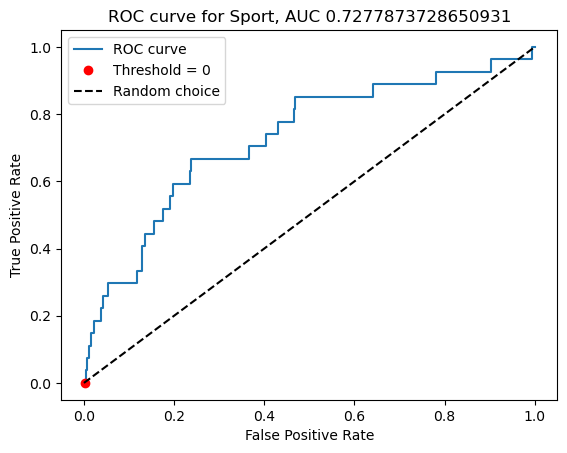

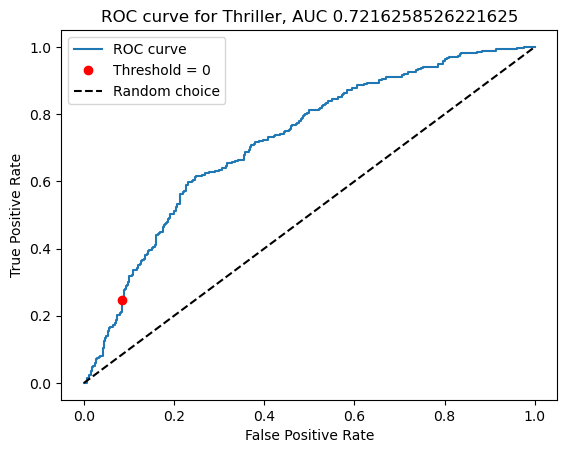

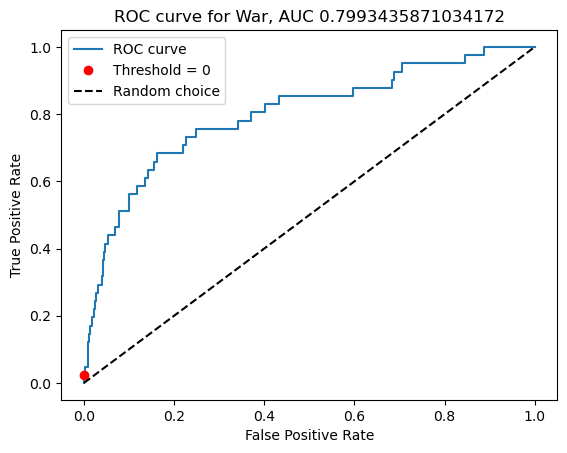

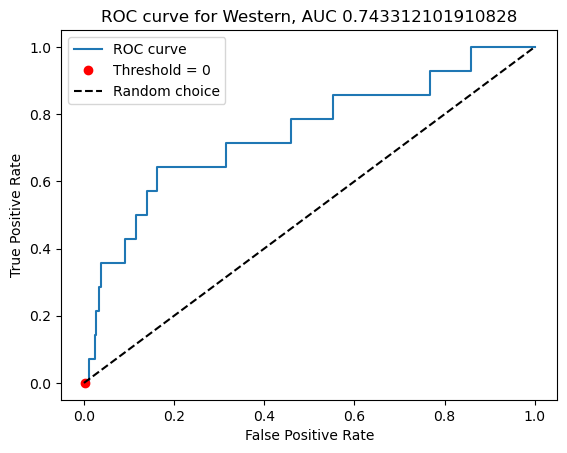

In [140]:
plot_roc(name_genres_new, y_valid, y_score_dec_func_lin_svc, default_thresh_lin_svc)

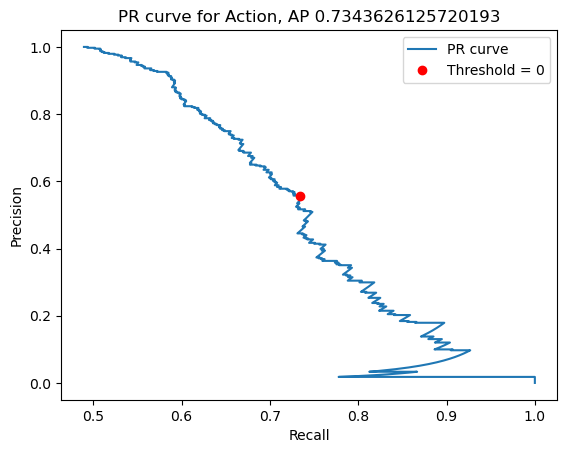

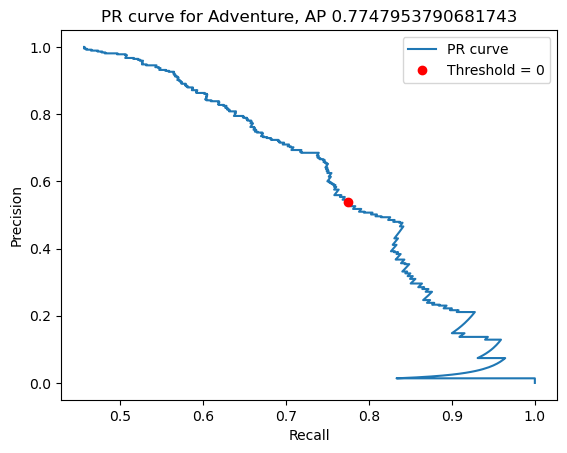

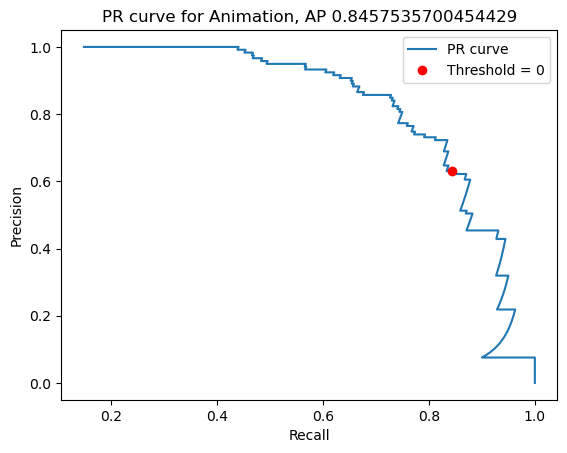

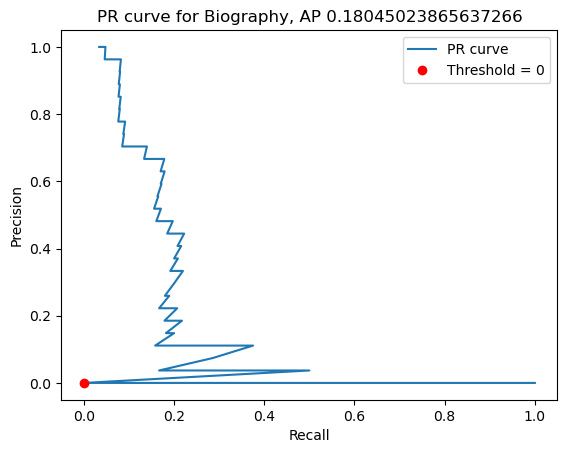

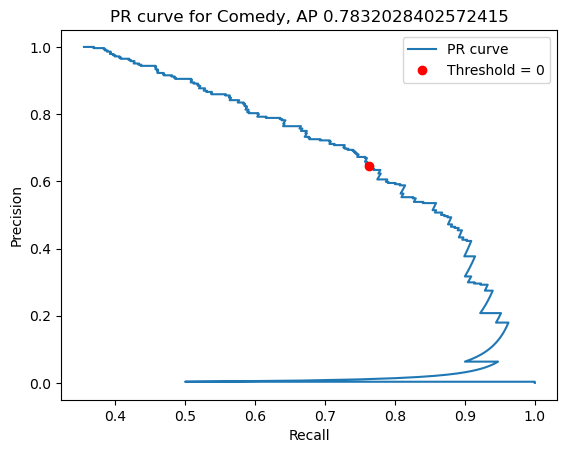

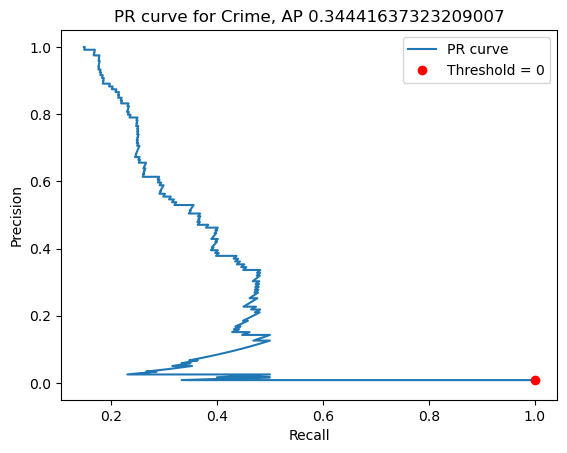

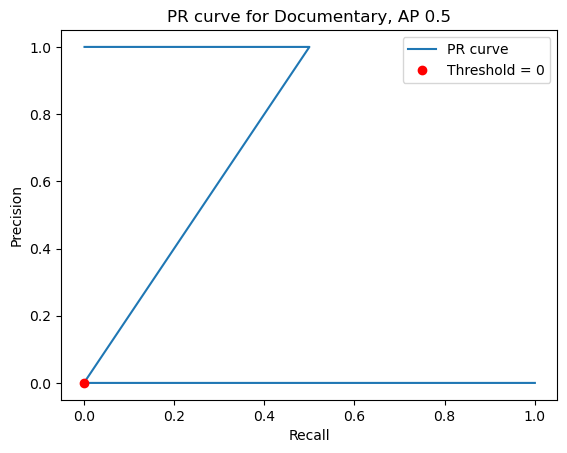

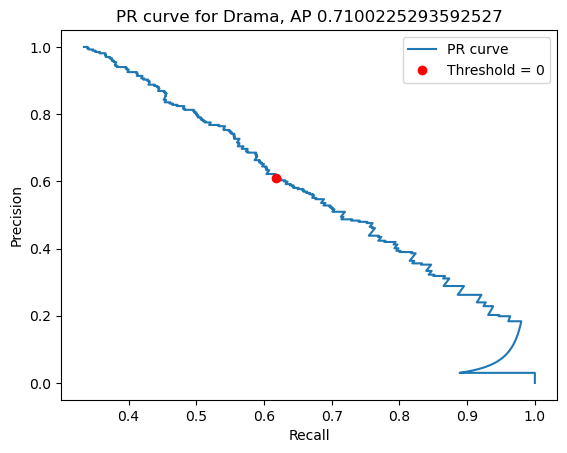

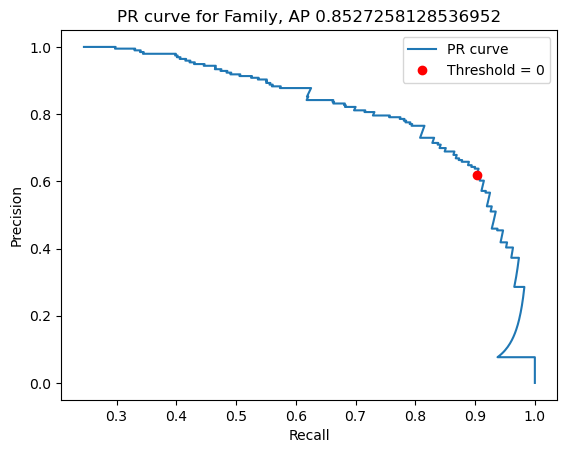

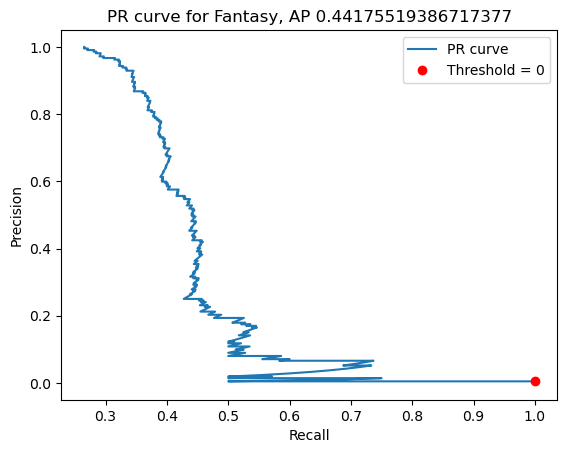

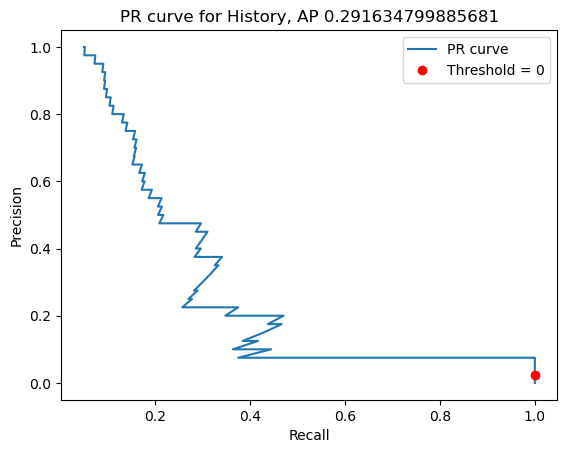

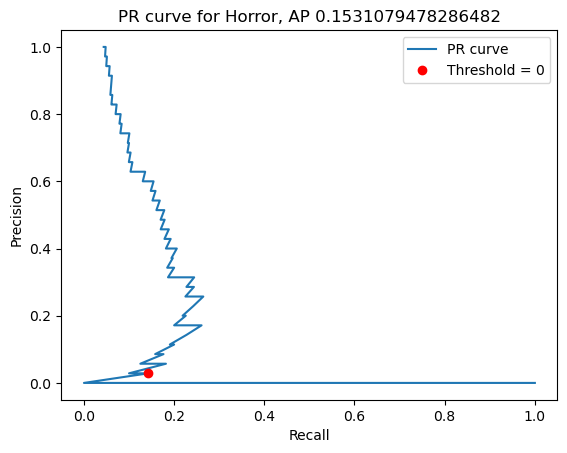

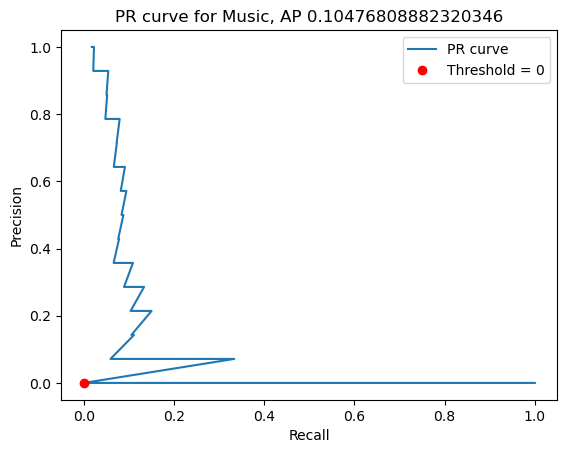

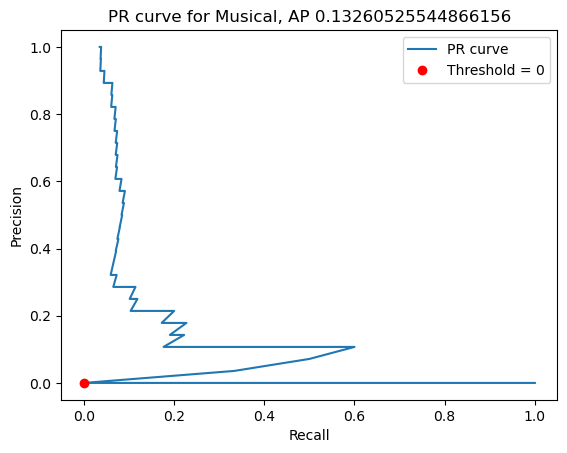

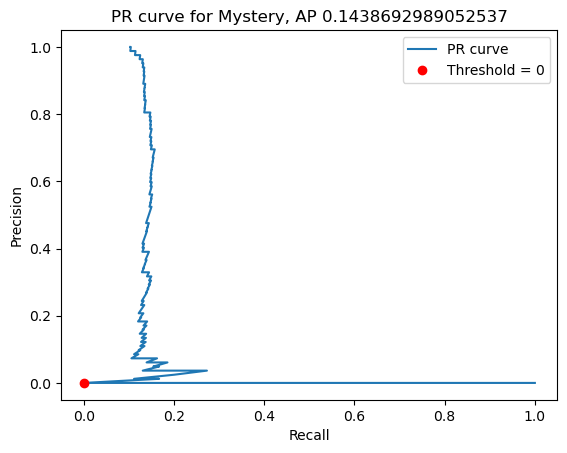

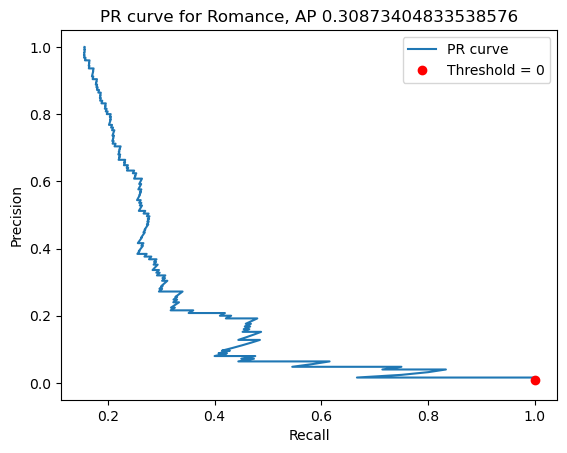

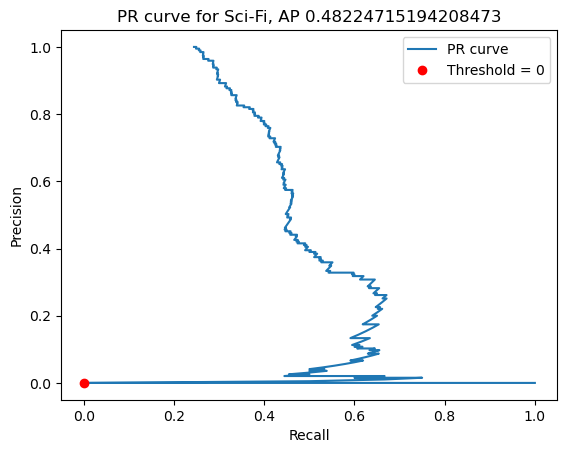

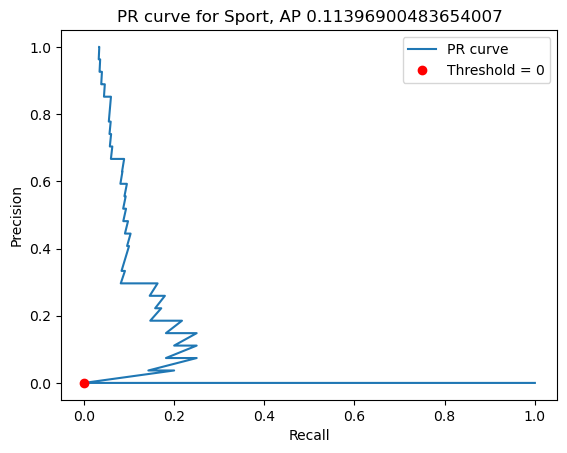

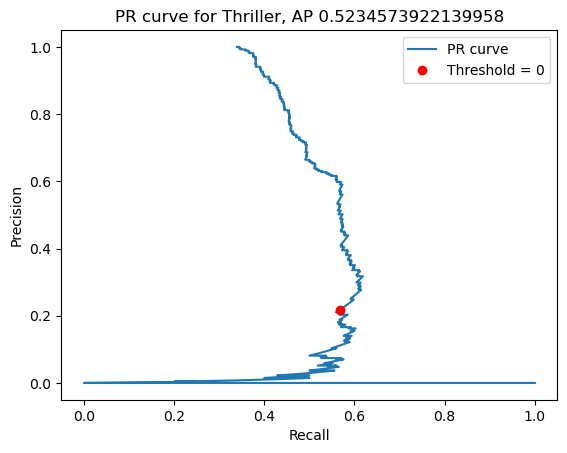

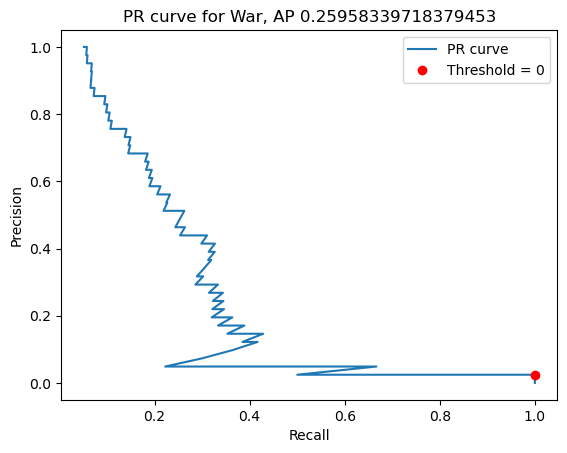

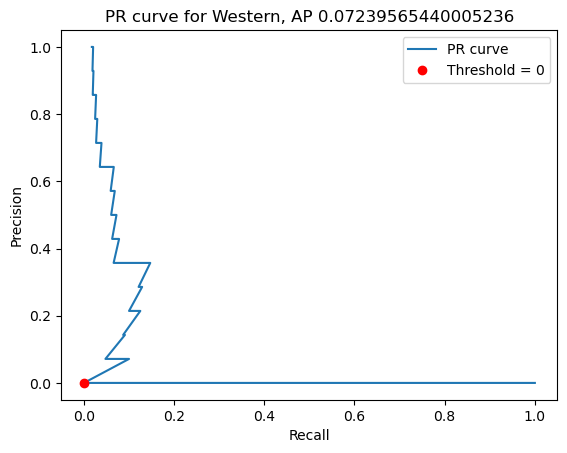

In [141]:
plot_pr_curve(name_genres_new, y_valid, y_score_dec_func_lin_svc, default_thresh_lin_svc)

### Post-tuning of threshold with cross-validation

In [451]:
def get_pred_cust_thresh_dec_func(model, X, threshold):
    y_score_dec_func_lin_svc = np.column_stack([estimator.decision_function(X) for estimator in model.estimators_])
    y_pred = (y_score_dec_func_lin_svc >= threshold).astype(int)
    return y_pred

In [453]:
def find_range_threshold(len_genr, y_valid, y_score_pred):
    min_lst = []
    max_lst = []
    for i in range(len_genr):
        roc_res = roc_curve(y_valid[:, i], y_score_pred[:, i])
        thresh = roc_res[2]
        thresh_clean = [x for x in thresh if x not in (float('inf'), -float('inf'))]
        min_lst.append(np.min(thresh_clean))
        max_lst.append(np.max(thresh_clean))
    return {'min': np.min(min_lst), 'max': np.max(max_lst)}

In [461]:
dic_min_max_thr_lin_svc = find_range_threshold(len(name_genres_new), y_valid, y_score_dec_func_lin_svc)

In [463]:
dic_min_max_thr_lin_svc

{'min': -3.744643936270151, 'max': 1.5348372372289294}

In [465]:
range_thresh_lin_scv = np.linspace(dic_min_max_thr_lin_svc['min'], dic_min_max_thr_lin_svc['max'], 100)

In [467]:
threshold_f1_df_lin_svc = create_df_threshold_f1(range_thresh_lin_scv, X_train, y_train, mod_lin_svc, False)

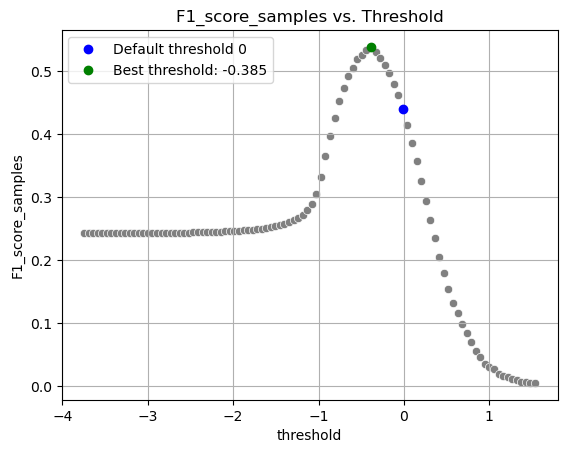

In [473]:
best_threshold_value_lin_svc = find_best_threshold(threshold_f1_df_lin_svc, default_thresh_lin_svc)

#### Check metrics with best threshold

##### Using X_valid y_valid

In [161]:
predict_y_new_thr_svc = (y_score_dec_func_lin_svc >= best_threshold_value_lin_svc).astype(int)

In [423]:
pd.DataFrame.from_dict(classification_report(y_valid, predict_y_new_thr_svc, target_names= name_genres_new, output_dict=True)).T.sort_values(by = 'support')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


precision    recall  f1-score  support
Documentary    0.000000  0.000000  0.000000      1.0
Music          0.000000  0.000000  0.000000     14.0
Western        0.000000  0.000000  0.000000     14.0
Sport          0.000000  0.000000  0.000000     27.0
Biography      0.000000  0.000000  0.000000     27.0
Musical        0.000000  0.000000  0.000000     28.0
Horror         0.260870  0.171429  0.206897     35.0
History        1.000000  0.025000  0.048780     40.0
War            1.000000  0.024390  0.047619     41.0
Mystery        0.000000  0.000000  0.000000     82.0
Crime          0.420561  0.378151  0.398230    119.0
Animation      0.684564  0.857143  0.761194    119.0
Romance        0.444444  0.128000  0.198758    125.0
Sci-Fi         0.546218  0.333333  0.414013    195.0
Family         0.688034  0.821429  0.748837    196.0
Fantasy        0.443787  0.353774  0.393701    212.0
Drama          0.456967  0.835206  0.590728    267.0
Thriller       0.454545  0.774908  0.572988    271.0
Comedy         0.525316  0.876761  0.656992    284.0
Adventure      0.555556  0.931507  0.696008    365.0
Action         0.556732  0.941176  0.699620    391.0
micro avg      0.526584  0.652646  0.582877   2853.0
macro avg      0.382743  0.354867  0.306398   2853.0
weighted avg   0.500346  0.652646  0.530009   2853.0
samples avg    0.530176  0.659338  0.567080   2853.0

##### Using X_test y_test

In [475]:
y_test_pred_lin_svc = get_pred_cust_thresh_dec_func(mod_lin_svc, X_test, best_threshold_value_lin_svc)

In [477]:
metrics_test_best_thr_lin_svc = pd.DataFrame.from_dict(classification_report(y_test, y_test_pred_lin_svc, target_names= name_genres_new, output_dict=True)).T.sort_values(by = 'support')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [479]:
metrics_test_best_thr_lin_svc

precision    recall  f1-score  support
Musical        0.000000  0.000000  0.000000      0.0
Music          0.000000  0.000000  0.000000      1.0
Western        0.000000  0.000000  0.000000      1.0
Documentary    0.000000  0.000000  0.000000      1.0
Sport          0.000000  0.000000  0.000000      3.0
Biography      0.000000  0.000000  0.000000      5.0
Horror         0.333333  0.200000  0.250000      5.0
History        0.000000  0.000000  0.000000      5.0
Mystery        0.000000  0.000000  0.000000      7.0
War            0.000000  0.000000  0.000000      8.0
Crime          0.153846  0.181818  0.166667     11.0
Animation      0.625000  0.909091  0.740741     11.0
Family         0.636364  0.823529  0.717949     17.0
Romance        0.500000  0.117647  0.190476     17.0
Sci-Fi         0.387097  0.545455  0.452830     22.0
Fantasy        0.608696  0.636364  0.622222     22.0
Thriller       0.357143  0.740741  0.481928     27.0
Drama          0.490909  0.794118  0.606742     34.0
Comedy         0.604167  0.828571  0.698795     35.0
Adventure      0.462500  0.902439  0.611570     41.0
Action         0.547619  0.978723  0.702290     47.0
micro avg      0.491954  0.668750  0.566887    320.0
macro avg      0.271746  0.364690  0.297248    320.0
weighted avg   0.448874  0.668750  0.520334    320.0
samples avg    0.485664  0.668338  0.544978    320.0

### Check stability of the model using random state

In [481]:
lin_svc_rand_state_metrics_df = metrics_diff_random_state(mod_lin_svc, best_threshold_value_lin_svc, False)

In [482]:
lin_svc_rand_state_metrics_df

random_state  f1_score_mean  aver_prec_score_mean
0            655       0.502636              0.392536
1            115       0.508715              0.402774
2             26       0.512665              0.403563
3            760       0.513157              0.403703
4            282       0.510025              0.402362
..           ...            ...                   ...
95           167       0.517409              0.409574
96           380       0.512922              0.404426
97           364       0.514468              0.404889
98           215       0.510313              0.398806
99           687       0.509786              0.399920

[100 rows x 3 columns]

In [483]:
lin_svc_final_analize_dic = create_dic_final_analize_model(lin_svc_rand_state_metrics_df)

In [484]:
lin_svc_final_analize_dic

{'f1_score_mean': 0.510921453319838,
 'f1_score_std': 0.004473461830302227,
 'aver_prec_score_mean': 0.4023936083428509,
 'aver_prec_score_std': 0.004421380705278982}

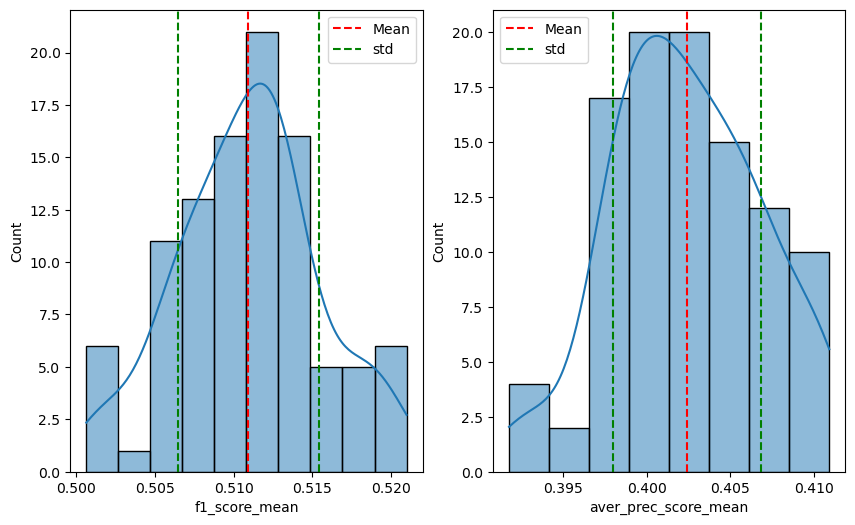

In [175]:
visializ_final_anal_model(lin_svc_rand_state_metrics_df, lin_svc_final_analize_dic)

## Naive Bayes

### Split categorical (binary) and continuous features

In [489]:
categ_feat = ['color', 'language' ,'country', 'aspect_ratio', 'content_rating_high_gross', 'war_symb_title_low_gross', 'facenumber_in_poster_low_gross']

In [491]:
ind_cat = [X_df.columns.get_loc(col) for col in categ_feat]

In [493]:
ind_cat

[0, 10, 11, 16, 18, 19, 20]

In [495]:
X_train.shape

(3615, 21)

In [497]:
X_train_cat = X_train[:, ind_cat]

In [499]:
X_valid_cat = X_valid[:, ind_cat]

In [501]:
X_test_cat = X_test[:, ind_cat]

In [503]:
all_ind = set(range(X_df.shape[1]))

In [505]:
all_ind

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

In [507]:
ind_cont_feat = list(all_ind - set(ind_cat))

In [509]:
X_train_cont_feat = X_train[:, ind_cont_feat]

In [511]:
X_valid_cont_feat = X_valid[:, ind_cont_feat]

In [535]:
X_test_cont_feat = X_test[:, ind_cont_feat]

### BernoulliNB

#### Tuning hyperparametres

In [209]:
mod_BernoulliNB_tun_hyperpar = MultiOutputClassifier(BernoulliNB(fit_prior = False))

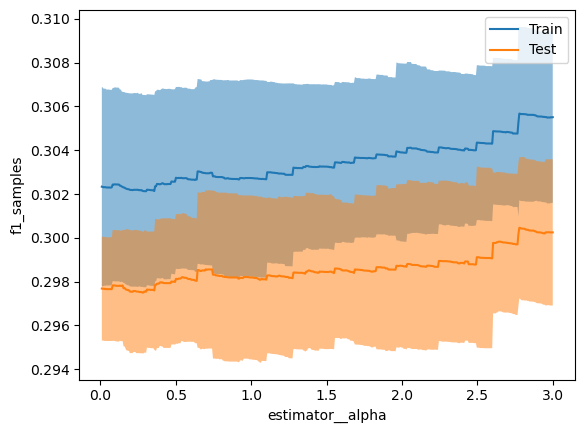

In [211]:
ValidationCurveDisplay.from_estimator(mod_BernoulliNB_tun_hyperpar, 
                                      X = X_train_cat, 
                                      y = y_train, 
                                      param_name='estimator__alpha',
                                      param_range = np.linspace(0.01, 3, 500), 
                                      scoring = 'f1_samples', 
                                      score_name = 'f1_samples', 
                                      cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=4), n_jobs = -1)

#### Fit the model

In [513]:
mod_BernoulliNB = MultiOutputClassifier(BernoulliNB(alpha = 0.8, fit_prior = False))

In [515]:
mod_BernoulliNB.fit(X_train_cat, y_train)

MultiOutputClassifier(estimator=BernoulliNB(alpha=0.8, fit_prior=False))

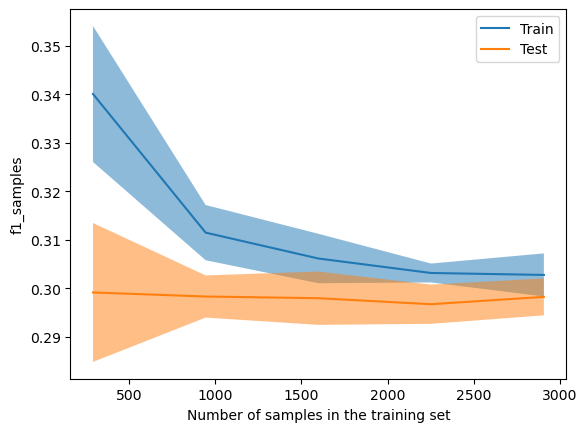

In [218]:
LearningCurveDisplay.from_estimator(mod_BernoulliNB, 
                                    X = X_train_cat, 
                                    y = y_train,  
                                    scoring = 'f1_samples', 
                                    score_name = 'f1_samples', 
                                    cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=4), 
                                    shuffle=True, random_state=4, n_jobs = -1)

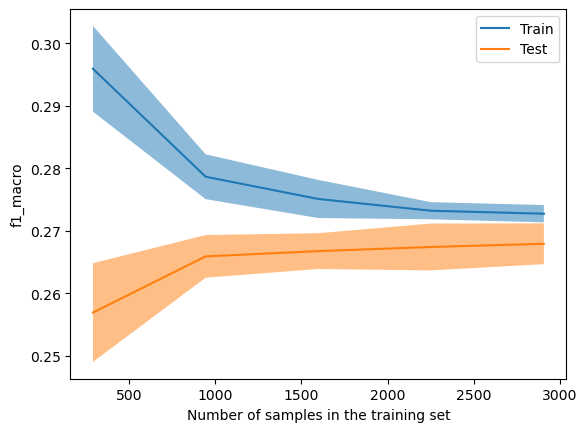

In [220]:
LearningCurveDisplay.from_estimator(mod_BernoulliNB, 
                                    X = X_train_cat, 
                                    y = y_train,  
                                    scoring = 'f1_macro', 
                                    score_name = 'f1_macro', 
                                    cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=4), 
                                    shuffle=True, random_state=4, n_jobs = -1)

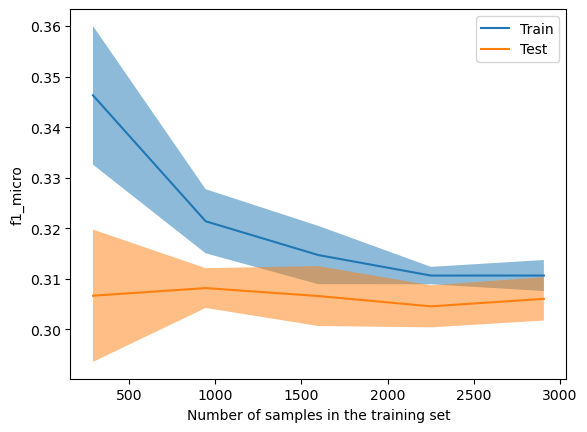

In [222]:
LearningCurveDisplay.from_estimator(mod_BernoulliNB, 
                                    X = X_train_cat, 
                                    y = y_train,  
                                    scoring = 'f1_micro', 
                                    score_name = 'f1_micro', 
                                    cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=4), 
                                    shuffle=True, random_state=4, n_jobs = -1)

### GaussianNB

#### tuning hyperparametres

In [804]:
mod_GaussianNB_tun_hyperpar = MultiOutputClassifier(GaussianNB())

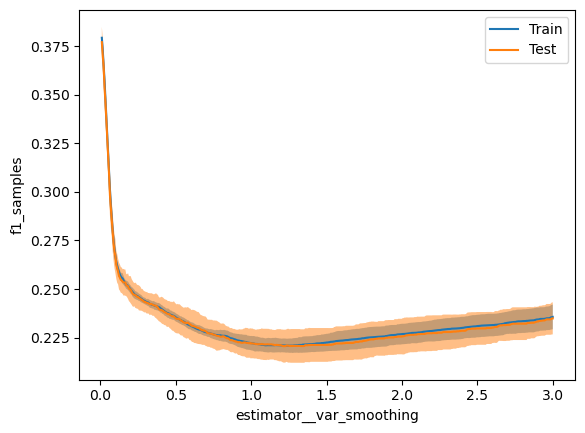

In [808]:
ValidationCurveDisplay.from_estimator(mod_GaussianNB_tun_hyperpar, 
                                      X = X_train_cont_feat, 
                                      y = y_train, 
                                      param_name='estimator__var_smoothing',
                                      param_range = np.linspace(0.01, 3, 500), 
                                      scoring = 'f1_samples', 
                                      score_name = 'f1_samples', 
                                      cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs = -1)

#### Fit the model

In [517]:
mod_GaussianNB = MultiOutputClassifier(GaussianNB())

In [519]:
mod_GaussianNB.fit(X_train_cont_feat, y_train)

MultiOutputClassifier(estimator=GaussianNB())

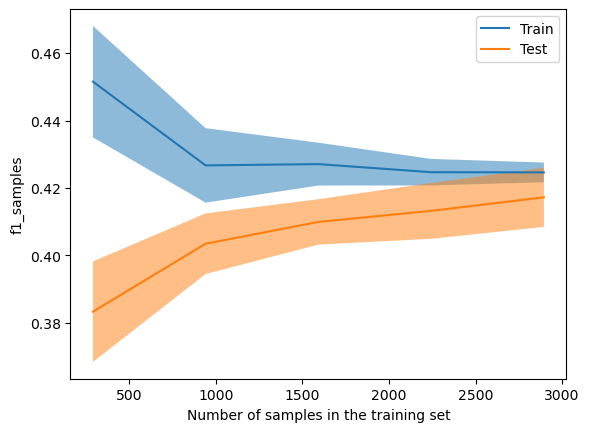

In [228]:
LearningCurveDisplay.from_estimator(mod_GaussianNB, 
                                    X = X_train_cont_feat, 
                                    y = y_train,  
                                    scoring = 'f1_samples', 
                                    score_name = 'f1_samples', 
                                    cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                    shuffle=True, random_state=42, n_jobs = -1)

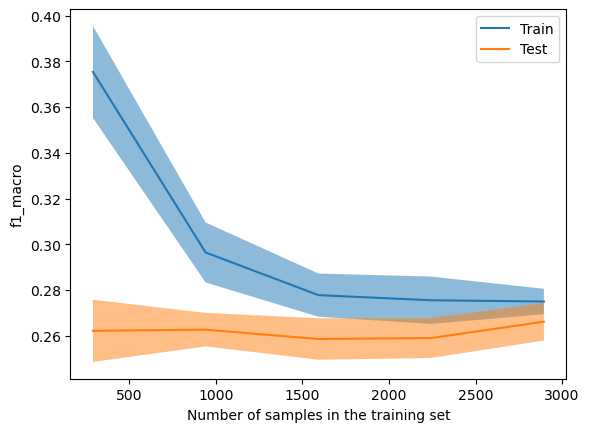

In [230]:
LearningCurveDisplay.from_estimator(mod_GaussianNB, 
                                    X = X_train_cont_feat, 
                                    y = y_train,  
                                    scoring = 'f1_macro', 
                                    score_name = 'f1_macro', 
                                    cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                    shuffle=True, random_state=42, n_jobs = -1)

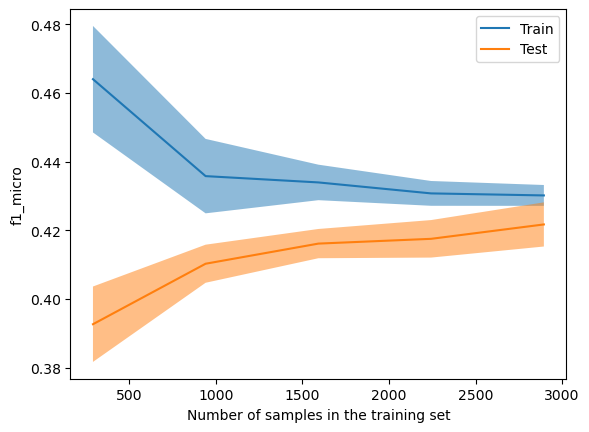

In [232]:
LearningCurveDisplay.from_estimator(mod_GaussianNB, 
                                    X = X_train_cont_feat, 
                                    y = y_train,  
                                    scoring = 'f1_micro', 
                                    score_name = 'f1_micro', 
                                    cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                    shuffle=True, random_state=42, n_jobs = -1)

### Explore default threshold (0.5)

#### Get probability from hybrid model

In [521]:
def get_y_pos_class_NB(mod_cont_feat, mod_cat_feat, X_cont, X_cat):
    class_log_prior = []
    for i, estimator in enumerate(mod_cont_feat.estimators_):
        class_log_prior.append(np.log(estimator.class_prior_))
    prob_cat_lst = mod_cat_feat.predict_proba(X_cat)
    log_prob_cat = [np.log(arr) for arr in prob_cat_lst]
    prob_cont_feat_lst = mod_cont_feat.predict_proba(X_cont)
    log_prob_cont_feat = [np.log(arr) for arr in prob_cont_feat_lst]
    combined_prob = []
    for num_lab in range(len(class_log_prior)):
        combined_prob.append(np.exp(log_prob_cat[num_lab] + log_prob_cont_feat[num_lab] - class_log_prior[num_lab]))
    normalized_prob = []
    for prob in combined_prob:
        normalized = prob / np.sum(prob, axis=1, keepdims=True)
        normalized_prob.append(normalized)
    y_scores_pos_class_nb = np.array([scores[:, 1] for scores in normalized_prob]).T
    return y_scores_pos_class_nb

In [244]:
y_scores_pos_class_nb = get_y_pos_class_NB(mod_GaussianNB, mod_BernoulliNB, X_valid_cont_feat, X_valid_cat)

In [1064]:
y_scores_pos_class_nb

array([[9.98025533e-01, 9.99959141e-01, 2.78557712e-04, ...,
        2.22961364e-01, 4.65867268e-01, 3.13358049e-01],
       [9.99721003e-01, 9.99959324e-01, 1.11274571e-04, ...,
        8.51983631e-01, 5.26182832e-01, 6.49532902e-01],
       [9.95986422e-01, 9.99474438e-01, 4.32272283e-04, ...,
        6.91510858e-01, 8.51273487e-01, 5.62663594e-01],
       ...,
       [7.66989087e-01, 8.68579121e-01, 9.70005812e-01, ...,
        5.23229722e-01, 2.23490142e-02, 8.72241277e-02],
       [9.95209279e-01, 9.96587008e-01, 1.38635545e-01, ...,
        9.03308677e-01, 7.93393644e-02, 1.36153539e-01],
       [9.40423034e-01, 8.72291238e-01, 3.27513671e-03, ...,
        8.96000967e-01, 5.24468155e-01, 6.14085670e-01]])

#### Get metrix and plots

In [523]:
default_thresh_nb = 0.5

In [248]:
y_pred_nb = (y_scores_pos_class_nb >= default_thresh_nb).astype(int)

In [250]:
pd.DataFrame.from_dict(classification_report(y_valid, y_pred_nb, target_names= name_genres_new, output_dict=True)).T.sort_values(by = 'support')

precision    recall  f1-score  support
Documentary    0.125000  1.000000  0.222222      1.0
Music          0.029126  0.214286  0.051282     14.0
Western        0.051724  0.642857  0.095745     14.0
Sport          0.061538  0.592593  0.111498     27.0
Biography      0.107477  0.851852  0.190871     27.0
Musical        0.081081  0.107143  0.092308     28.0
Horror         0.125000  0.285714  0.173913     35.0
History        0.153846  0.650000  0.248804     40.0
War            0.161677  0.658537  0.259615     41.0
Mystery        0.117221  0.987805  0.209573     82.0
Crime          0.250000  0.705882  0.369231    119.0
Animation      0.352071  1.000000  0.520788    119.0
Romance        0.273333  0.328000  0.298182    125.0
Sci-Fi         0.253772  0.948718  0.400433    195.0
Family         0.392704  0.933673  0.552870    196.0
Fantasy        0.279946  0.981132  0.435602    212.0
Drama          0.764706  0.438202  0.557143    267.0
Thriller       0.368644  0.963100  0.533197    271.0
Comedy         0.615625  0.693662  0.652318    284.0
Adventure      0.479452  0.958904  0.639269    365.0
Action         0.503947  0.979540  0.665508    391.0
micro avg      0.317203  0.815633  0.456767   2853.0
macro avg      0.264185  0.710552  0.346684   2853.0
weighted avg   0.412702  0.815633  0.508565   2853.0
samples avg    0.328856  0.811917  0.455122   2853.0

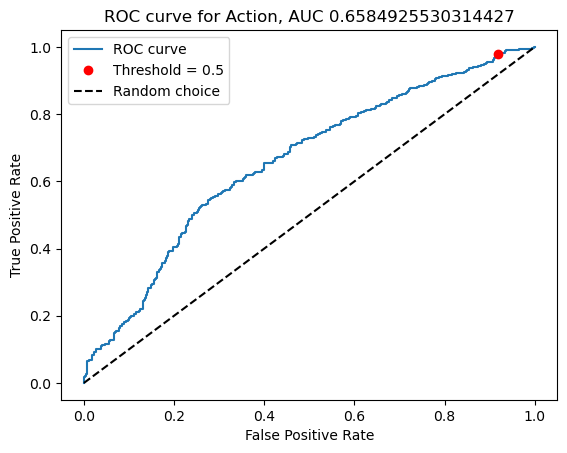

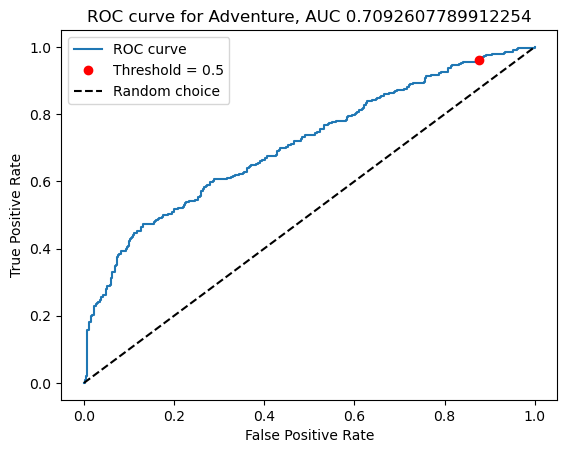

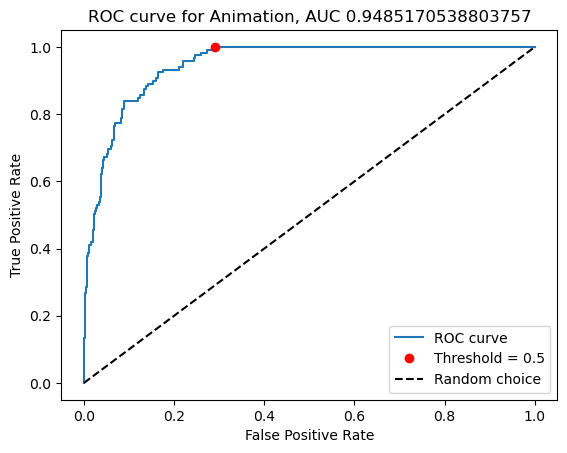

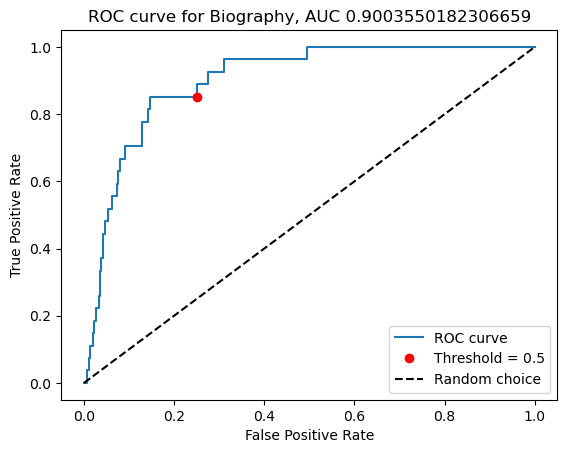

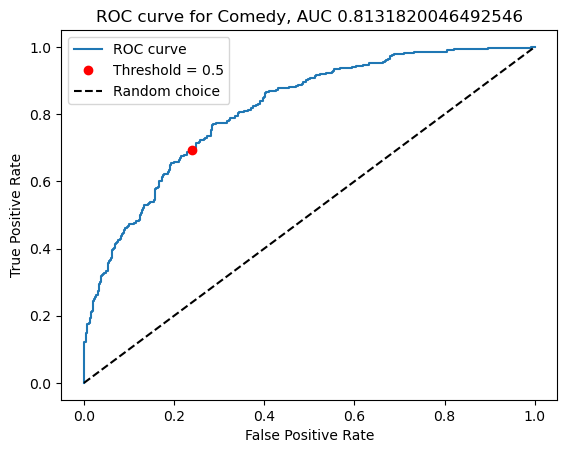

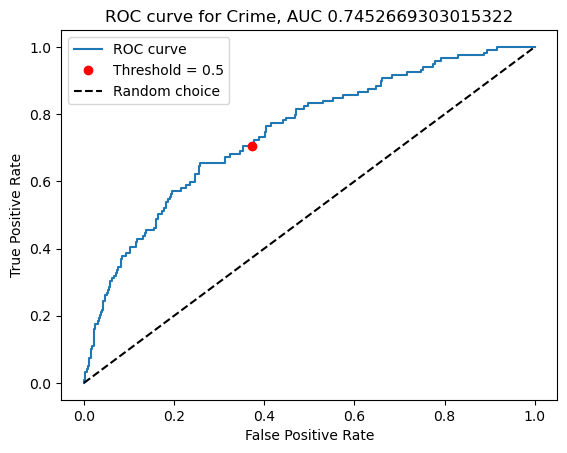

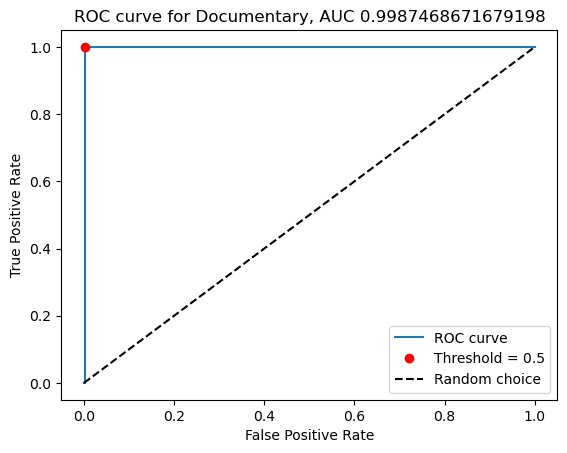

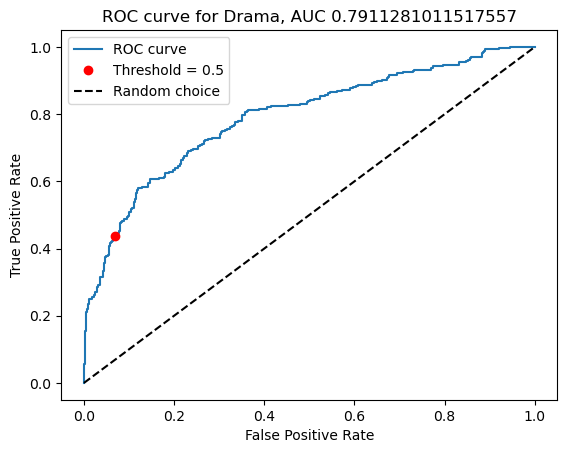

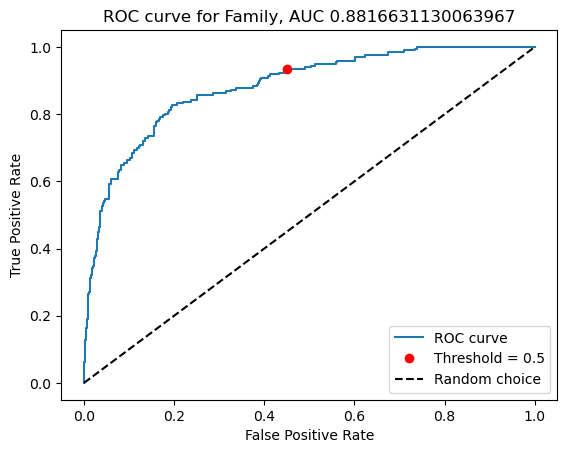

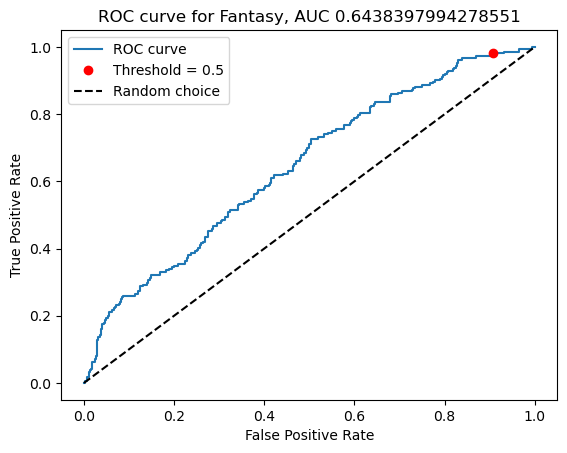

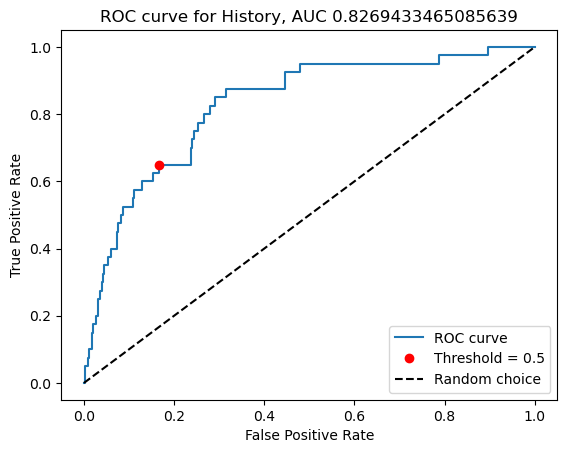

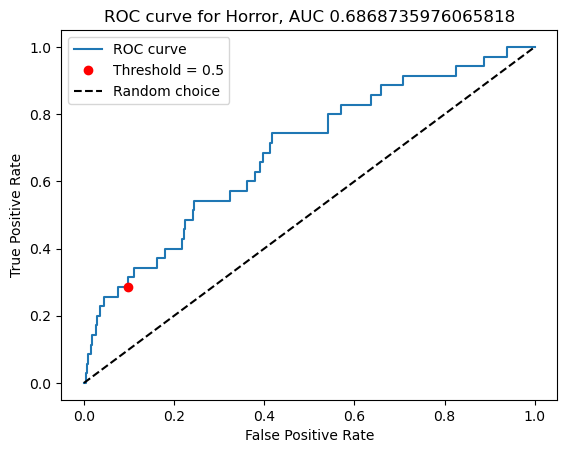

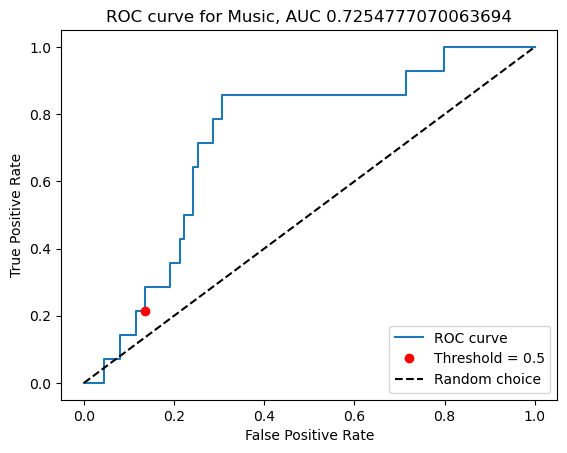

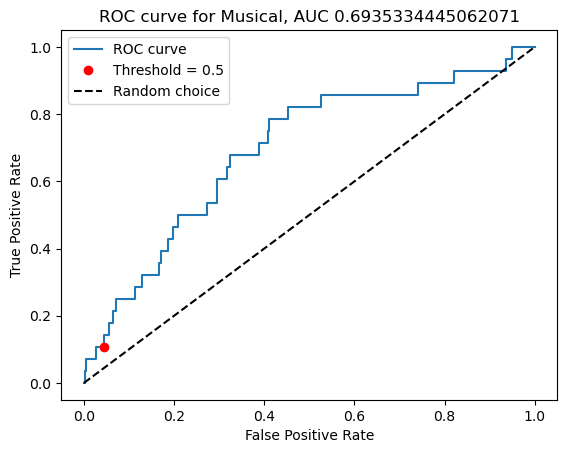

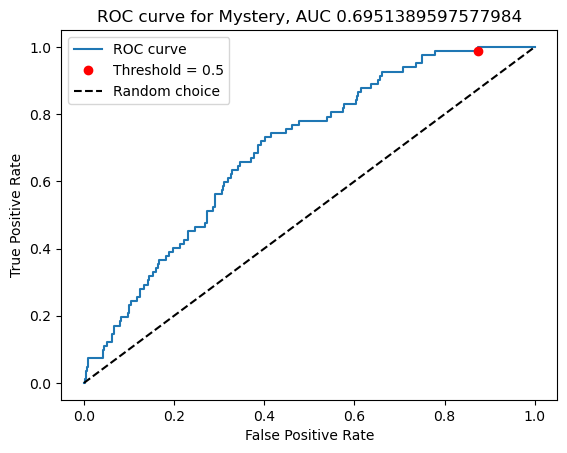

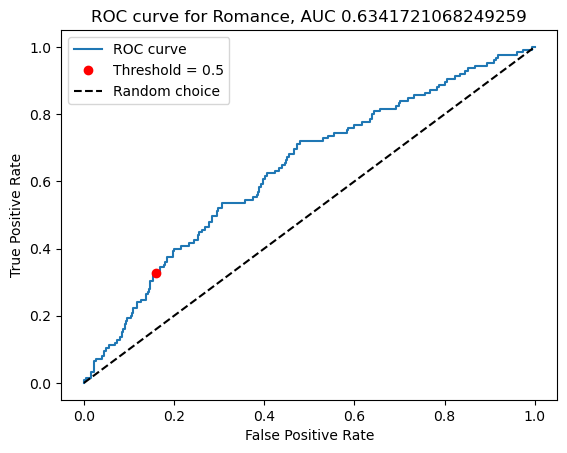

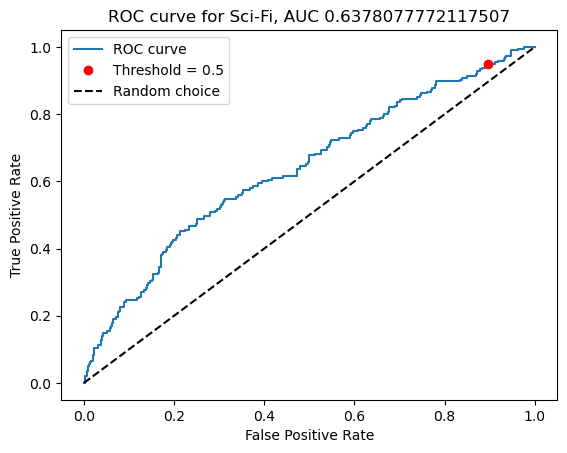

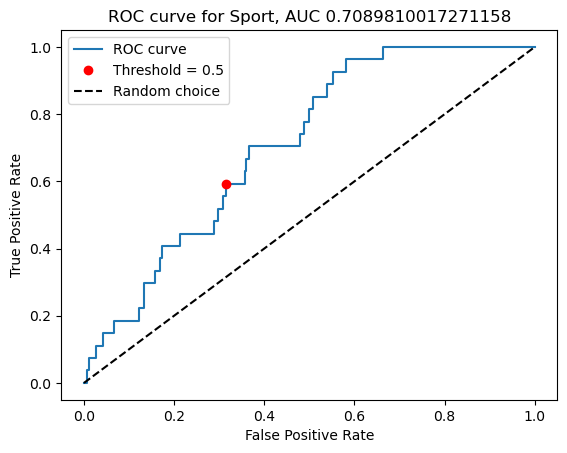

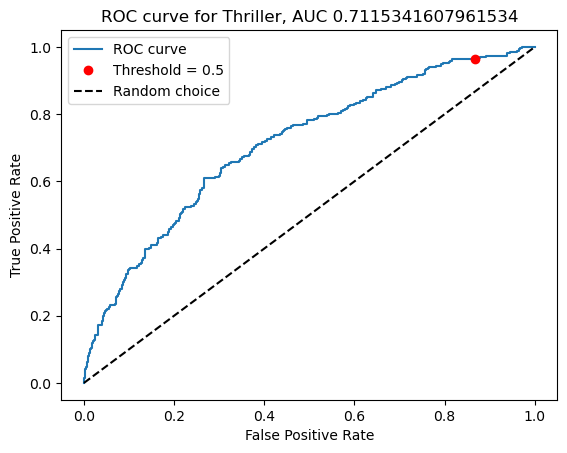

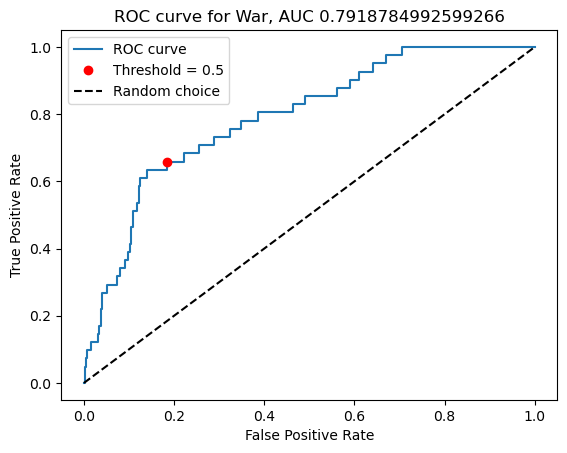

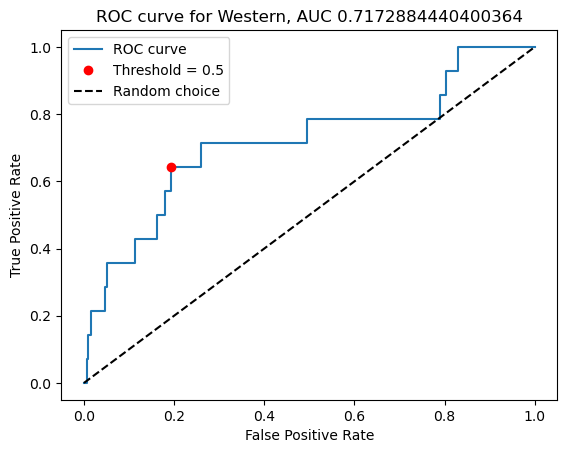

In [252]:
plot_roc(name_genres_new, y_valid, y_scores_pos_class_nb, default_thresh_nb)

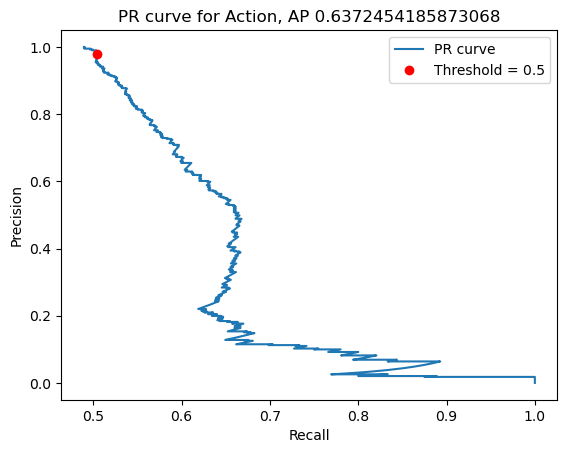

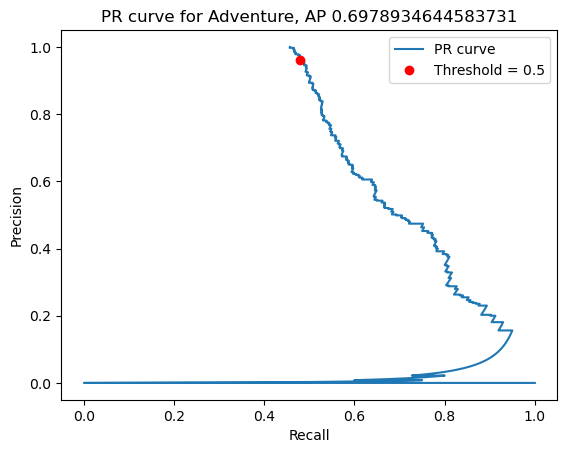

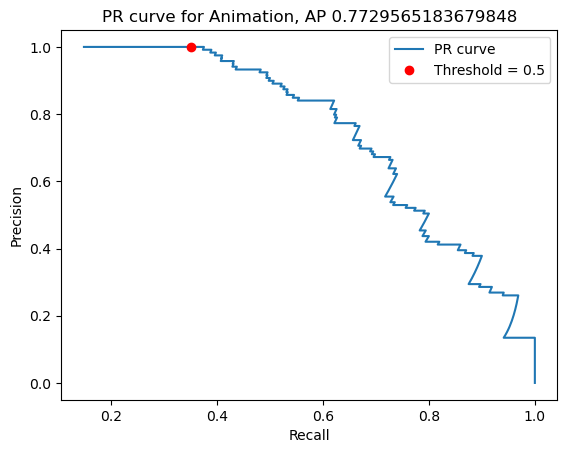

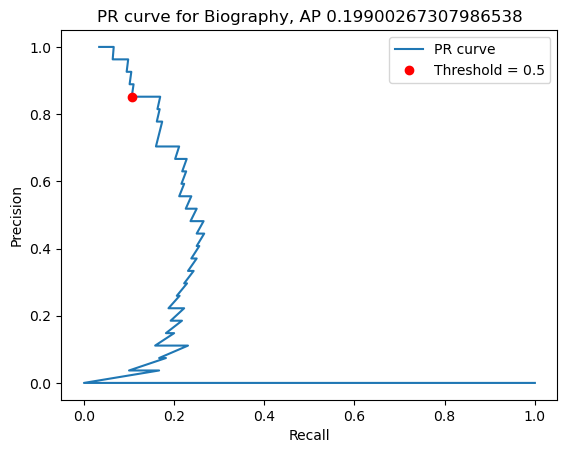

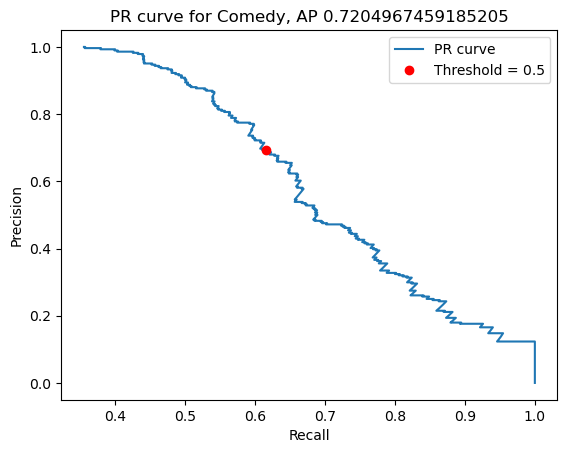

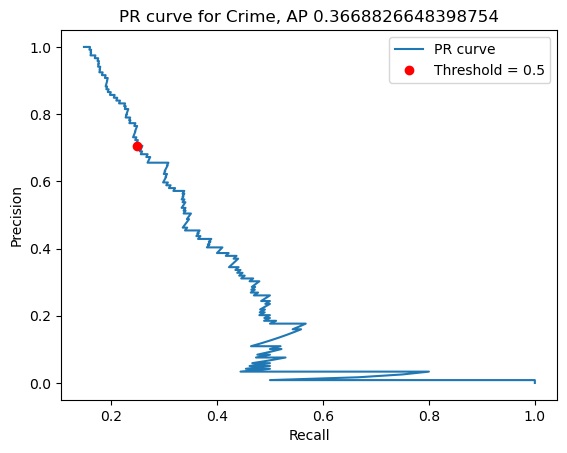

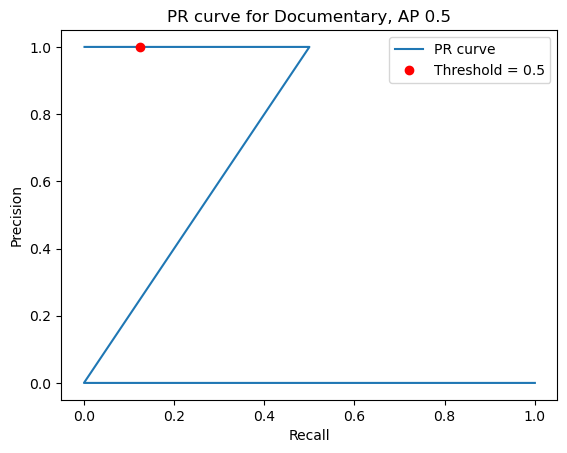

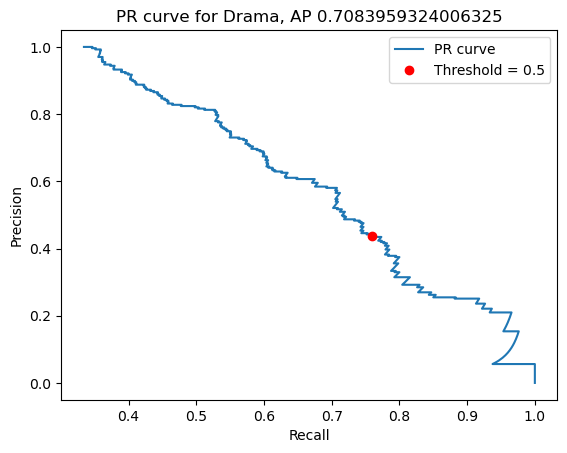

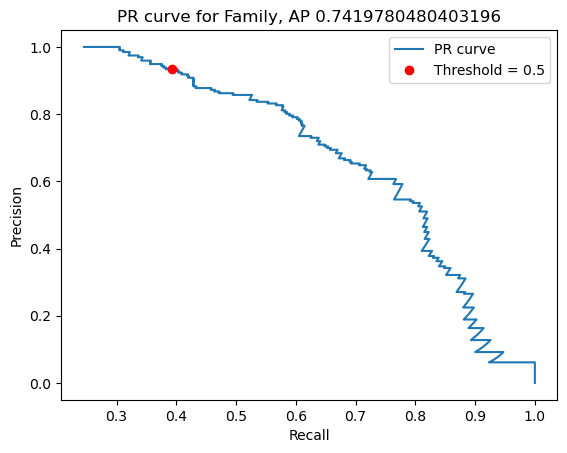

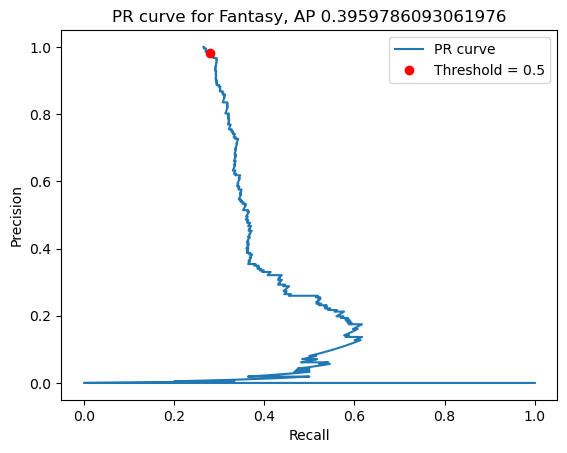

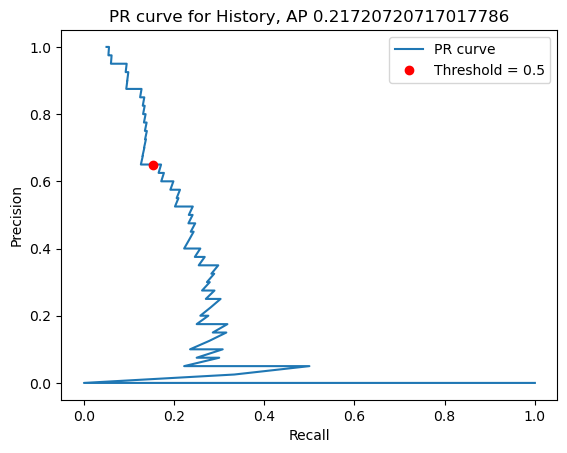

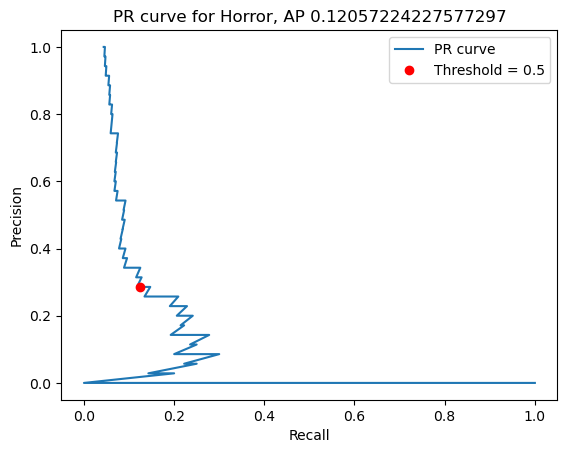

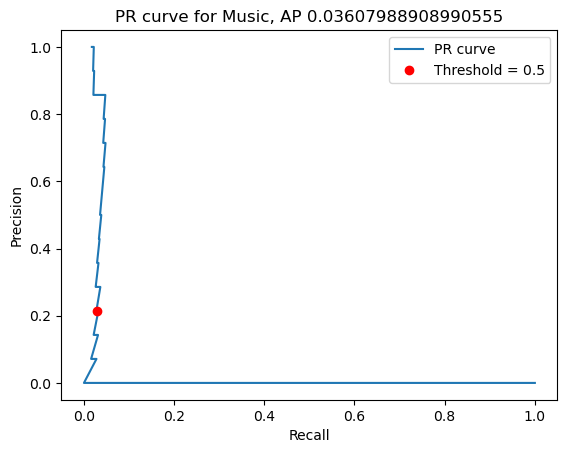

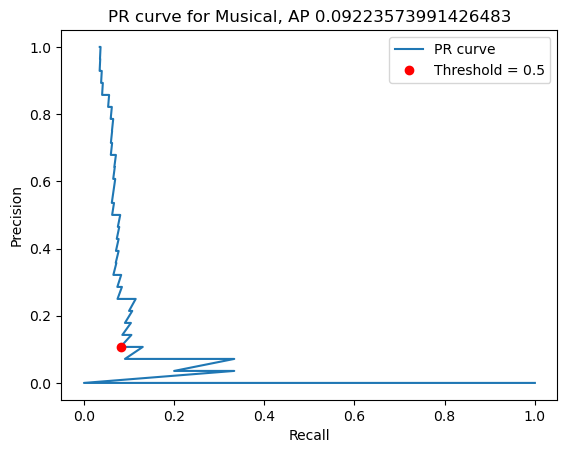

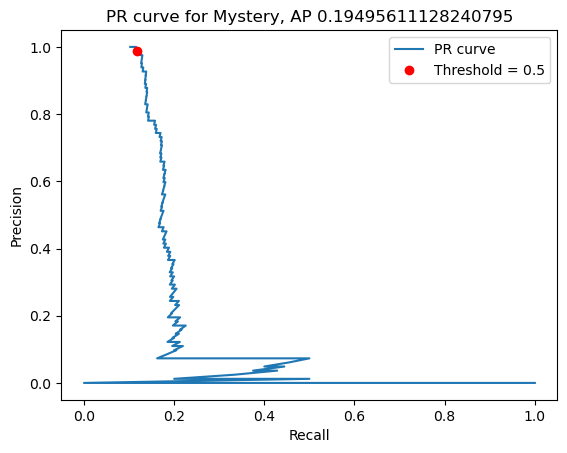

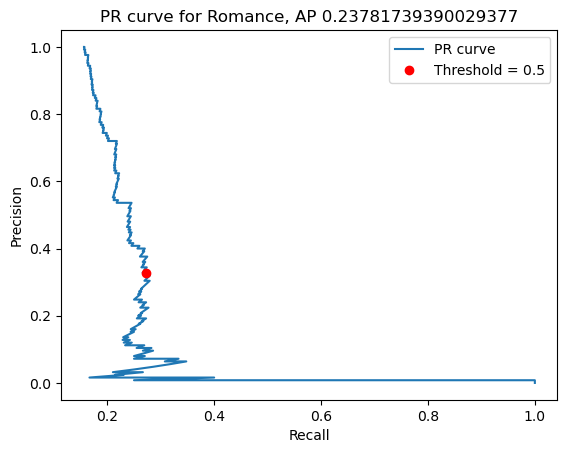

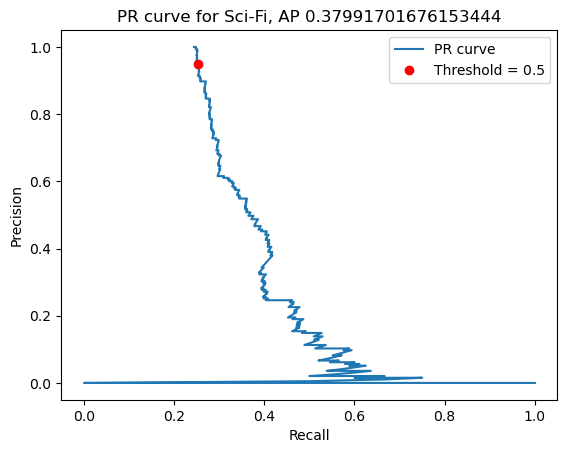

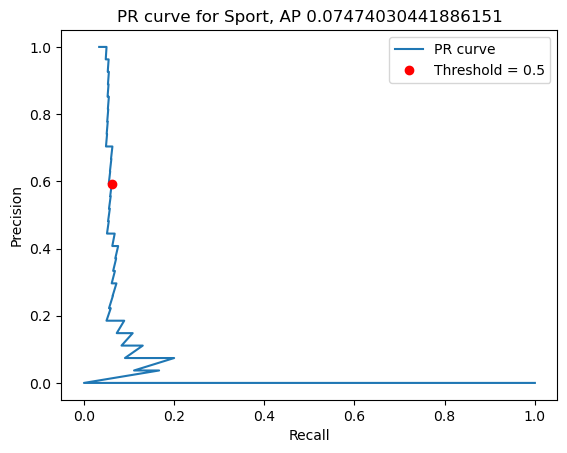

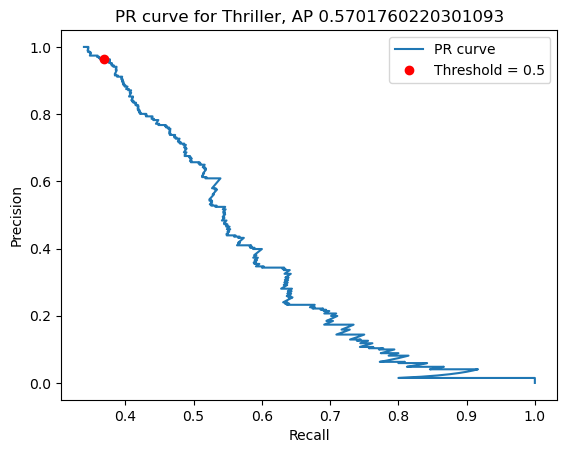

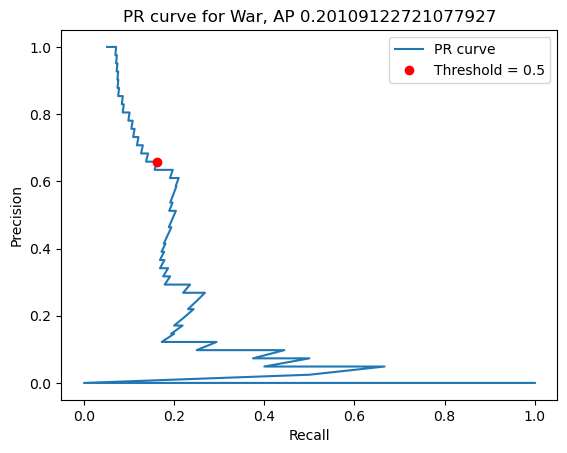

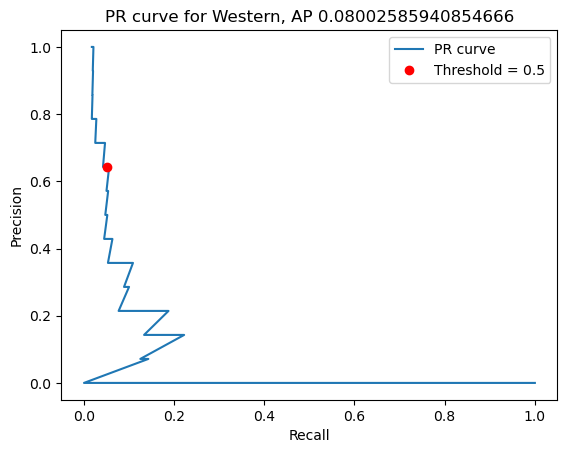

In [253]:
plot_pr_curve(name_genres_new, y_valid, y_scores_pos_class_nb, default_thresh_nb)

### Post-tuning of threshold with cross-validation

In [525]:
def create_df_threshold_f1_NB(threshold_range, i_cat, i_cont_feat, mod_cat_feat, mod_cont_feat):
    n_split = 2
    f1 = {}
    f1['threshold'] = threshold_range
    m_strat_split = MultilabelStratifiedShuffleSplit(n_splits=n_split, test_size=0.2, random_state=random_state)
    for split_num, (train_index, valid_index) in enumerate(m_strat_split.split(X_train, y_train)):
        X_tr, X_val = X[train_index], X[valid_index]
        y_tr, y_val = y[train_index], y[valid_index]
        X_tr_cat = X_tr[:, i_cat]
        X_val_cat = X_val[:, i_cat]
        X_tr_cont_feat = X_tr[:, i_cont_feat]
        X_val_cont_feat = X_val[:, i_cont_feat]
        mod_cat_feat.fit(X_tr_cat, y_tr)
        mod_cont_feat.fit(X_tr_cont_feat, y_tr)
        f1[split_num] = []
        for threshold in threshold_range:
            y_pred = (get_y_pos_class_NB(mod_cont_feat, mod_cat_feat, X_val_cont_feat, X_val_cat) >= threshold).astype(int)
            f1[split_num].append(f1_score(y_val, y_pred, average = 'samples'))
    threshold_f1_df = pd.DataFrame.from_dict(f1)
    threshold_f1_df['f1_sample_mean'] = threshold_f1_df.loc[:,[0,1]].mean(axis = 1)
    return threshold_f1_df

In [527]:
threshold_f1_df_NB = create_df_threshold_f1_NB(np.linspace(0.1, 0.9, 100), ind_cat, ind_cont_feat, mod_BernoulliNB, mod_GaussianNB)

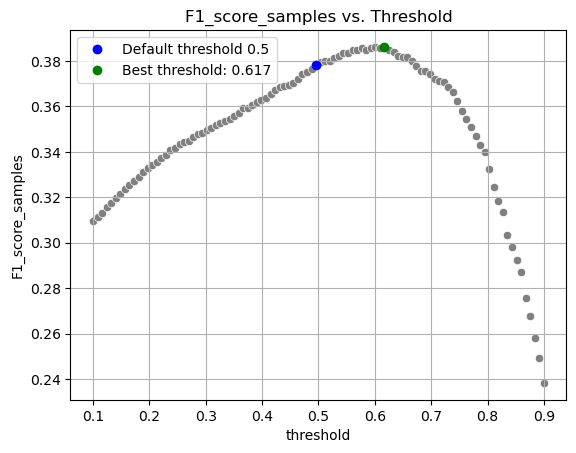

In [528]:
best_threshold_value_NB = find_best_threshold(threshold_f1_df_NB, default_thresh_nb)

#### Check metrics with best threshold

##### Using X_valid y_valid

In [272]:
predict_y_new_thr_nb= (y_scores_pos_class_nb >= best_threshold_value_NB).astype(int)

In [274]:
pd.DataFrame.from_dict(classification_report(y_valid, predict_y_new_thr_nb, target_names= name_genres_new, output_dict=True)).T.sort_values(by = 'support')

precision    recall  f1-score  support
Documentary    0.166667  1.000000  0.285714      1.0
Music          0.016949  0.071429  0.027397     14.0
Western        0.050847  0.428571  0.090909     14.0
Sport          0.069182  0.407407  0.118280     27.0
Biography      0.145570  0.851852  0.248649     27.0
Musical        0.111111  0.071429  0.086957     28.0
Horror         0.187500  0.257143  0.216867     35.0
History        0.172662  0.600000  0.268156     40.0
War            0.195312  0.609756  0.295858     41.0
Mystery        0.132174  0.926829  0.231355     82.0
Crime          0.328502  0.571429  0.417178    119.0
Animation      0.389439  0.991597  0.559242    119.0
Romance        0.265306  0.104000  0.149425    125.0
Sci-Fi         0.257642  0.907692  0.401361    195.0
Family         0.414747  0.918367  0.571429    196.0
Fantasy        0.291193  0.966981  0.447598    212.0
Drama          0.815534  0.314607  0.454054    267.0
Thriller       0.393312  0.911439  0.549499    271.0
Comedy         0.660448  0.623239  0.641304    284.0
Adventure      0.489392  0.947945  0.645522    365.0
Action         0.504762  0.948849  0.658970    391.0
micro avg      0.347184  0.758500  0.476337   2853.0
macro avg      0.288488  0.639551  0.350749   2853.0
weighted avg   0.435364  0.758500  0.500974   2853.0
samples avg    0.361343  0.750361  0.471922   2853.0

##### Using X_test y_test

In [537]:
y_pred_test_nb = (get_y_pos_class_NB(mod_GaussianNB, mod_BernoulliNB,X_test_cont_feat, X_test_cat) >= best_threshold_value_NB).astype(int)

In [539]:
metrics_test_best_thr_nb = pd.DataFrame.from_dict(classification_report(y_test, y_pred_test_nb, target_names= name_genres_new, output_dict=True)).T.sort_values(by = 'support')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [439]:
metrics_test_best_thr_nb

precision    recall  f1-score  support
Musical        0.000000  0.000000  0.000000      0.0
Music          0.090909  1.000000  0.166667      1.0
Western        0.000000  0.000000  0.000000      1.0
Documentary    0.333333  1.000000  0.500000      1.0
Sport          0.050000  0.333333  0.086957      3.0
Biography      0.272727  0.600000  0.375000      5.0
Horror         0.142857  0.200000  0.166667      5.0
History        0.312500  1.000000  0.476190      5.0
Mystery        0.083333  0.571429  0.145455      7.0
War            0.333333  0.500000  0.400000      8.0
Crime          0.200000  0.181818  0.190476     11.0
Animation      0.343750  1.000000  0.511628     11.0
Family         0.372093  0.941176  0.533333     17.0
Romance        0.333333  0.117647  0.173913     17.0
Sci-Fi         0.279412  0.863636  0.422222     22.0
Fantasy        0.309859  1.000000  0.473118     22.0
Thriller       0.372881  0.814815  0.511628     27.0
Drama          0.909091  0.294118  0.444444     34.0
Comedy         0.863636  0.542857  0.666667     35.0
Adventure      0.454545  0.853659  0.593220     41.0
Action         0.544304  0.914894  0.682540     47.0
micro avg      0.357027  0.690625  0.470714    320.0
macro avg      0.314376  0.606161  0.358101    320.0
weighted avg   0.480703  0.690625  0.494808    320.0
samples avg    0.354712  0.661196  0.448059    320.0

### Check stability of the model using random state

In [541]:
def metrics_diff_random_state(mod_cat_feat, mod_cont_feat, best_threshold_value, i_cat, i_cont_feat):
    sample_size_stability = 100
    random.seed(42)
    range_random = range(1, 1001)
    selected_random_states = random.sample(range_random, sample_size_stability)
    rand_state_metrics = {'random_state': [], 'f1_score_mean': [], 'aver_prec_score_mean': []}
    for rand_stat in selected_random_states:
        score={'f1_score': [], 'aver_prec_score': []}
        m_strat_split = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=rand_stat)
        for split_num, (train_index, valid_index) in enumerate(m_strat_split.split(X_train, y_train)):
            X_tr, X_val = X[train_index], X[valid_index]
            y_tr, y_val = y[train_index], y[valid_index]
            X_tr_cat = X_tr[:, i_cat]
            X_val_cat = X_val[:, i_cat]
            X_tr_cont_feat = X_tr[:, i_cont_feat]
            X_val_cont_feat = X_val[:, i_cont_feat]
            mod_cat_feat.fit(X_tr_cat, y_tr)
            mod_cont_feat.fit(X_tr_cont_feat, y_tr)
            y_pred = (get_y_pos_class_NB(mod_cont_feat, mod_cat_feat, X_val_cont_feat, X_val_cat) >= best_threshold_value).astype(int)
            score['f1_score'].append(f1_score(y_val, y_pred, average = 'samples'))
            score['aver_prec_score'].append(average_precision_score(y_val, y_pred, average = 'samples'))
        rand_state_metrics['random_state'].append(rand_stat)
        rand_state_metrics['f1_score_mean'].append(statistics.mean(score['f1_score']))
        rand_state_metrics['aver_prec_score_mean'].append(statistics.mean(score['aver_prec_score']))
    return pd.DataFrame.from_dict(rand_state_metrics)

In [543]:
nb_rand_state_metrics_df = metrics_diff_random_state(mod_BernoulliNB, mod_GaussianNB, best_threshold_value_NB, ind_cat, ind_cont_feat,)

In [544]:
nb_final_analize_dic = create_dic_final_analize_model(nb_rand_state_metrics_df)

In [545]:
nb_final_analize_dic

{'f1_score_mean': 0.3862783037436099,
 'f1_score_std': 0.00479291698169959,
 'aver_prec_score_mean': 0.2815632122358831,
 'aver_prec_score_std': 0.0036075257598539106}

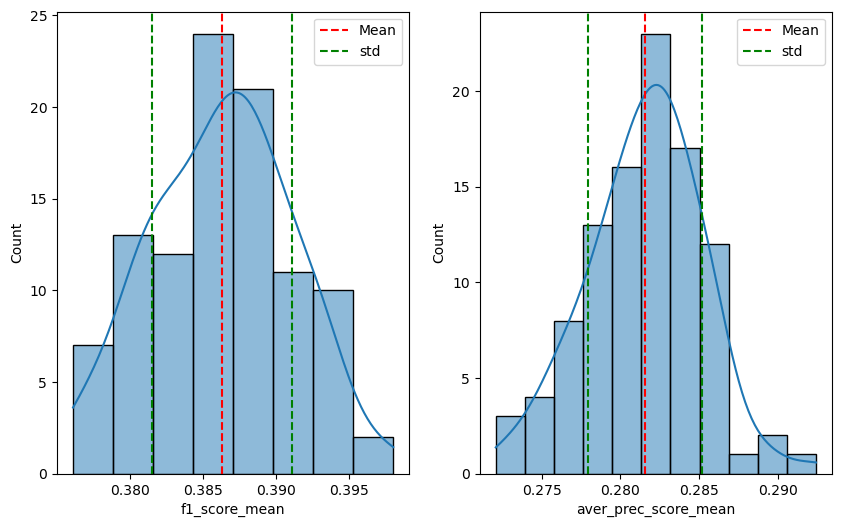

In [316]:
visializ_final_anal_model(nb_rand_state_metrics_df, nb_final_analize_dic)

## Random Forest

### Fit the model

In [341]:
mod_rand_forest = MultiOutputClassifier(RandomForestClassifier(random_state = random_state, max_depth=10, min_samples_split=10, n_estimators = 70))

In [327]:
mod_rand_forest.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=8,
                                                       min_samples_split=6,
                                                       n_estimators=70,
                                                       random_state=42))

In [171]:
def calcul_log_loss(model, X_set, y_set):
    log_losses = []
    prob_y = model.predict_proba(X_set)
    for i in range(len(prob_y)):
        y_true_label = y_set[:, i]
        y_pred_label = prob_y[i] 
        log_loss_label = log_loss(y_true_label, y_pred_label)
        log_losses.append(log_loss_label)
    return np.mean(log_losses)

In [199]:
def vizual_learn_curve_log_loss(mod_rand_forest, X_buff, y_buff):
    train_sizes = np.linspace(0.1, 0.95, 10)  # Example training sizes
    train_scores = []
    valid_scores = []

    for train_size in train_sizes:
        split_multilab = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=random_state)
        for train_i, temp_i in split_multilab.split(X_buff, y_buff):
            X_tr, X_val = X[train_i], X[temp_i]
            y_tr, y_val = y[train_i], y[temp_i]
        mod_rand_forest.fit(X_tr, y_tr)
        train_loss = calcul_log_loss(mod_rand_forest, X_tr, y_tr)
        valid_loss = calcul_log_loss(mod_rand_forest, X_val, y_val)
        train_scores.append(train_loss)
        valid_scores.append(valid_loss)
        
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes * len(X_buff), train_scores, 'o-', color="r", label="Training Loss")
    plt.plot(train_sizes * len(X_buff), valid_scores, 'o-', color="g", label="Validation Loss")
    plt.xlabel("Training Set Size")
    plt.ylabel("Log Loss")
    plt.title("Learning Curve - Log Loss vs. Training Set Size")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

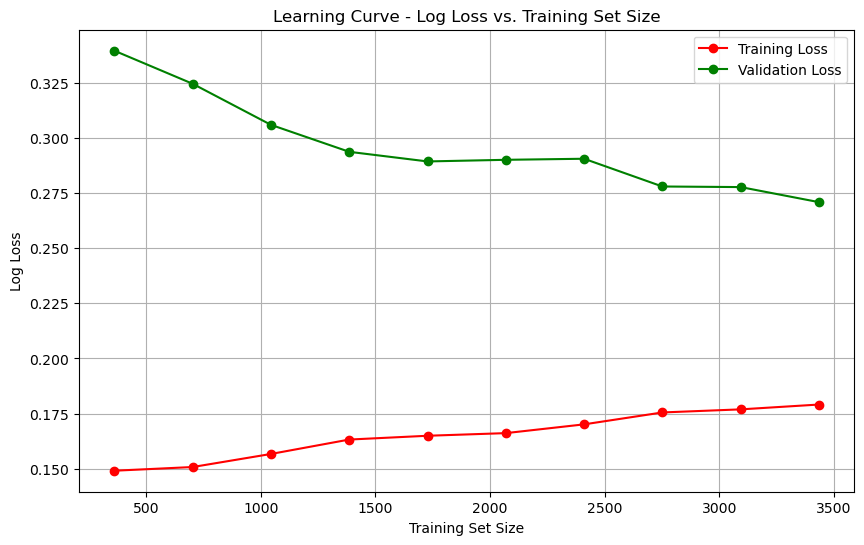

In [343]:
vizual_learn_curve_log_loss(mod_rand_forest, X_train, y_train)

In [345]:
calcul_log_loss(mod_rand_forest, X_valid, y_valid)

0.19028696454585672

In [347]:
predict_y_rand_forest = mod_rand_forest.predict(X_valid)

In [349]:
metrics_rand_forest = pd.DataFrame.from_dict(classification_report(y_valid, predict_y_rand_forest, target_names= name_genres_new, output_dict=True)).T.sort_values(by = 'support')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [351]:
metrics_rand_forest

precision    recall  f1-score  support
Documentary    0.000000  0.000000  0.000000      1.0
Music          0.000000  0.000000  0.000000     14.0
Western        0.000000  0.000000  0.000000     14.0
Sport          0.000000  0.000000  0.000000     27.0
Biography      1.000000  0.111111  0.200000     27.0
Musical        0.000000  0.000000  0.000000     28.0
Horror         1.000000  0.228571  0.372093     35.0
History        1.000000  0.050000  0.095238     40.0
War            1.000000  0.024390  0.047619     41.0
Mystery        1.000000  0.036585  0.070588     82.0
Crime          1.000000  0.226891  0.369863    119.0
Animation      1.000000  0.731092  0.844660    119.0
Romance        1.000000  0.056000  0.106061    125.0
Sci-Fi         1.000000  0.502564  0.668942    195.0
Family         0.986755  0.760204  0.858790    196.0
Fantasy        1.000000  0.471698  0.641026    212.0
Drama          0.932127  0.771536  0.844262    267.0
Thriller       0.961905  0.745387  0.839917    271.0
Comedy         0.947791  0.830986  0.885553    284.0
Adventure      0.958188  0.753425  0.843558    365.0
Action         0.963380  0.874680  0.916890    391.0
micro avg      0.965174  0.611987  0.749035   2853.0
macro avg      0.750007  0.341672  0.409765   2853.0
weighted avg   0.944112  0.611987  0.698689   2853.0
samples avg    0.932937  0.622425  0.716415   2853.0

### Explore default threshold (0.5)

In [353]:
default_thresh_rand_for = 0.5

In [355]:
prob_y_valid_rand_for = mod_rand_forest.predict_proba(X_valid)

In [357]:
y_scores_pos_class_rand_for = np.array([scores[:, 1] for scores in prob_y_valid_rand_for]).T

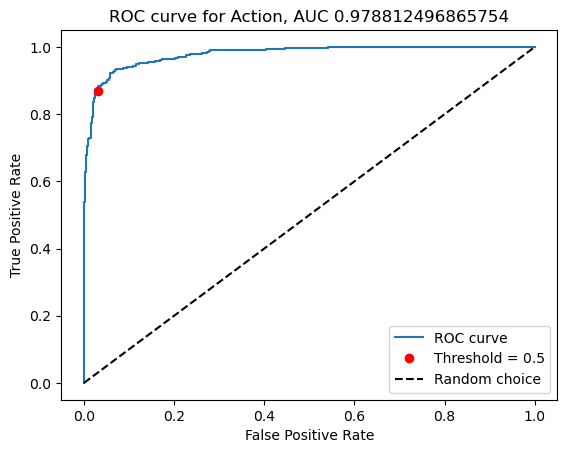

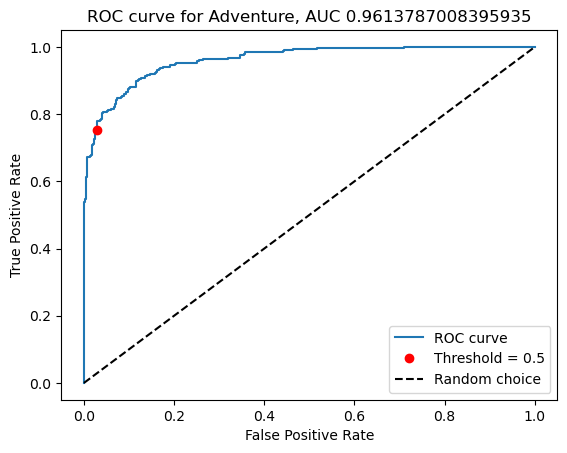

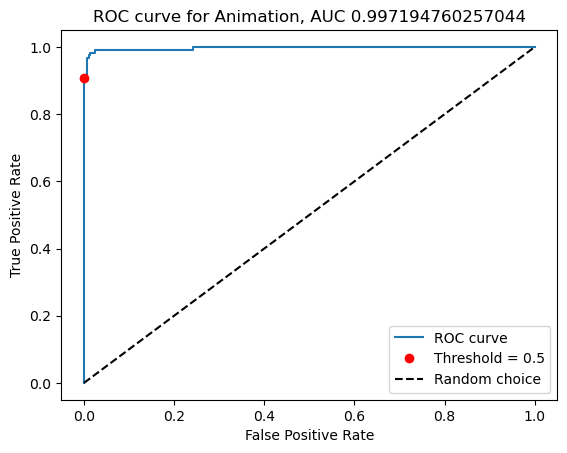

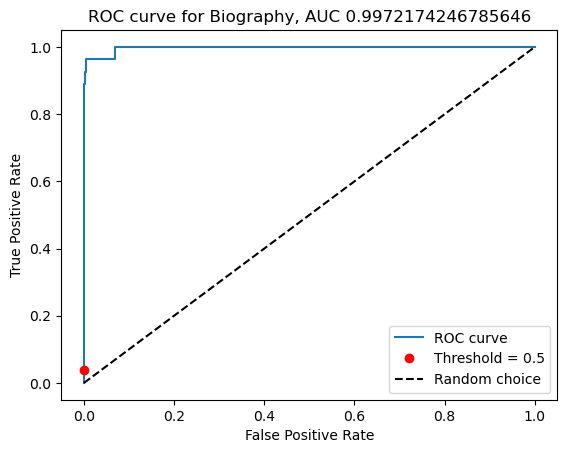

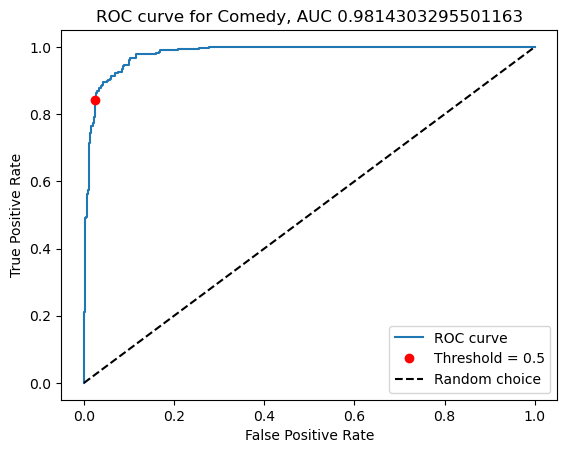

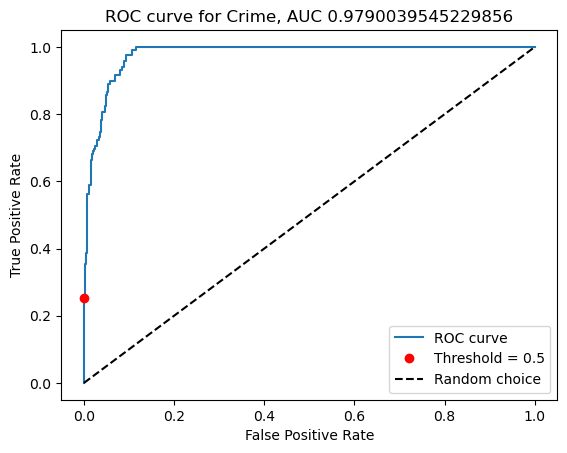

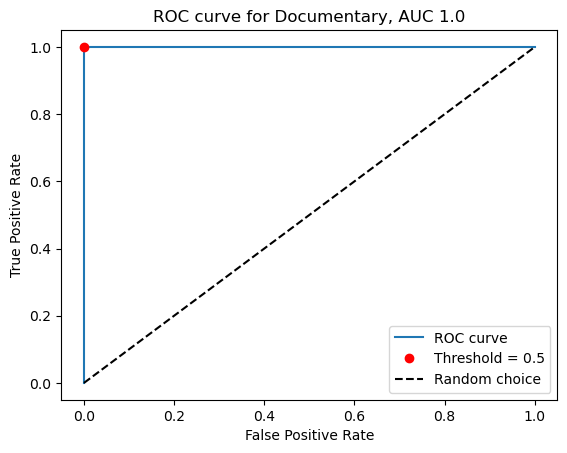

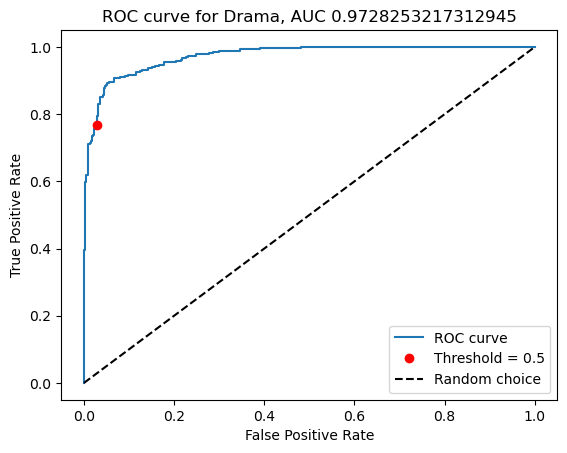

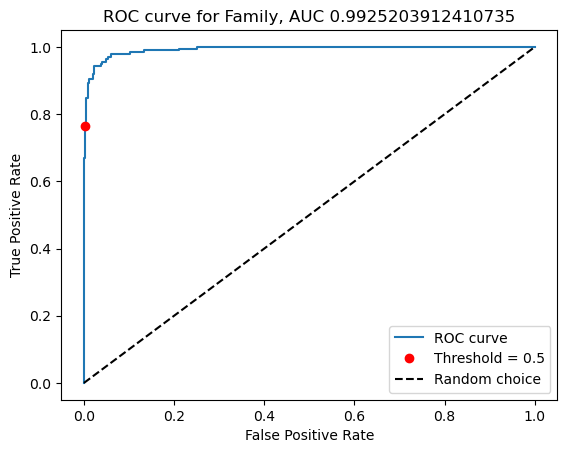

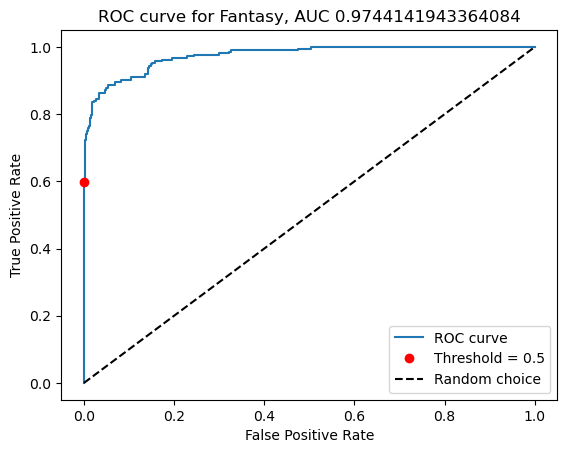

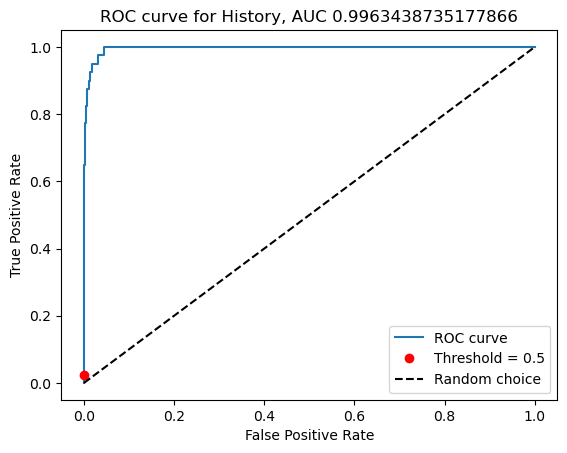

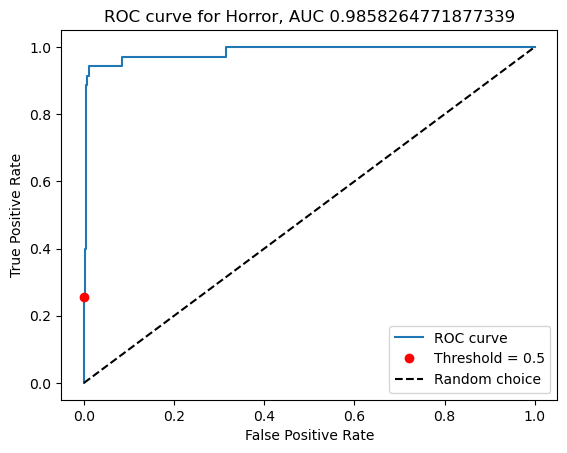

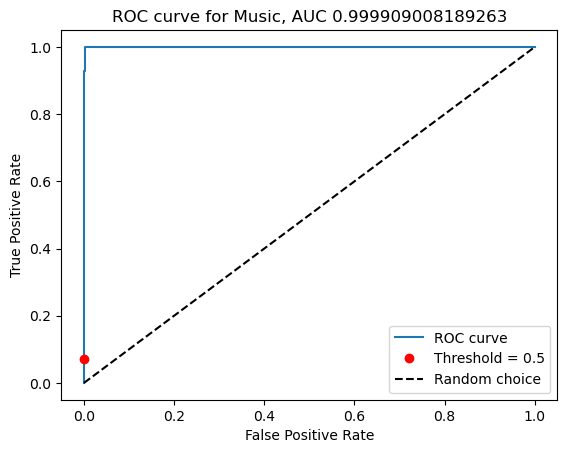

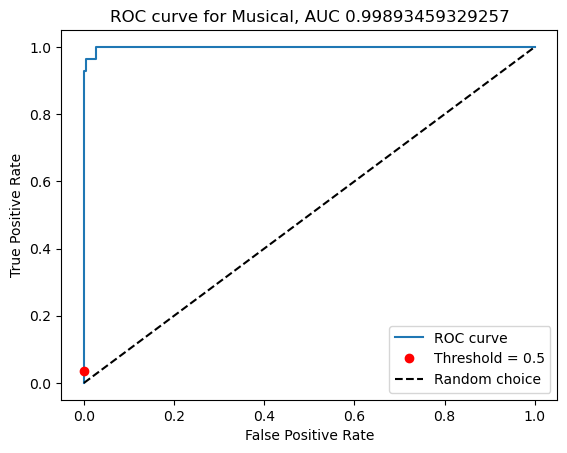

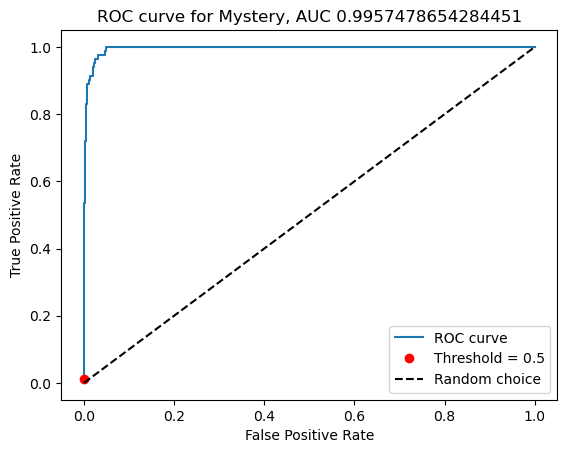

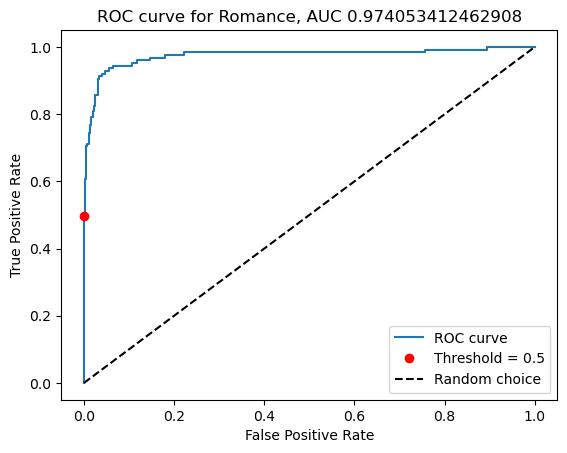

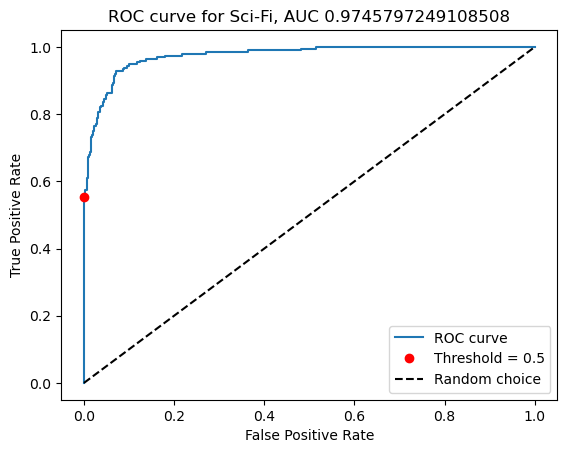

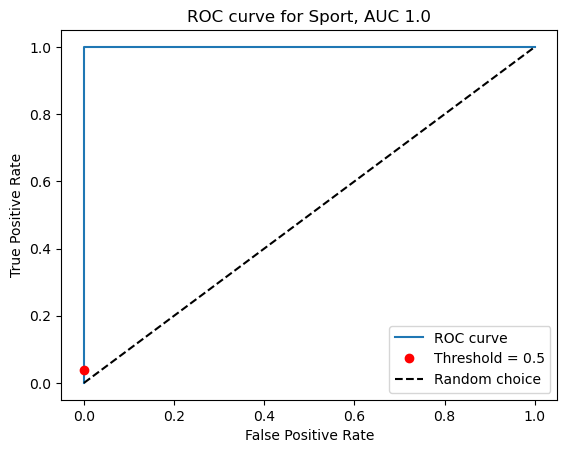

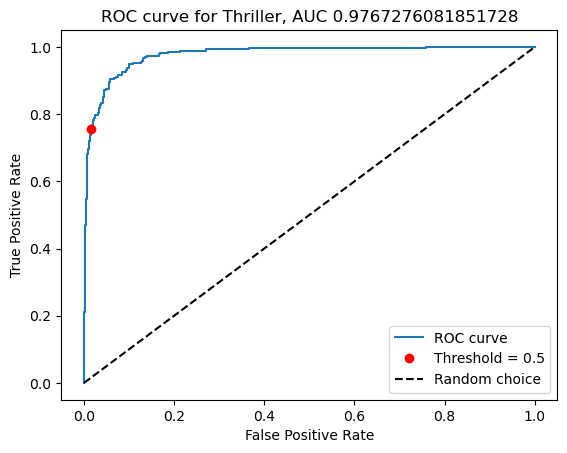

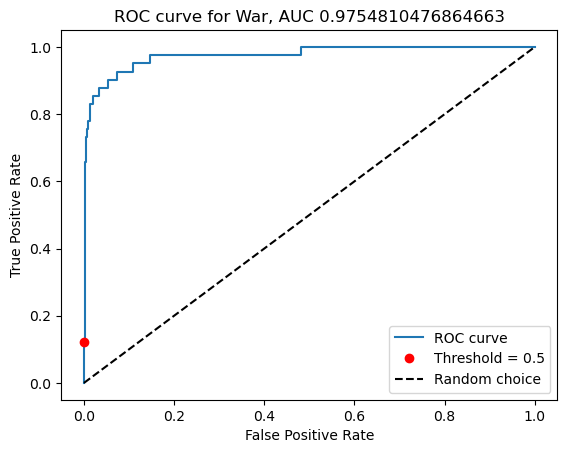

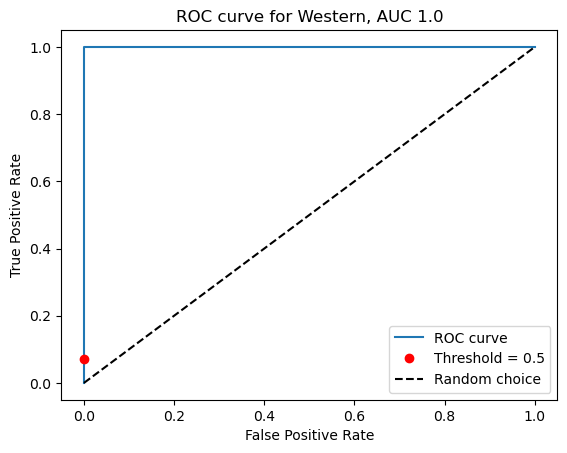

In [377]:
plot_roc(name_genres_new, y_valid, y_scores_pos_class_rand_for, default_thresh_rand_for)

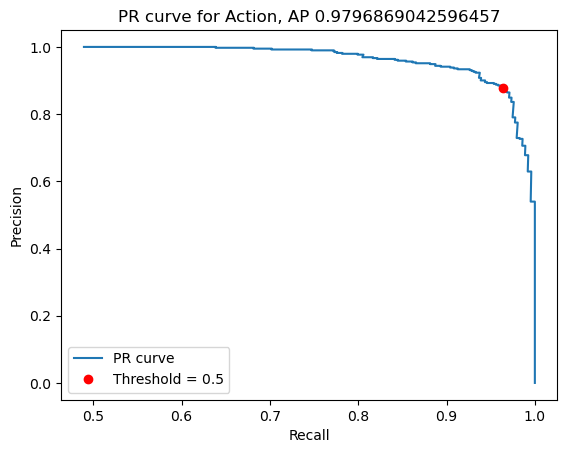

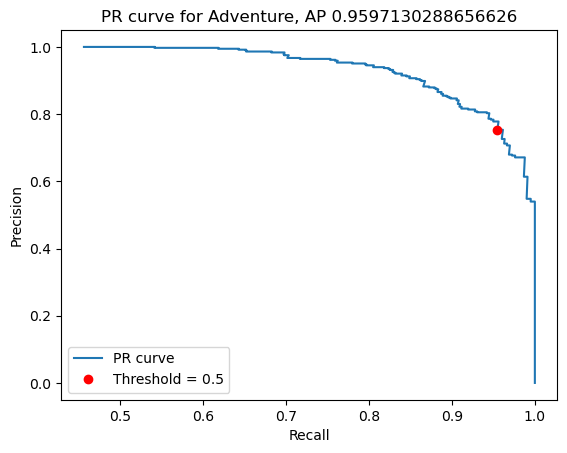

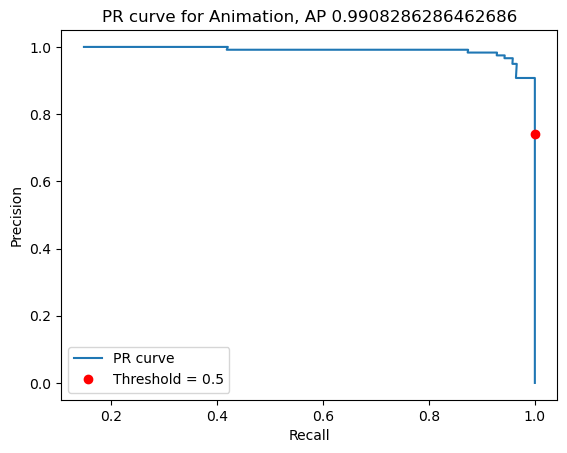

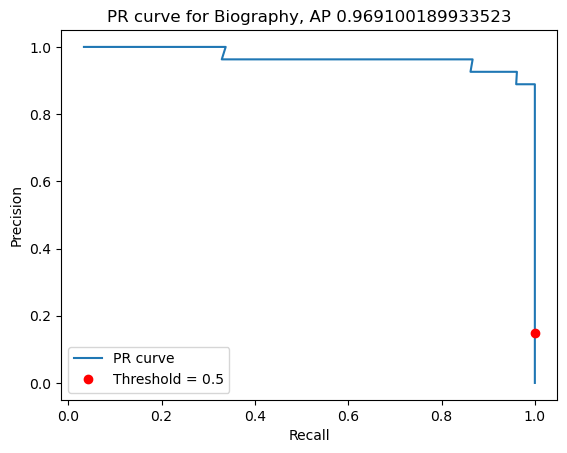

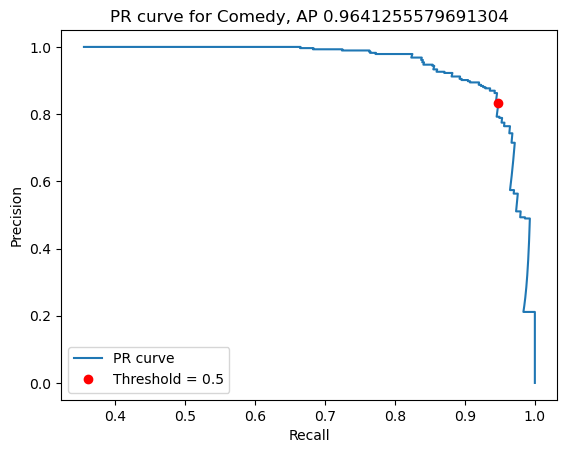

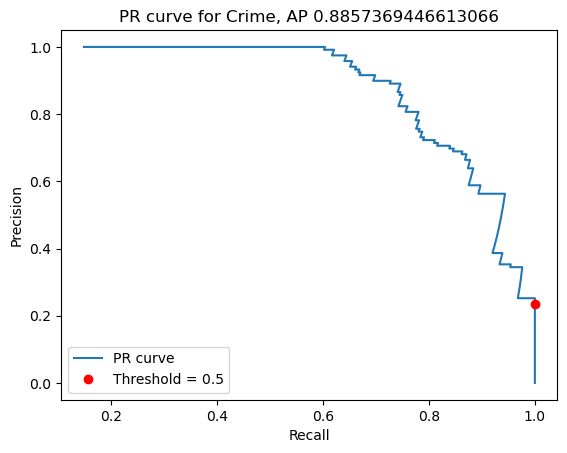

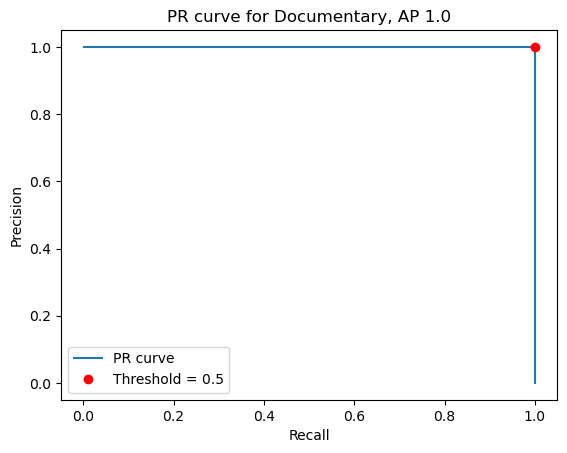

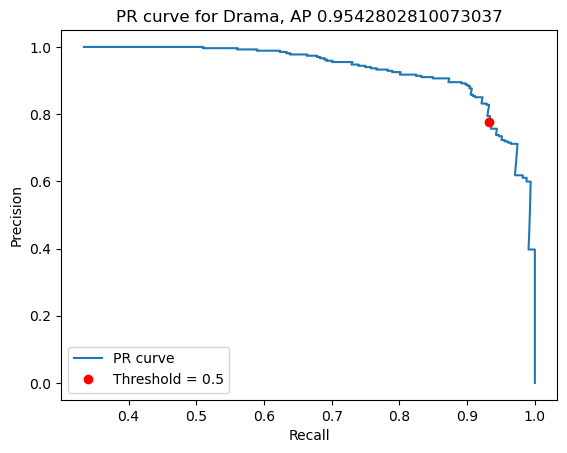

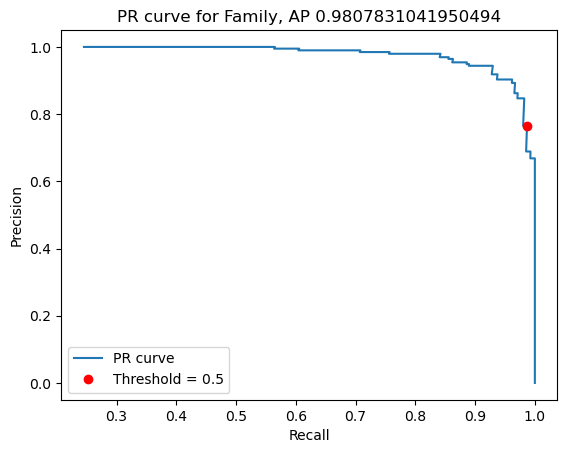

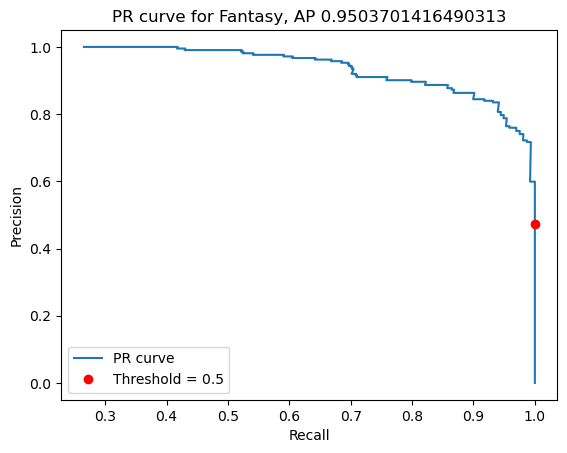

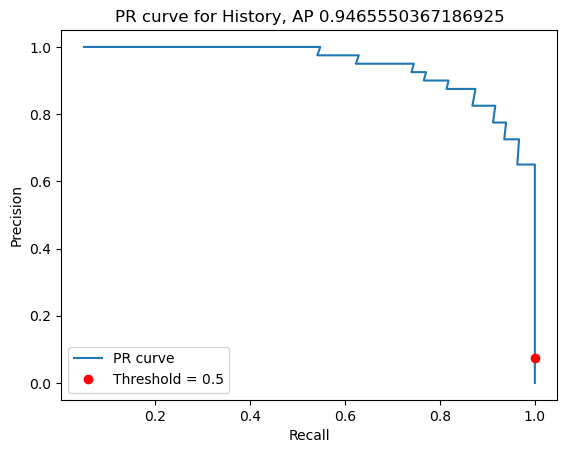

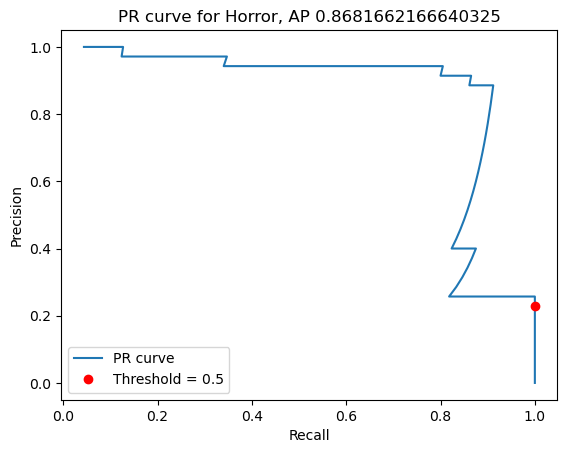

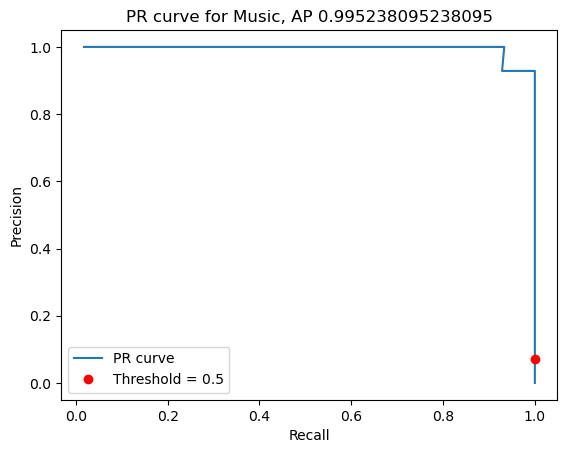

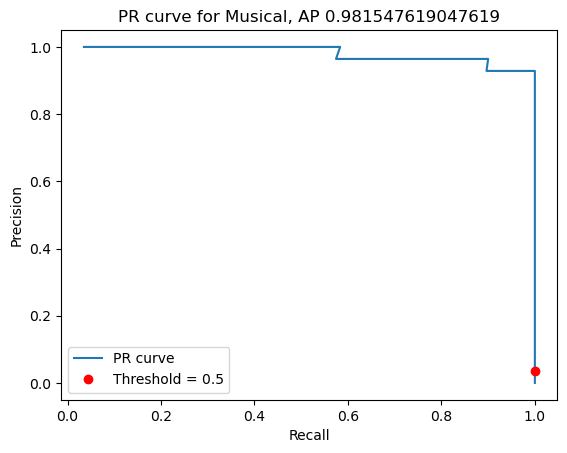

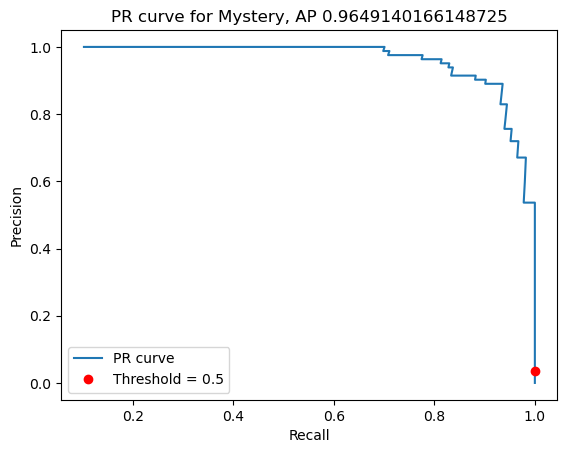

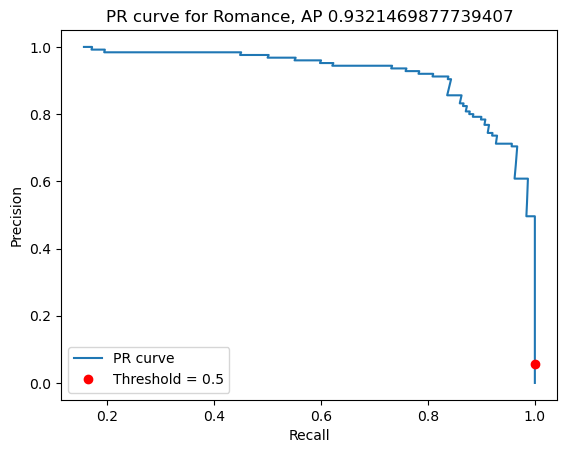

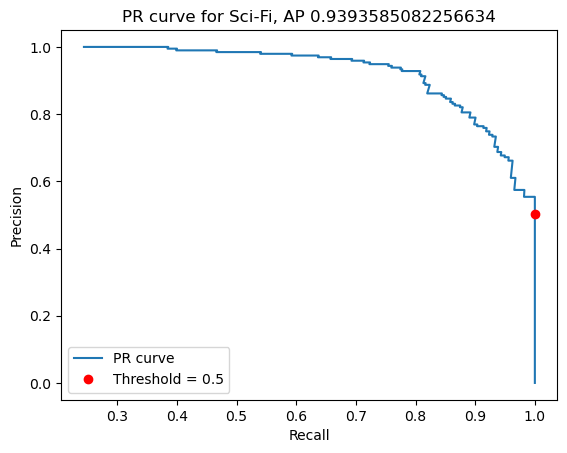

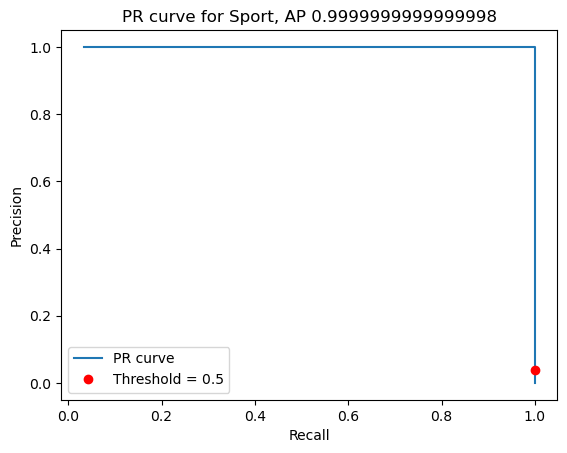

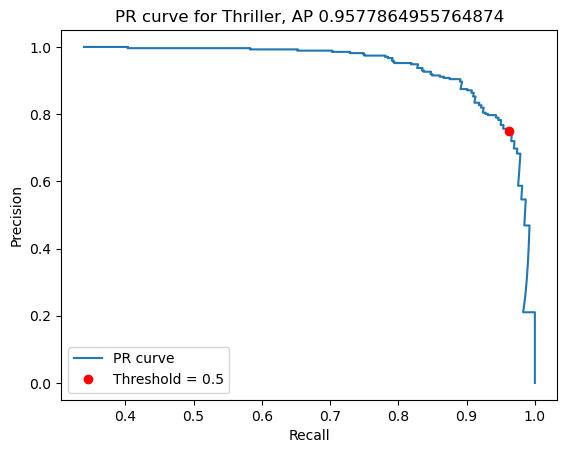

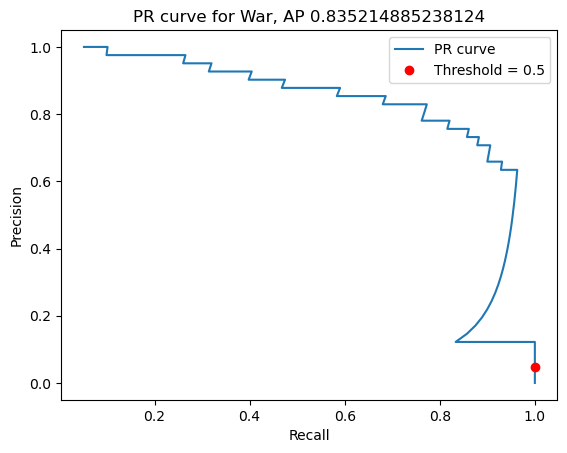

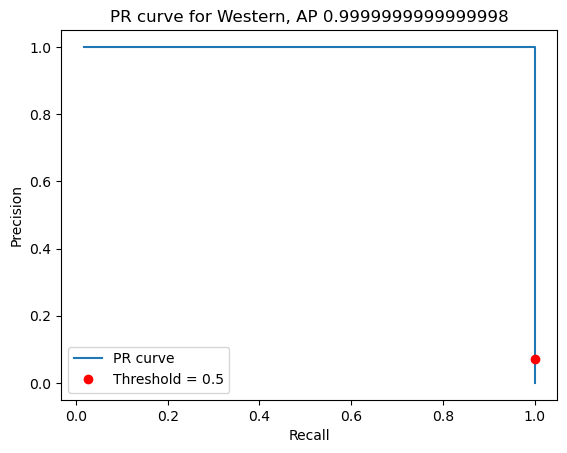

In [379]:
plot_pr_curve(name_genres_new, y_valid, y_scores_pos_class_rand_for, default_thresh_rand_for)

### Post-tuning of threshold with cross-validation

In [381]:
threshold_f1_df_rand_for = create_df_threshold_f1(np.linspace(0.1, 0.9, 100), X_train, y_train, mod_rand_forest, True)

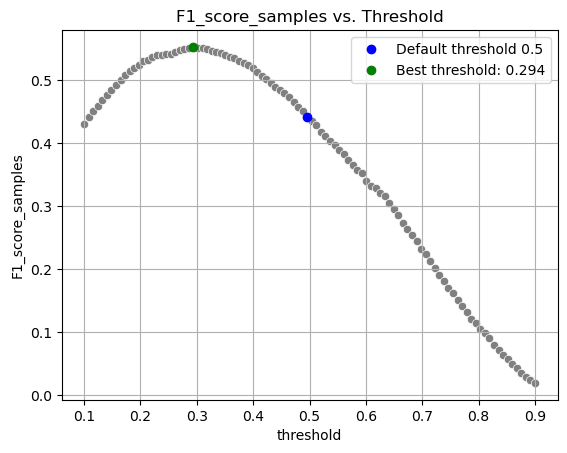

In [385]:
best_threshold_value_rand_for = find_best_threshold(threshold_f1_df_rand_for, default_thresh_rand_for)

#### Check metrics with best threshold

##### Using X_valid y_valid

In [387]:
predict_y_new_thr_rand_for = (y_scores_pos_class_rand_for >= best_threshold_value_rand_for).astype(int)

In [389]:
pd.DataFrame.from_dict(classification_report(y_valid, predict_y_new_thr_rand_for, target_names= name_genres_new, output_dict=True)).T.sort_values(by = 'support')

precision    recall  f1-score  support
Documentary    1.000000  1.000000  1.000000      1.0
Music          1.000000  0.428571  0.600000     14.0
Western        1.000000  0.500000  0.666667     14.0
Sport          1.000000  0.444444  0.615385     27.0
Biography      1.000000  0.740741  0.851064     27.0
Musical        1.000000  0.285714  0.444444     28.0
Horror         0.906250  0.828571  0.865672     35.0
History        1.000000  0.650000  0.787879     40.0
War            0.956522  0.536585  0.687500     41.0
Mystery        1.000000  0.487805  0.655738     82.0
Crime          0.776860  0.789916  0.783333    119.0
Animation      0.943089  0.974790  0.958678    119.0
Romance        0.814286  0.912000  0.860377    125.0
Sci-Fi         0.819512  0.861538  0.840000    195.0
Family         0.902439  0.943878  0.922693    196.0
Fantasy        0.773279  0.900943  0.832244    212.0
Drama          0.673575  0.973783  0.796325    267.0
Thriller       0.652913  0.992620  0.787701    271.0
Comedy         0.755376  0.989437  0.856707    284.0
Adventure      0.773333  0.953425  0.853988    365.0
Action         0.717190  0.992327  0.832618    391.0
micro avg      0.765472  0.906064  0.829856   2853.0
macro avg      0.879268  0.770814  0.785667   2853.0
weighted avg   0.786895  0.906064  0.826191   2853.0
samples avg    0.776719  0.911565  0.822913   2853.0

##### Using X_test y_test

In [391]:
y_test_pred_rand_for = get_pred_cust_threshold(mod_rand_forest, X_test, best_threshold_value_rand_for)

In [401]:
metrics_test_best_thr_rand_for = pd.DataFrame.from_dict(classification_report(y_test, y_test_pred_rand_for, target_names= name_genres_new, output_dict=True)).T.sort_values(by = 'support')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [403]:
metrics_test_best_thr_rand_for

precision    recall  f1-score  support
Musical        0.000000  0.000000  0.000000      0.0
Music          0.000000  0.000000  0.000000      1.0
Western        1.000000  1.000000  1.000000      1.0
Documentary    0.000000  0.000000  0.000000      1.0
Sport          1.000000  0.333333  0.500000      3.0
Biography      1.000000  0.800000  0.888889      5.0
Horror         0.750000  0.600000  0.666667      5.0
History        1.000000  0.600000  0.750000      5.0
Mystery        0.600000  0.428571  0.500000      7.0
War            1.000000  0.375000  0.545455      8.0
Crime          0.500000  0.363636  0.421053     11.0
Animation      0.909091  0.909091  0.909091     11.0
Family         0.944444  1.000000  0.971429     17.0
Romance        0.722222  0.764706  0.742857     17.0
Sci-Fi         0.730769  0.863636  0.791667     22.0
Fantasy        0.857143  0.818182  0.837209     22.0
Thriller       0.540000  1.000000  0.701299     27.0
Drama          0.666667  0.941176  0.780488     34.0
Comedy         0.809524  0.971429  0.883117     35.0
Adventure      0.716981  0.926829  0.808511     41.0
Action         0.661972  1.000000  0.796610     47.0
micro avg      0.715762  0.865625  0.783593    320.0
macro avg      0.686134  0.652171  0.642588    320.0
weighted avg   0.733770  0.865625  0.776473    320.0
samples avg    0.717249  0.863374  0.764533    320.0

### Check stability of the model using random state

In [405]:
rand_for_rand_state_metrics_df = metrics_diff_random_state(mod_rand_forest, best_threshold_value_rand_for, True)

In [407]:
rand_for_rand_state_metrics_df

random_state  f1_score_mean  aver_prec_score_mean
0            655       0.523802              0.416386
1            115       0.531920              0.426166
2             26       0.528896              0.418812
3            760       0.526102              0.416590
4            282       0.527100              0.418383
..           ...            ...                   ...
95           167       0.545601              0.437835
96           380       0.535811              0.428567
97           364       0.531210              0.422401
98           215       0.540182              0.429043
99           687       0.526425              0.418691

[100 rows x 3 columns]

In [413]:
rand_for_final_analize_dic = create_dic_final_analize_model(rand_for_rand_state_metrics_df)

In [415]:
rand_for_final_analize_dic

{'f1_score_mean': 0.5322983058027003,
 'f1_score_std': 0.005098230582218626,
 'aver_prec_score_mean': 0.42438550769069944,
 'aver_prec_score_std': 0.004911082783875876}

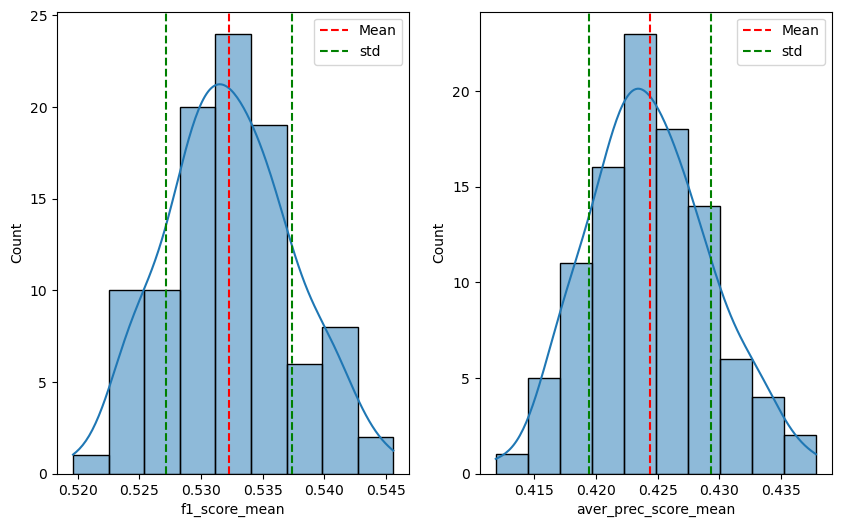

In [417]:
visializ_final_anal_model(rand_for_rand_state_metrics_df, rand_for_final_analize_dic)

## Analyze models

### By different random state

In [549]:
classific_all_model_dic = {'Log_reg': log_reg_final_analize_dic, 'LinearSVC': lin_svc_final_analize_dic, 'NB_Hybrid': nb_final_analize_dic, 'Random_Forest': rand_for_final_analize_dic}

In [551]:
classific_genre_all_model_df = pd.DataFrame.from_dict(classific_all_model_dic, orient='index')

In [553]:
classific_genre_all_model_df

f1_score_mean  f1_score_std  aver_prec_score_mean  \
Log_reg             0.512823      0.004911              0.397913   
LinearSVC           0.510921      0.004473              0.402394   
NB_Hybrid           0.386278      0.004793              0.281563   
Random_Forest       0.532298      0.005098              0.424386   

               aver_prec_score_std  
Log_reg                   0.004725  
LinearSVC                 0.004421  
NB_Hybrid                 0.003608  
Random_Forest             0.004911

In [555]:
classific_genre_all_model_df.reset_index(inplace = True, names = 'model')

In [557]:
classific_genre_all_model_df

model  f1_score_mean  f1_score_std  aver_prec_score_mean  \
0        Log_reg       0.512823      0.004911              0.397913   
1      LinearSVC       0.510921      0.004473              0.402394   
2      NB_Hybrid       0.386278      0.004793              0.281563   
3  Random_Forest       0.532298      0.005098              0.424386   

   aver_prec_score_std  
0             0.004725  
1             0.004421  
2             0.003608  
3             0.004911

#### F-test for testing the hypothesis of equality of variances

In [559]:
sample_size_stability = 100 

In [561]:
def fill_equality_var(lst_std, dfn, dfd):
    sign_diff_var = []
    for n_index in range(len(lst_std)):
        var_n = lst_std[n_index] ** 2
        for d_index in range(n_index+1, len(lst_std)):
            var_d = lst_std[d_index] ** 2
            F_stat = var_n/var_d
            p_value = 1 - stats.f.cdf(F_stat, dfn, dfd)
            p_value = 2 * min(p_value, 1 - p_value) #two-sidedness of the test
            if p_value < 0.05:
                sign_diff_var.append(1)
            else:
                sign_diff_var.append(0)
    return sign_diff_var

In [563]:
dfn = sample_size_stability - 1
dfd = sample_size_stability - 1

In [565]:
fill_equality_var(list(classific_genre_all_model_df['f1_score_std']), dfn, dfd)

[0, 0, 0, 0, 0, 0]

In [567]:
# conclusion: there is no significalt diferences in variances (f1-score) => Student's t-test

In [569]:
fill_equality_var(list(classific_genre_all_model_df['aver_prec_score_std']), dfn, dfd)

[0, 1, 0, 1, 0, 1]

In [571]:
# conclusion: there is significalt diferences in variances (aver_prec_score) => Welch's t-test

#### t-test (check statistically difference)

In [574]:
def t_test(metric_mean, metric_std, df_metric_models, sample_size_stability, equal_var_bool):
    df = pd.DataFrame(index = df_metric_models['model'].to_list(), columns = df_metric_models['model'].to_list())
    for row_ind_model in range(df_metric_models.shape[0]):
        for col_ind_model in range(row_ind_model + 1, df_metric_models.shape[0]):
            p_val = stats.ttest_ind_from_stats(mean1 = df_metric_models.loc[row_ind_model,metric_mean], 
                                           std1 = df_metric_models.loc[row_ind_model, metric_std], 
                                           nobs1 = sample_size_stability, 
                                           mean2 = df_metric_models.loc[col_ind_model,metric_mean], 
                                           std2 = df_metric_models.loc[col_ind_model, metric_std], 
                                           nobs2 = sample_size_stability, 
                                           equal_var=equal_var_bool).pvalue
            if p_val < 0.05:
                df.loc[df_metric_models.loc[row_ind_model, 'model'], df_metric_models.loc[col_ind_model, 'model']] = 1
            else:
                df.loc[df_metric_models.loc[row_ind_model, 'model'], df_metric_models.loc[col_ind_model, 'model']] = 0
    return df

##### Aver_prec_score

In [577]:
aver_prec_score_welchs_test_df = t_test('aver_prec_score_mean', 'aver_prec_score_std', classific_genre_all_model_df, sample_size_stability, False)

In [579]:
aver_prec_score_welchs_test_df

Log_reg LinearSVC NB_Hybrid Random_Forest
Log_reg           NaN         1         1             1
LinearSVC         NaN       NaN         1             1
NB_Hybrid         NaN       NaN       NaN             1
Random_Forest     NaN       NaN       NaN           NaN

In [396]:
# Conclusion: difference between models is statistically significant => best: find the max score

In [581]:
classific_genre_all_model_df.loc[classific_genre_all_model_df['aver_prec_score_mean'] == classific_genre_all_model_df['aver_prec_score_mean'].max(), 'model']

3    Random_Forest
Name: model, dtype: object

##### F1-score

In [584]:
f1_score_students_test_df = t_test('f1_score_mean', 'f1_score_std', classific_genre_all_model_df, sample_size_stability, True)

In [586]:
f1_score_students_test_df

Log_reg LinearSVC NB_Hybrid Random_Forest
Log_reg           NaN         1         1             1
LinearSVC         NaN       NaN         1             1
NB_Hybrid         NaN       NaN       NaN             1
Random_Forest     NaN       NaN       NaN           NaN

In [588]:
# Conclusion: difference between models is statistically significant => best: find the max score

In [590]:
classific_genre_all_model_df.loc[classific_genre_all_model_df['f1_score_mean'] == classific_genre_all_model_df['f1_score_mean'].max(), 'model']

3    Random_Forest
Name: model, dtype: object

### By distribution of f-score

In [592]:
models_f1_test_classif = metrics_test_best_thr_log_reg.loc[:,['support', 'f1-score']]

In [594]:
models_f1_test_classif = models_f1_test_classif.rename(columns = {'f1-score': 'f1-score_log_reg'})

In [596]:
models_f1_test_classif['f1-score_lin_svc'] = metrics_test_best_thr_lin_svc['f1-score']

In [598]:
models_f1_test_classif['f1-score_NB_hybrid'] = metrics_test_best_thr_nb['f1-score']

In [600]:
models_f1_test_classif['f1-score_Random_Forest'] = metrics_test_best_thr_rand_for['f1-score']

In [602]:
models_f1_test_classif.reset_index(inplace = True, names = 'genre')

In [604]:
models_f1_test_classif = models_f1_test_classif.iloc[0:21]

In [606]:
models_f1_test_classif

genre  support  f1-score_log_reg  f1-score_lin_svc  \
0       Musical      0.0          0.000000          0.000000   
1         Music      1.0          0.000000          0.000000   
2       Western      1.0          0.000000          0.000000   
3   Documentary      1.0          0.000000          0.000000   
4         Sport      3.0          0.000000          0.000000   
5     Biography      5.0          0.285714          0.000000   
6        Horror      5.0          0.250000          0.250000   
7       History      5.0          0.285714          0.000000   
8       Mystery      7.0          0.000000          0.000000   
9           War      8.0          0.000000          0.000000   
10        Crime     11.0          0.153846          0.166667   
11    Animation     11.0          0.818182          0.740741   
12       Family     17.0          0.736842          0.717949   
13      Romance     17.0          0.296296          0.190476   
14       Sci-Fi     22.0          0.459016          0.452830   
15      Fantasy     22.0          0.615385          0.622222   
16     Thriller     27.0          0.494118          0.481928   
17        Drama     34.0          0.606742          0.606742   
18       Comedy     35.0          0.707317          0.698795   
19    Adventure     41.0          0.616667          0.611570   
20       Action     47.0          0.713178          0.702290   

    f1-score_NB_hybrid  f1-score_Random_Forest  
0             0.000000                0.000000  
1             0.166667                0.000000  
2             0.000000                1.000000  
3             0.500000                0.000000  
4             0.086957                0.500000  
5             0.375000                0.888889  
6             0.166667                0.666667  
7             0.476190                0.750000  
8             0.145455                0.500000  
9             0.400000                0.545455  
10            0.190476                0.421053  
11            0.511628                0.909091  
12            0.533333                0.971429  
13            0.173913                0.742857  
14            0.422222                0.791667  
15            0.473118                0.837209  
16            0.511628                0.701299  
17            0.444444                0.780488  
18            0.666667                0.883117  
19            0.593220                0.808511  
20            0.682540                0.796610

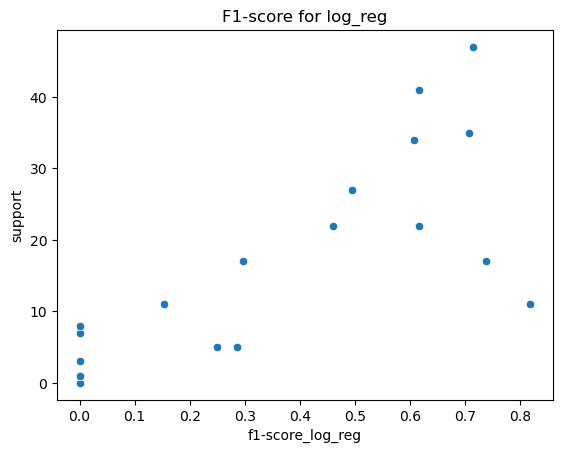

In [577]:
sns.scatterplot(x = 'f1-score_log_reg', y = 'support', data = models_f1_test_classif)
plt.title('F1-score for log_reg')
plt.show()

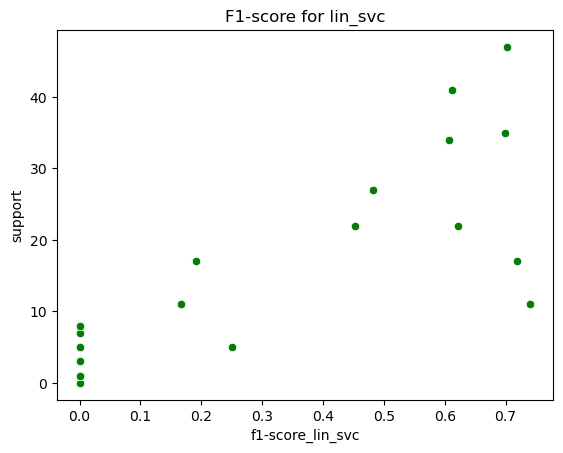

In [579]:
sns.scatterplot(x = 'f1-score_lin_svc', y = 'support', data = models_f1_test_classif, color = 'green')
plt.title('F1-score for lin_svc')
plt.show()

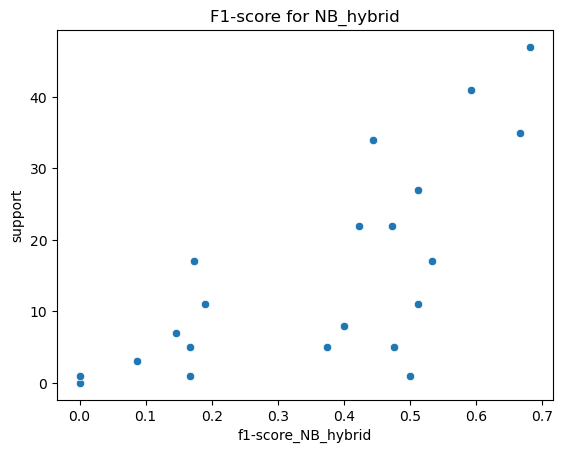

In [581]:
sns.scatterplot(x = 'f1-score_NB_hybrid', y = 'support',data = models_f1_test_classif)
plt.title('F1-score for NB_hybrid')
plt.show()

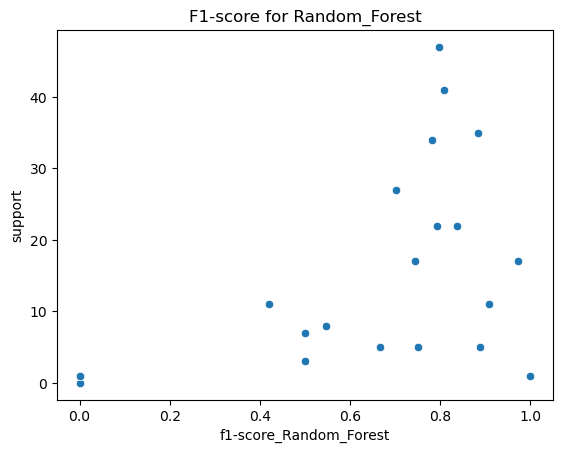

In [608]:
sns.scatterplot(x = 'f1-score_Random_Forest', y = 'support', data = models_f1_test_classif)
plt.title('F1-score for Random_Forest')
plt.show()